Research Question: What information do open-text student reviews provide beyond numerical ratings, and can text analysis identify actionable feedback that ratings alone cannot capture?

The dataset used in this project will be a publicly available data set from Huggingface, you can access the dataset from this link: https://huggingface.co/datasets/ZephyrUtopia/ratemyprofessors_reviews

GenAI tools were used as a learning source, ideation, improvement in code as well as to improve the visualization. If needed I will be able to explain all the code that is present there in this notebook.

Load the dataset from Hugging Face

In [2]:
from datasets import load_dataset
#Load the dataset from the site of Hugging Face
dataset = load_dataset("ZephyrUtopia/ratemyprofessors_reviews")
print(dataset)

/Users/bikki/Documents/Projects_Spring_2026/SOSC314/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['name', 'text', 'rating', 'difficulty', 'date'],
        num_rows: 336239
    })
    test: Dataset({
        features: ['name', 'text', 'rating', 'difficulty', 'date'],
        num_rows: 144103
    })
})


Convert the dataset to pandas array

In [3]:
import pandas as pd
#as pandas array
df = pd.concat(
    [dataset[split].to_pandas() for split in dataset.keys()],
    ignore_index=True
)
print(df.columns)
print(df.shape)

Index(['name', 'text', 'rating', 'difficulty', 'date'], dtype='object')
(480342, 5)


Some basic printing functions to see some of the observations

In [4]:
#Don't get confused with the output, in some of the cases when pandas cannot squeeze data, it divides
#the data in the way as shows in the output
print(df)
print(df["text"].head())
print(df["rating"].value_counts())
print(df["rating"].describe()) #rating is still not numeric, so this does not give too much information
print(df.describe())
print(pd.to_numeric(df["rating"], errors = "coerce").describe()) #converting rating to numerical value coerce will assign
#NaN value to missing or invalid data, also here describe will give all the parameters it gives for numericals

                        name  \
0               Leila Hawana   
1              Gloria Magana   
2          Teresa Canganelli   
3                Kumar Ankit   
4               Irina Garces   
...                      ...   
480337        Crystal Koenig   
480338        Karen Caldwell   
480339        Andrew Hudnall   
480340  David-James Gonzalez   
480341          Tyler Vouros   

                                                     text rating difficulty  \
0       Although the homework is not too much, they ar...    4.0        5.0   
1       Where can I start she's a very tough grader. H...    1.0        5.0   
2       She is a wonderful professor! Very interactive...    5.0        4.0   
3       Study solutions had incorrect answers taken fr...    1.0        4.0   
4       Super nice and helpful. Was always there in of...    5.0        4.0   
...                                                   ...    ...        ...   
480337  Amazing! Dr. Koenig gives the best lectures of...    5

Add some demo of the plots using seaborn

In [5]:
%pip install seaborn
%pip install matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Bar chart for frequency count of each of the ratings

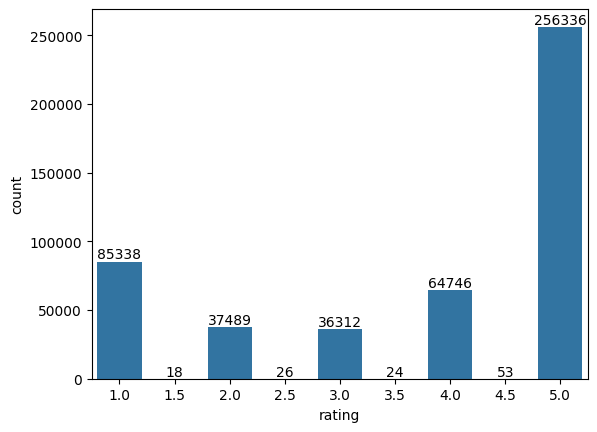

In [6]:
#Ratings are ordered in ascending order
ax = sns.countplot(
    data=df,
    x="rating",
    order=sorted(df["rating"].dropna().unique())
)
#Add frequency labels on top of each bar
#In matplot/seaborn, bars are store in "containers", so this loop goes to every bar in iterations
for container in ax.containers:
    ax.bar_label(container)
#Display the plot, in jupyter notebook this graph is shown even without the following line, but it might not be the case for .py or
#other coding environments, so writing the following line ensures portability
plt.show()


Make a new dataset that has rating as numerical rather than string

In [7]:
#Make a new dataset df_num where we'll make changes to the dataset df and have numerical values for rating
df_num = df.copy()
df_num["rating"] = pd.to_numeric(df["rating"], errors = "coerce")

#Sanity checks (better than printing the entire dataframe)
print(df_num["rating"].dtype)
print(df_num.shape)

float64
(480342, 5)


Remove the observations with rating as 1.5, 2.5, 3.5 or 4.5

In [8]:
#Check the divisibility of the dating by 1, if its not divisible by 1 
#(if its a float with some value after the decimal) remove those observations
df_num = df_num[df_num["rating"] % 1 == 0]
df_num = df_num.reset_index(drop=True)

#Sanity checks
print(df_num.shape)
print(df_num["rating"].value_counts().sort_index())

(480221, 5)
rating
1.0     85338
2.0     37489
3.0     36312
4.0     64746
5.0    256336
Name: count, dtype: int64


## Completing Data Construction & Measurement

Now we'll complete the data cleaning, create comprehensive descriptive statistics, and prepare the dataset for modeling.

In [9]:
# Check for missing values in our cleaned dataset
print("Missing values in cleaned dataset:")
print(df_num.isnull().sum())

# Check for duplicate reviews
duplicates = df_num.duplicated(subset=['text']).sum()
print(f"Number of duplicate reviews (based on text): {duplicates}")
print(f"Percentage of duplicates: {(duplicates/len(df_num)*100):.2f}%")
df_clean = df_num.copy()

Missing values in cleaned dataset:
name          0
text          0
rating        0
difficulty    0
date          0
dtype: int64
Number of duplicate reviews (based on text): 0
Percentage of duplicates: 0.00%


### Text Cleaning and Preprocessing
We'll clean the review text by handling basic issues like extra whitespace, but preserve meaningful content.

In [10]:
import re

def clean_text(text):
    # Handle missing or empty values
    if pd.isna(text) or text == '':
        return ''

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove punctuation (so "class." -> "class")
    # Keeps letters, numbers, underscores, and spaces
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace (tabs, newlines, multiple spaces)
    text = re.sub(r'\s+', ' ', text)

    # Strip leading/trailing whitespace
    text = text.strip()

    return text


# Apply text cleaning
df_clean['text_cleaned'] = df_clean['text'].apply(clean_text)


In [11]:
# Calculate word count for each review
df_clean['word_count'] = df_clean['text_cleaned'].apply(lambda x: len(x.split()))

# Calculate character count
df_clean['char_count'] = df_clean['text_cleaned'].apply(len)

print("Text statistics:")
print(df_clean[['word_count', 'char_count']].describe())

# Identify very short reviews (less than 5 words)
short_reviews = df_clean[df_clean['word_count'] < 5]
print(f"\nReviews with less than 5 words: {len(short_reviews)} ({len(short_reviews)/len(df_clean)*100:.2f}%)")

Text statistics:
          word_count     char_count
count  480221.000000  480221.000000
mean       47.453362     255.687232
std        17.776241      93.831220
min         0.000000       0.000000
25%        36.000000     194.000000
50%        54.000000     298.000000
75%        61.000000     333.000000
max        87.000000     492.000000

Reviews with less than 5 words: 7362 (1.53%)


In [12]:
# Remove reviews with less than 5 words (too short to be meaningful)
df_clean = df_clean[df_clean['word_count'] >= 5].copy()
df_clean = df_clean.reset_index(drop=True)

print(f"Dataset size after removing short reviews: {len(df_clean)}")
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
print(f"Total reviews removed from original: {len(df_num) - len(df_clean)}")

Dataset size after removing short reviews: 472859

Final cleaned dataset shape: (472859, 8)
Total reviews removed from original: 7362


In [13]:
# Convert date column to datetime
df_clean['date_parsed'] = pd.to_datetime(df_clean['date'], errors='coerce')

# Extract year and month
df_clean['year'] = df_clean['date_parsed'].dt.year
df_clean['month'] = df_clean['date_parsed'].dt.month

# Check date parsing results
print("Date parsing results:")
print(f"Successfully parsed dates: {df_clean['date_parsed'].notna().sum()}")
print(f"Failed to parse: {df_clean['date_parsed'].isna().sum()}")
print(f"\nYear range: {df_clean['year'].min()} to {df_clean['year'].max()}")

Date parsing results:
Successfully parsed dates: 472859
Failed to parse: 0

Year range: 2003 to 2024


In [14]:
# Create binary target: 1 for positive (4-5), 0 for negative (1-2)
# Remove neutral reviews (3)

# Guessing the exact rating might be difficult because of the dominance of rating of 5, because of which we'll be working on 
# identifying if the comment is positive or negative and to remove the ambiguity created by the rating of 3, we'll remove the 
# rating of 3

df_modeling = df_clean[df_clean['rating'] != 3.0].copy()

df_modeling['sentiment'] = df_modeling['rating'].apply(
    lambda x: 1 if x >= 4 else 0
)

# Map to labels for clarity
df_modeling['sentiment_label'] = df_modeling['sentiment'].map({
    0: 'Negative',
    1: 'Positive'
})

print(f"Dataset size after removing neutral reviews: {len(df_modeling)}")
print(f"\nClass distribution:")
print(df_modeling['sentiment_label'].value_counts())
print(f"\nClass distribution (%):")
print(df_modeling['sentiment_label'].value_counts(normalize=True) * 100)
# Normalize converts the data to the proportion of the whole available data, so, multiplying by 100 gives percentage

Dataset size after removing neutral reviews: 436836

Class distribution:
sentiment_label
Positive    316271
Negative    120565
Name: count, dtype: int64

Class distribution (%):
sentiment_label
Positive    72.400397
Negative    27.599603
Name: proportion, dtype: float64


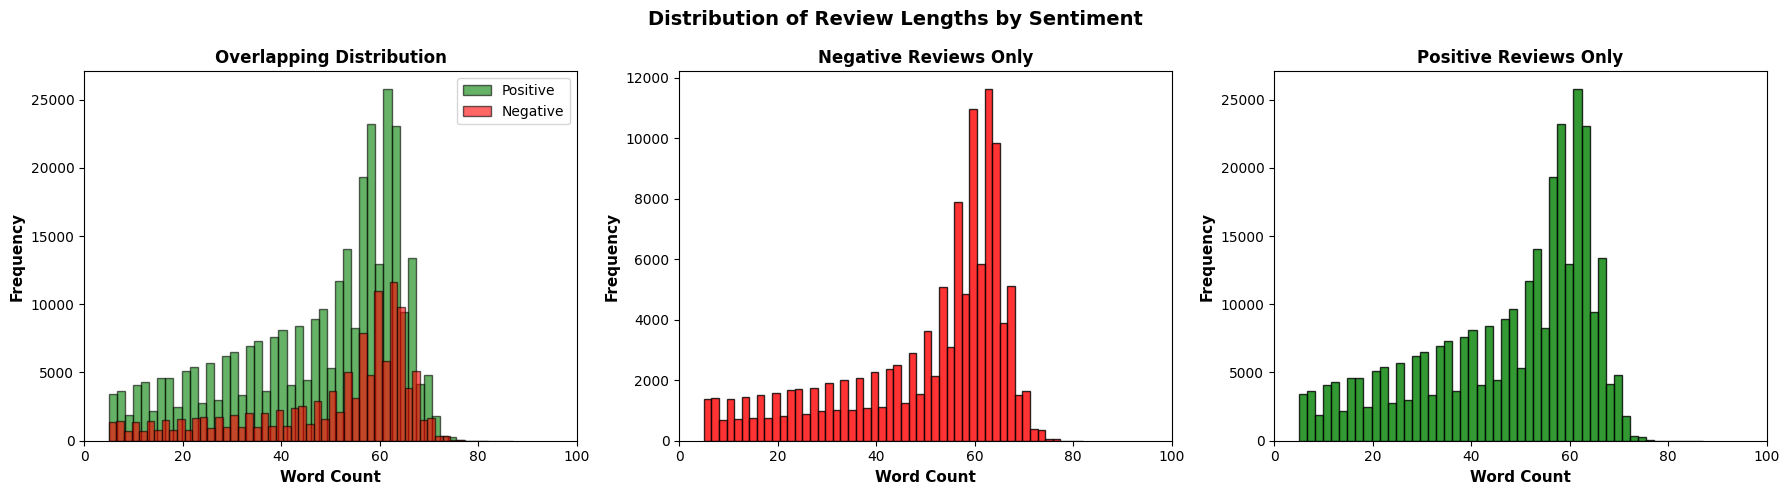

Word count statistics by sentiment:

NEGATIVE REVIEWS:
count    120565.000000
mean         49.710082
std          17.027085
min           5.000000
25%          40.000000
50%          57.000000
75%          62.000000
max          82.000000
Name: word_count, dtype: float64

POSITIVE REVIEWS:
count    316271.000000
mean         47.137834
std          17.093259
min           5.000000
25%          35.000000
50%          53.000000
75%          61.000000
max          87.000000
Name: word_count, dtype: float64


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Overlapping histograms with TRANSPARENCY

axes[0].hist(df_modeling[df_modeling['sentiment']==1]['word_count'], 
             bins=50, alpha=0.6, label='Positive', color='green', edgecolor='black')
axes[0].hist(df_modeling[df_modeling['sentiment']==0]['word_count'], 
             bins=50, alpha=0.6, label='Negative', color='red', edgecolor='black')
axes[0].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Overlapping Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 100)
#set_xlim helps to keep the reviews with length 0 to 100 and ignore other outliers that is way beyond 100 words.

# Plot 2: Separate histograms
axes[1].hist(df_modeling[df_modeling['sentiment']==0]['word_count'], 
             bins=50, alpha=0.8, color='red', edgecolor='black')
axes[1].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Negative Reviews Only', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 100)

axes[2].hist(df_modeling[df_modeling['sentiment']==1]['word_count'], 
             bins=50, alpha=0.8, color='green', edgecolor='black')
axes[2].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title('Positive Reviews Only', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 100)

plt.suptitle('Distribution of Review Lengths by Sentiment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print("Word count statistics by sentiment:")
print("\nNEGATIVE REVIEWS:")
print(df_modeling[df_modeling['sentiment']==0]['word_count'].describe())
print("\nPOSITIVE REVIEWS:")
print(df_modeling[df_modeling['sentiment']==1]['word_count'].describe())

/var/folders/mg/bhg2988s5fq125xdwn5j_0nh0000gn/T/ipykernel_4820/3561641859.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot,


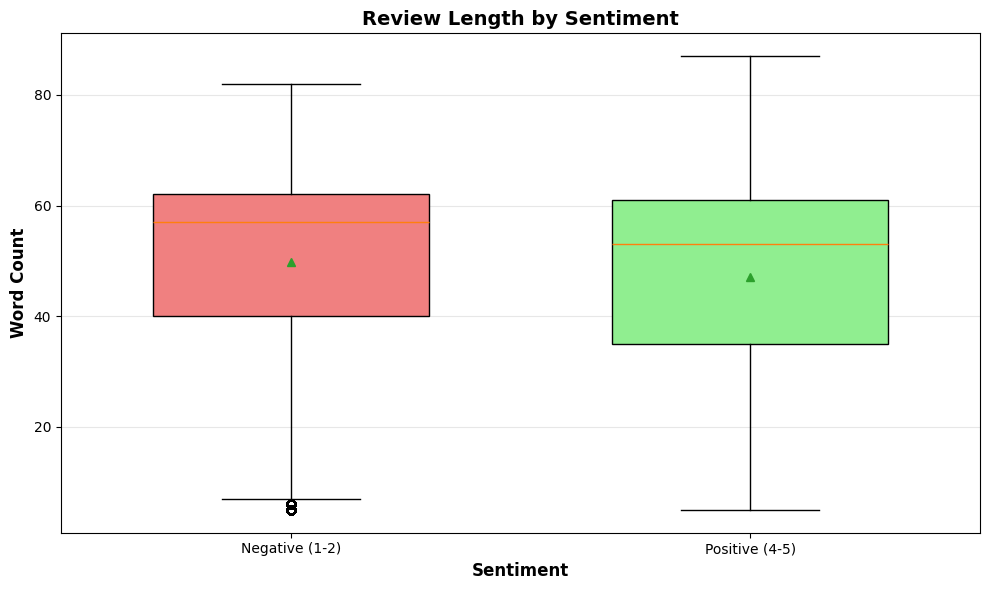

Negative median: 57.0
Positive median: 53.0


In [16]:
# box plot
plt.figure(figsize=(10, 6))

data_to_plot = [
    df_modeling[df_modeling['sentiment']==0]['word_count'],
    df_modeling[df_modeling['sentiment']==1]['word_count']
]

bp = plt.boxplot(data_to_plot, 
                 labels=['Negative (1-2)', 'Positive (4-5)'],
                 patch_artist=True, 
                 widths=0.6,
                 showmeans=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')

plt.ylabel('Word Count', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12, fontweight='bold')
plt.title('Review Length by Sentiment', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Negative median:", df_modeling[df_modeling['sentiment']==0]['word_count'].median())
print("Positive median:", df_modeling[df_modeling['sentiment']==1]['word_count'].median())

## Word Frequency Analysis

In [17]:
!pip install scikit-learn

## Word Frequency Analysis

In [18]:
# Word Frequency Analysis (Using sklearn stopwords)

from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Use sklearn's built-in stopwords (no download needed!)
stop_words = ENGLISH_STOP_WORDS

def get_word_frequencies(texts, top_n=20):
    all_words = []
    for text in texts:
        if pd.isna(text): # We don't really need this because we have already cleared the ones with NaN and None, but its a good practice
            continue
        words = str(text).split()
        # Filter out stopwords and very short words
        words = [w for w in words if w not in stop_words and len(w) > 2] # This will help to remove stop words and super small words
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

# Get top words for positive and negative reviews
print("Analyzing word frequencies...")
positive_reviews = df_modeling[df_modeling['sentiment']==1]['text_cleaned']
negative_reviews = df_modeling[df_modeling['sentiment']==0]['text_cleaned']

top_positive = get_word_frequencies(positive_reviews, 20)
top_negative = get_word_frequencies(negative_reviews, 20)

print("TOP 20 WORDS IN POSITIVE REVIEWS (4-5 stars)")
for i, (word, count) in enumerate(top_positive, 1):
    print(f"{i:2d}. {word:.<25} {count:>8,} occurrences")

print("TOP 20 WORDS IN NEGATIVE REVIEWS (1-2 stars)")
for i, (word, count) in enumerate(top_negative, 1):
    print(f"{i:2d}. {word:.<25} {count:>8,} occurrences")


Analyzing word frequencies...
TOP 20 WORDS IN POSITIVE REVIEWS (4-5 stars)
 1. class....................  282,986 occurrences
 2. professor................  151,427 occurrences
 3. easy.....................   90,049 occurrences
 4. great....................   81,270 occurrences
 5. really...................   77,874 occurrences
 6. students.................   77,262 occurrences
 7. lectures.................   62,858 occurrences
 8. work.....................   56,636 occurrences
 9. good.....................   54,493 occurrences
10. best.....................   52,297 occurrences
11. lot......................   51,999 occurrences
12. help.....................   45,984 occurrences
13. assignments..............   44,051 occurrences
14. gives....................   40,617 occurrences
15. course...................   40,429 occurrences
16. recommend................   39,248 occurrences
17. just.....................   39,027 occurrences
18. time.....................   37,779 occurrences
19. car

## Visualize Word Frequencies

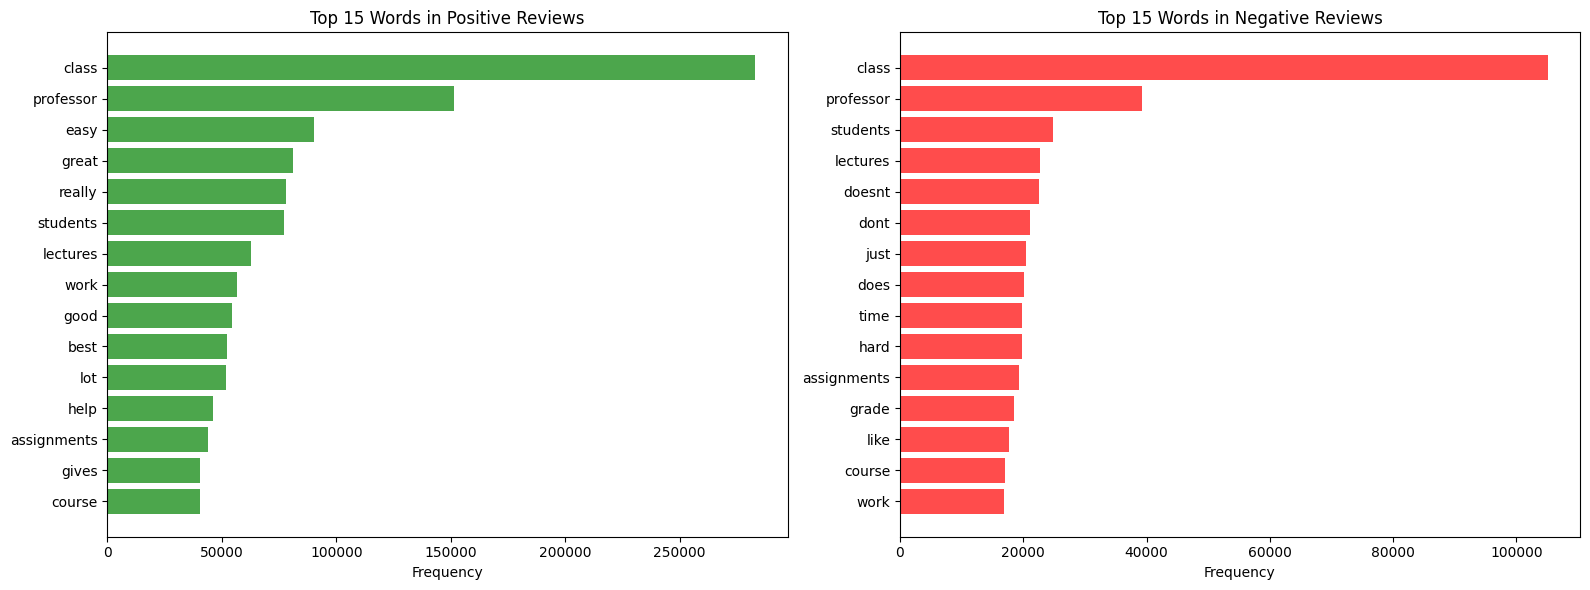

In [19]:
# Create bar plots for top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive reviews
words_pos, counts_pos = zip(*top_positive[:15])
axes[0].barh(words_pos, counts_pos, color='green', alpha=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Words in Positive Reviews')
axes[0].invert_yaxis()

# Negative reviews
words_neg, counts_neg = zip(*top_negative[:15])
axes[1].barh(words_neg, counts_neg, color='red', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Words in Negative Reviews')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Temporal Analysis - Ratings Over Time

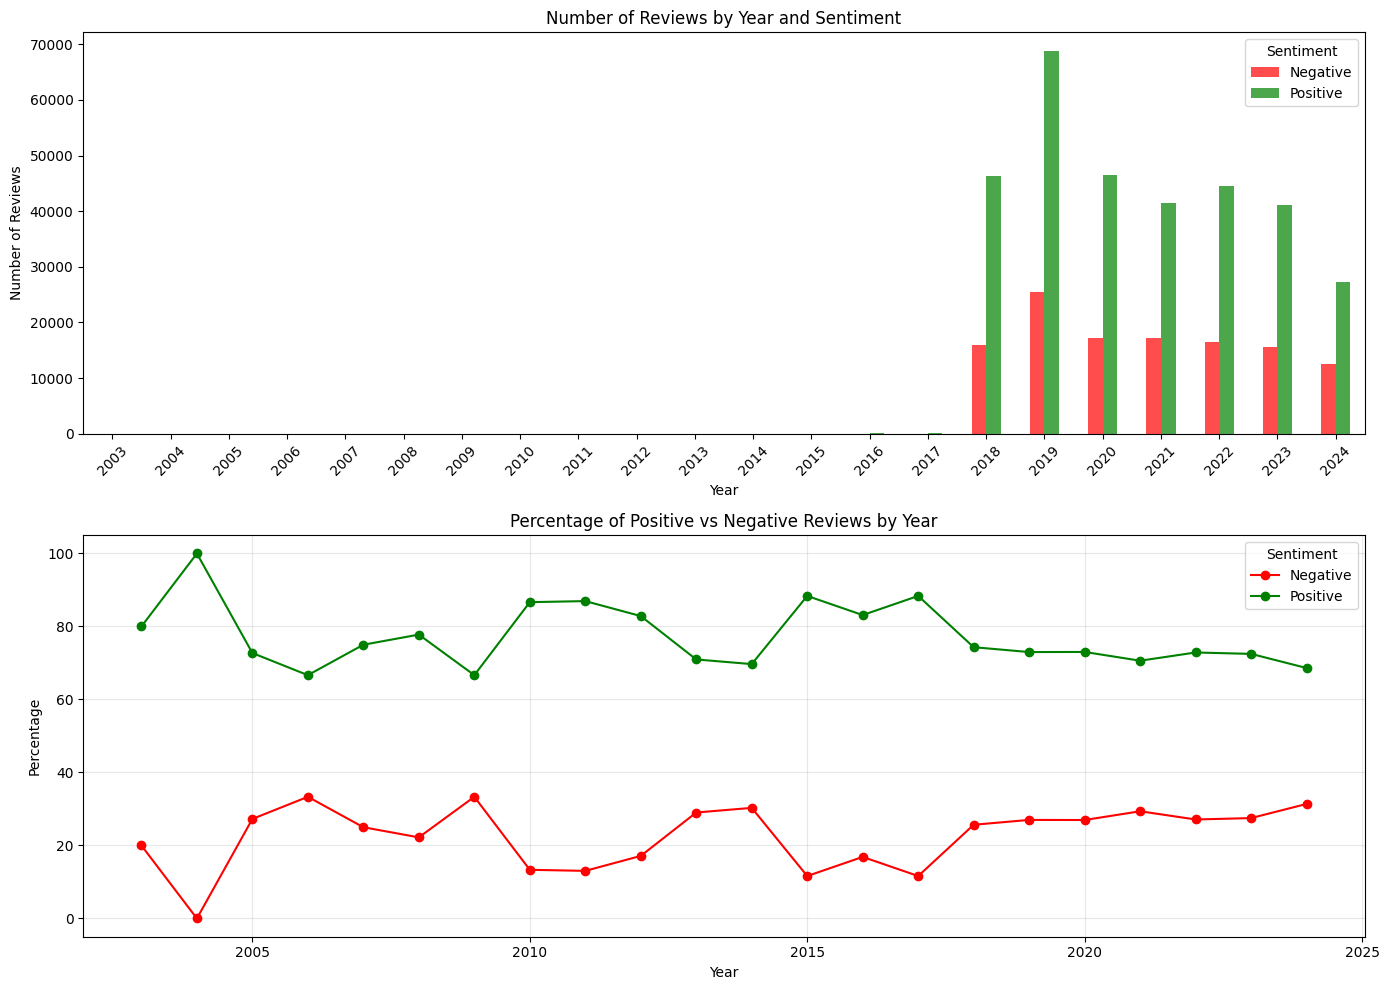

Average ratings by year:
year
2003    4.40
2004    4.33
2005    3.73
2006    3.58
2007    3.94
2008    4.00
2009    3.67
2010    4.27
2011    4.39
2012    4.20
2013    3.84
2014    3.88
2015    4.35
2016    4.22
2017    4.40
2018    3.88
2019    3.84
2020    3.85
2021    3.76
2022    3.88
2023    3.87
2024    3.72
Name: rating, dtype: float64


In [20]:
# Ratings over time
yearly_ratings = df_modeling.groupby(['year', 'sentiment_label']).size().unstack(fill_value=0)
# unstack will help convert rows to columns, if we don't do that the data would look like:
# year   sentiment_level
# 2018   0    16000
#        1    46000
# 2019   0    25000
#        1    69000

# But after using unstack it'll look like:
# sentiment_label      0      1
# year
# 2018             16000  46000
# 2019             25000  69000

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Absolute counts
yearly_ratings.plot(kind='bar', ax=axes[0], color=['red', 'green'], alpha=0.7)
axes[0].set_title('Number of Reviews by Year and Sentiment')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Reviews')
axes[0].legend(title='Sentiment')
axes[0].tick_params(axis='x', rotation=45)

# Proportions
yearly_props = yearly_ratings.div(yearly_ratings.sum(axis=1), axis=0) * 100
yearly_props.plot(kind='line', ax=axes[1], marker='o', color=['red', 'green'])
axes[1].set_title('Percentage of Positive vs Negative Reviews by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Sentiment')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Average ratings by year:")
print(df_modeling.groupby('year')['rating'].mean().round(2))

## Difficulty vs Rating Analysis

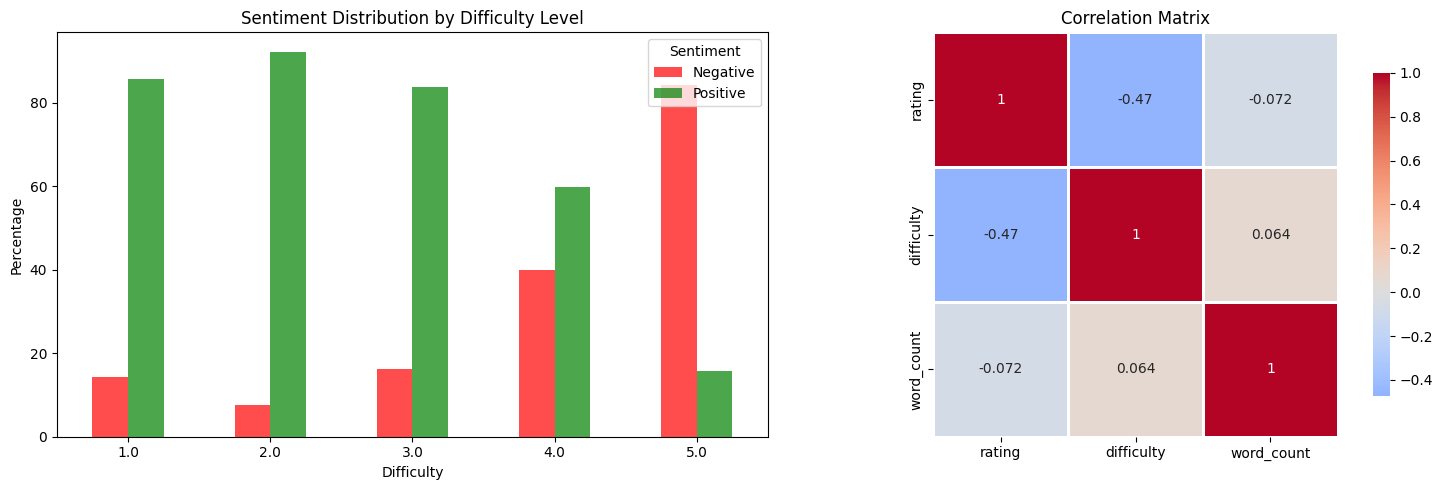


Correlation between rating and difficulty:
Pearson correlation: -0.475


In [21]:
# Difficulty vs Rating relationship
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cross-tabulation
crosstab = pd.crosstab(df_modeling['difficulty'], df_modeling['sentiment_label'], normalize='index') * 100
crosstab.plot(kind='bar', ax=axes[0], color=['red', 'green'], alpha=0.7)
axes[0].set_title('Sentiment Distribution by Difficulty Level')
axes[0].set_xlabel('Difficulty')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Sentiment')
axes[0].tick_params(axis='x', rotation=0)

# Correlation heatmap
corr_data = df_modeling[['rating', 'difficulty', 'word_count']].corr()
# .corr() calculates the pearson correlation between each pair
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=axes[1], 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

print("\nCorrelation between rating and difficulty:")
print(f"Pearson correlation: {df_modeling[['rating', 'difficulty']].corr().iloc[0, 1]:.3f}")

## Class Imbalance Visualization

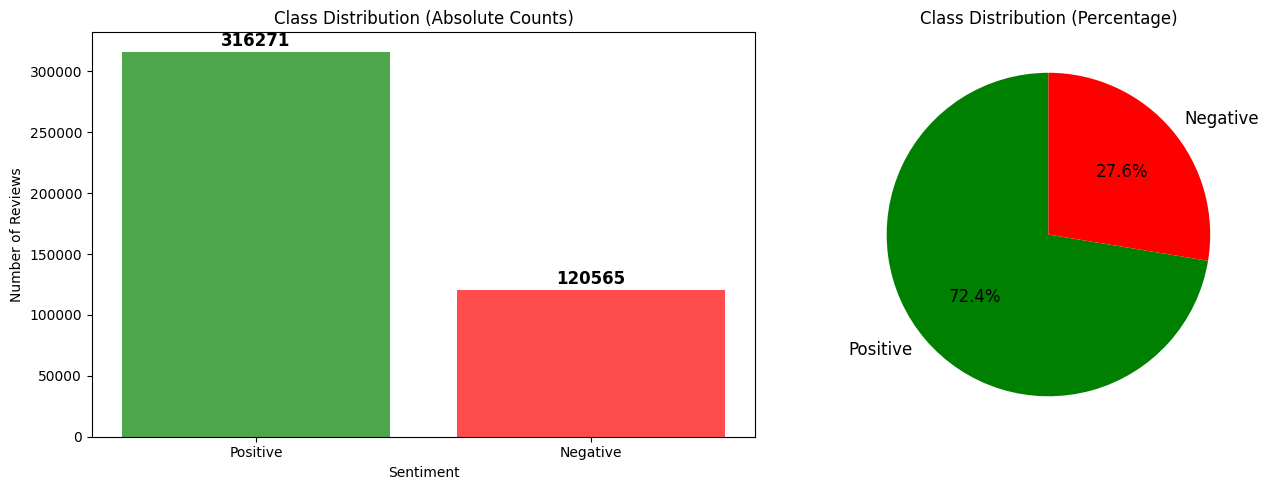

Class imbalance ratio: 2.62:1

This means we have 2.62 positive reviews
for every 1 negative review


In [22]:
# Detailed class imbalance analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sentiment_counts = df_modeling['sentiment_label'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Class Distribution (Absolute Counts)')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Reviews')
for i, v in enumerate(sentiment_counts.values):
# The iteration will go for 2 cycles one when the value of sentiment_counts is 0 and the other when its 1
    axes[0].text(i, v + 5000, str(v), ha='center', fontsize=12, fontweight='bold')

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['green', 'red'], startangle=90, textprops={'fontsize': 12})
# Here startangle gives the diagram the place for it to start from
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print(f"Class imbalance ratio: {sentiment_counts['Positive'] / sentiment_counts['Negative']:.2f}:1")
print(f"\nThis means we have {sentiment_counts['Positive'] / sentiment_counts['Negative']:.2f} positive reviews")
print(f"for every 1 negative review")

## Create Train-Test-Validation Splits

In [23]:

import numpy as np 
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
# This fixes the split so that it'll be consistent for the values coming onwards

# First split: 80% train+val, 20% test
X = df_modeling['text_cleaned']
y = df_modeling['sentiment']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
# Stratify will ensure the class proportion in the original dataset is carried over to the split as well
)

# Second split: split the temp into 75% train, 25% val (of the 80%)
# This gives us 60% train, 20% val, 20% test overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("DATASET SPLITS")
print(f"Training set:   {len(X_train):>7,} samples ({len(X_train)/len(df_modeling)*100:>5.1f}%)")
print(f"Validation set: {len(X_val):>7,} samples ({len(X_val)/len(df_modeling)*100:>5.1f}%)")
print(f"Test set:       {len(X_test):>7,} samples ({len(X_test)/len(df_modeling)*100:>5.1f}%)")
print(f"Total:          {len(df_modeling):>7,} samples")

print("CLASS DISTRIBUTION IN EACH SET")

print("\nTraining set:")
train_dist = y_train.value_counts(normalize=True).sort_index()
for sentiment, pct in train_dist.items():
    label = "Positive" if sentiment == 1 else "Negative"
    print(f"  {label}: {pct:.1%}")

print("\nValidation set:")
val_dist = y_val.value_counts(normalize=True).sort_index()
for sentiment, pct in val_dist.items():
    label = "Positive" if sentiment == 1 else "Negative"
    print(f"  {label}: {pct:.1%}")

print("\nTest set:")
test_dist = y_test.value_counts(normalize=True).sort_index()
for sentiment, pct in test_dist.items():
    label = "Positive" if sentiment == 1 else "Negative"
    print(f"  {label}: {pct:.1%}")

print("VERIFICATION: Class distributions are balanced across all sets!")

DATASET SPLITS
Training set:   262,101 samples ( 60.0%)
Validation set:  87,367 samples ( 20.0%)
Test set:        87,368 samples ( 20.0%)
Total:          436,836 samples
CLASS DISTRIBUTION IN EACH SET

Training set:
  Negative: 27.6%
  Positive: 72.4%

Validation set:
  Negative: 27.6%
  Positive: 72.4%

Test set:
  Negative: 27.6%
  Positive: 72.4%
VERIFICATION: Class distributions are balanced across all sets!


## Save Processed Data

In [24]:
# Create a final dataframe with all our processed features
df_final = df_modeling.copy()

# Save the full processed dataset
df_final.to_csv('processed_reviews.csv', index=False)
print("Saved full processed dataset to 'processed_reviews.csv'")

# Also save the split indices for reproducibility
split_data = {
    'train_indices': X_train.index.tolist(),
    'val_indices': X_val.index.tolist(),
    'test_indices': X_test.index.tolist()
}

import json
with open('split_indices.json', 'w') as f:
    json.dump(split_data, f)
print("Saved split indices to 'split_indices.json'")


Saved full processed dataset to 'processed_reviews.csv'
Saved split indices to 'split_indices.json'


# Import Libraries and Load Data

In [25]:
# Import additional libraries for modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import pickle

# Load the processed data
df_final = pd.read_csv('processed_reviews.csv')

# Load split indices
with open('split_indices.json', 'r') as f:
    split_data = json.load(f)

# Recreate splits
X_train = df_final.loc[split_data['train_indices'], 'text_cleaned']
y_train = df_final.loc[split_data['train_indices'], 'sentiment']

X_val = df_final.loc[split_data['val_indices'], 'text_cleaned']
y_val = df_final.loc[split_data['val_indices'], 'sentiment']

X_test = df_final.loc[split_data['test_indices'], 'text_cleaned']
y_test = df_final.loc[split_data['test_indices'], 'sentiment']

print("Data loaded successfully!")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

KeyError: '[454098, 465689, 438101, 440473, 445125, 449907, 443073, 448282, 437473, 451110, 452943, 465051, 455295, 465161, 467050, 446277, 461376, 450082, 449234, 464390, 441005, 442484, 468776, 453362, 442833, 447308, 454405, 440139, 453582, 462058, 447550, 470899, 452159, 439567, 458808, 443400, 448496, 461445, 440449, 441703, 464166, 472135, 447598, 452611, 458623, 444340, 441559, 442082, 445816, 459756, 467957, 471915, 460275, 444562, 442308, 462297, 467159, 465073, 447527, 458490, 437795, 448463, 440915, 447893, 462210, 470828, 452970, 448233, 470025, 450529, 460323, 438823, 455313, 450255, 463062, 468355, 459623, 461231, 441089, 453533, 448447, 448844, 467153, 467097, 459112, 443345, 454304, 456775, 446163, 447021, 443370, 461526, 466261, 457663, 454790, 460163, 438467, 447124, 457958, 472398, 471845, 453852, 454470, 439600, 445133, 441900, 442035, 459243, 456255, 450873, 462724, 458970, 447544, 466128, 446992, 452177, 460465, 445163, 471015, 461730, 469052, 448045, 439174, 454646, 468719, 445901, 443491, 449967, 459751, 465899, 438960, 466754, 442707, 437630, 438470, 467731, 464836, 467920, 453280, 441004, 464368, 458945, 468778, 469193, 467504, 463781, 440423, 470488, 463051, 457928, 450984, 464796, 472001, 452941, 464522, 457751, 454705, 470249, 457157, 468741, 439197, 458403, 452501, 446636, 455529, 440643, 471120, 443310, 454837, 462857, 462703, 455061, 465155, 445028, 451092, 467015, 444953, 445968, 442394, 445302, 437744, 439258, 470837, 451336, 447699, 467523, 449898, 438450, 439632, 447578, 440077, 454523, 453779, 466887, 442069, 468623, 471907, 437466, 453111, 451681, 456562, 469733, 452792, 446213, 460393, 454141, 462988, 448243, 447935, 453434, 440061, 462012, 450547, 454189, 459255, 458446, 450284, 453460, 458911, 438149, 471484, 465583, 451194, 450890, 465093, 445005, 463839, 469483, 447626, 451159, 457273, 442028, 441092, 439252, 472078, 455673, 454459, 462228, 470661, 458868, 437462, 471962, 464938, 458199, 450264, 463705, 465996, 438722, 446787, 457142, 450781, 464409, 469944, 441585, 450719, 441707, 451569, 455399, 449217, 441829, 455966, 469126, 465614, 471532, 439370, 440809, 446303, 452685, 467664, 464206, 449555, 440644, 448351, 439298, 459931, 440485, 441152, 454091, 453995, 446412, 442725, 460277, 442874, 438770, 445730, 460915, 467771, 438496, 458281, 437007, 457057, 438545, 459534, 450679, 469671, 456044, 465190, 463802, 448303, 440113, 465181, 454611, 470552, 450968, 438759, 466295, 443451, 470125, 449002, 453003, 466156, 439584, 457805, 449516, 469049, 463289, 447301, 467158, 452569, 461195, 450669, 470939, 467326, 445132, 464948, 454399, 440808, 446767, 449328, 452230, 445255, 468752, 454157, 457193, 459738, 467747, 460351, 469042, 446262, 466044, 468302, 455289, 471097, 437979, 461936, 466051, 449479, 470016, 457216, 471798, 438155, 438880, 469789, 438986, 469694, 438748, 467644, 451677, 467017, 450943, 449572, 456414, 444160, 460764, 444536, 446298, 457045, 459671, 436947, 461074, 464761, 444576, 458014, 458186, 451124, 449759, 464478, 465455, 446070, 442214, 457480, 442606, 441073, 471660, 440204, 440699, 457206, 472484, 447980, 442378, 467641, 471752, 463167, 467447, 465036, 469946, 439594, 456238, 443364, 444100, 461429, 442313, 453584, 444133, 450954, 451225, 442812, 450373, 439072, 464372, 446147, 443929, 459061, 456462, 443378, 437177, 452287, 469914, 466786, 467722, 448534, 470140, 448601, 471847, 470877, 445853, 454200, 451142, 439263, 448382, 452965, 457687, 457011, 461578, 463518, 451160, 438215, 438604, 453698, 465067, 460720, 450320, 449885, 464560, 453939, 449221, 465408, 472444, 444331, 441507, 438183, 464909, 466864, 443984, 460850, 443283, 448056, 471266, 471942, 439825, 459275, 440628, 472774, 449527, 464644, 455979, 469364, 472143, 464079, 452012, 450100, 439467, 466793, 459610, 449992, 447471, 470838, 453042, 465758, 456379, 459795, 438077, 459258, 458037, 440762, 466538, 456823, 452682, 471533, 459799, 456402, 462463, 446654, 470889, 443351, 466971, 471715, 453822, 451384, 443372, 453442, 466243, 470458, 443987, 459536, 446549, 453854, 453308, 447950, 471630, 442270, 440677, 446976, 444265, 454111, 447279, 455391, 465616, 452019, 466927, 472838, 461704, 442642, 459245, 445830, 472796, 442765, 461337, 442016, 461763, 466043, 449966, 455840, 464127, 450817, 456981, 457886, 437708, 445492, 460979, 471072, 439324, 443601, 439413, 439434, 447779, 466885, 442512, 465006, 439569, 455118, 461056, 463353, 437210, 447001, 458436, 443532, 470878, 467838, 464233, 458181, 466075, 467477, 453507, 460718, 457219, 448543, 439339, 452396, 460960, 450108, 461612, 467227, 462515, 450813, 464541, 443494, 472434, 437428, 471207, 445851, 464392, 452859, 443380, 454623, 442138, 446967, 448688, 460056, 467405, 450483, 452883, 441128, 455256, 472160, 462953, 463017, 442306, 450894, 450001, 461511, 456431, 439479, 466111, 450718, 463225, 459785, 448544, 438728, 443110, 462749, 469900, 465781, 454644, 464608, 461371, 447956, 457016, 465439, 463086, 472722, 438123, 455059, 449781, 452486, 445322, 460490, 456302, 462876, 437952, 443078, 438195, 445217, 448080, 451679, 452981, 460972, 459804, 450156, 463758, 467522, 445775, 440735, 470677, 465116, 440141, 436917, 460941, 452801, 465423, 450511, 440194, 455214, 458331, 457761, 439642, 470193, 451301, 446753, 470278, 454881, 456325, 440861, 461701, 471881, 442299, 465734, 466381, 448436, 460537, 438850, 441287, 449102, 463096, 464045, 450912, 472697, 440311, 456465, 445513, 455065, 456046, 451412, 464863, 456638, 466396, 456024, 446972, 462114, 439311, 455420, 439571, 455366, 468665, 455880, 457481, 472264, 447170, 463261, 472332, 452048, 470759, 471216, 452288, 440160, 466087, 446759, 441306, 457252, 470568, 449525, 452923, 463384, 448571, 465779, 472488, 463395, 456713, 459148, 456827, 457469, 440158, 456232, 455274, 443366, 467160, 460758, 443298, 447734, 455568, 468174, 452930, 457944, 452709, 471081, 470013, 439826, 440684, 440576, 449813, 444464, 469017, 443454, 461239, 464770, 461694, 461250, 443816, 459445, 471764, 464147, 465638, 467568, 440678, 456808, 447807, 469658, 468475, 469271, 444890, 463787, 437011, 449387, 451964, 457239, 447534, 440696, 461756, 452909, 466193, 452123, 448285, 441055, 452367, 439133, 438937, 457384, 439582, 447847, 470935, 450031, 451800, 451326, 470011, 471556, 443442, 470913, 453095, 466005, 448815, 469075, 467762, 459599, 471904, 457863, 457541, 439992, 439141, 462338, 456258, 455320, 453529, 456567, 451107, 445091, 465682, 455356, 470264, 459339, 472676, 468048, 466813, 458762, 437622, 463800, 443486, 464727, 455712, 451342, 440128, 436948, 444575, 454170, 438594, 464287, 449153, 438203, 453688, 440895, 449452, 471732, 470879, 442536, 451651, 456530, 464662, 461452, 469390, 471775, 455108, 468360, 461791, 442877, 455948, 446495, 465377, 437572, 449684, 456821, 437967, 441876, 468984, 450970, 437075, 462536, 451527, 459293, 447425, 458363, 447561, 453653, 451820, 464884, 438083, 445562, 465146, 445043, 452000, 472354, 451325, 468546, 442752, 446024, 461309, 472691, 470339, 456293, 471232, 438714, 472508, 442649, 463869, 440972, 453998, 456588, 456590, 438346, 460094, 445315, 463683, 449906, 441309, 436935, 468985, 466682, 459132, 441034, 441591, 443881, 444463, 444491, 470743, 460809, 450690, 438955, 456317, 470087, 444486, 469388, 453253, 470201, 441795, 463813, 460683, 453150, 452138, 457529, 467250, 450809, 447459, 439646, 449987, 444015, 447583, 452716, 465561, 447156, 453153, 472303, 442128, 458899, 468631, 459456, 458385, 446284, 472255, 447013, 472478, 441942, 439280, 452315, 470223, 472730, 453904, 463107, 440817, 440175, 446803, 453949, 463297, 454363, 457939, 446846, 457468, 464539, 437249, 461499, 457500, 446195, 445923, 470073, 457047, 451256, 445845, 472238, 471542, 452799, 465773, 439607, 458434, 464685, 443683, 467105, 448378, 468024, 449100, 464415, 471633, 472816, 467029, 462396, 444062, 460680, 463928, 441444, 469064, 449471, 470310, 461286, 472421, 460431, 456730, 465546, 471338, 457197, 442539, 454700, 462993, 461049, 451220, 469542, 453319, 458098, 457927, 472372, 470812, 438763, 463867, 447742, 449192, 449327, 450474, 467969, 437920, 450379, 454827, 437490, 464322, 454443, 452260, 469813, 463861, 455666, 450246, 439282, 449025, 472132, 452690, 450722, 458701, 453398, 453062, 467235, 466526, 450093, 444990, 456842, 459267, 468880, 456372, 438929, 450668, 447174, 454217, 437542, 447269, 449443, 455213, 451323, 439191, 462635, 467720, 446136, 436853, 469724, 452645, 470212, 452300, 451113, 439551, 467379, 455624, 447639, 465770, 449433, 459142, 448969, 454487, 458313, 455374, 456446, 458902, 455792, 457395, 447850, 437724, 437382, 471611, 454935, 446727, 470044, 443191, 442412, 439301, 470540, 468224, 438431, 455482, 470365, 465098, 465358, 451033, 468881, 462276, 446270, 440464, 451659, 463438, 467457, 470538, 459605, 436933, 441038, 445977, 451740, 452353, 439550, 462108, 448940, 471168, 461109, 459530, 459729, 455095, 451156, 466298, 459978, 470381, 453444, 455124, 442734, 461553, 466689, 451985, 448141, 457773, 440927, 437461, 444165, 449608, 463406, 450261, 457114, 443994, 453274, 444880, 446682, 461768, 439972, 463259, 446011, 451810, 448850, 456245, 445737, 447485, 445611, 439313, 460246, 472070, 440882, 451106, 454918, 462681, 460861, 469436, 443709, 441345, 444853, 458308, 456844, 449410, 436975, 452326, 458358, 465812, 462929, 457049, 467696, 447430, 471037, 437776, 472384, 450674, 466091, 450600, 455717, 470467, 460118, 463882, 452853, 467151, 461716, 468835, 458039, 457373, 442330, 443559, 443895, 455969, 456251, 444083, 454751, 458241, 449751, 456114, 465481, 465016, 458580, 461403, 440261, 470800, 443551, 459635, 472380, 444603, 446938, 467692, 461629, 459023, 461757, 445690, 461327, 448435, 472778, 465380, 454353, 466406, 438797, 453934, 460518, 447432, 446414, 466392, 441334, 467380, 468526, 450766, 438075, 445732, 461567, 470582, 462907, 468389, 450122, 451440, 455686, 463644, 438320, 442281, 451947, 467548, 449187, 449232, 440724, 462902, 468487, 439060, 459918, 463925, 467413, 442289, 442731, 447873, 443053, 464759, 469980, 440973, 444722, 450096, 446039, 456834, 458609, 449867, 441431, 450453, 454796, 468660, 439034, 462416, 466805, 449373, 467137, 470910, 447480, 467346, 461468, 458044, 461272, 450466, 452696, 452202, 455904, 468795, 465203, 453844, 456447, 442712, 437942, 443318, 443140, 469649, 454489, 458621, 461270, 450285, 451112, 457511, 438660, 466230, 445079, 465901, 455962, 470246, 466589, 452340, 462719, 470992, 468536, 465457, 439537, 449445, 469626, 468156, 463623, 442507, 472112, 470589, 467738, 456993, 452605, 450692, 465454, 456355, 449985, 452835, 458058, 467331, 446921, 459504, 455934, 444421, 468569, 460370, 466716, 443786, 438188, 460903, 438218, 456124, 460328, 464676, 436920, 439764, 460755, 470537, 445421, 466941, 465991, 456477, 470485, 440888, 468272, 443146, 442097, 465687, 449477, 471930, 437486, 460780, 459812, 445308, 455072, 463668, 449767, 441787, 439435, 471549, 442482, 445284, 470835, 460657, 455849, 438398, 443470, 462241, 468094, 441475, 463622, 462458, 445435, 470587, 469663, 450087, 469334, 443934, 468299, 463163, 437513, 465796, 465367, 446594, 440825, 442163, 460355, 442457, 440845, 463103, 461103, 469774, 446343, 438672, 455951, 448932, 438167, 456616, 445867, 466290, 457150, 462962, 457902, 459207, 465255, 450151, 470983, 455058, 449888, 439320, 472406, 460086, 440627, 454147, 472490, 440148, 465580, 440349, 437270, 441908, 446035, 443716, 470470, 453233, 439906, 453600, 471956, 468026, 458010, 448288, 455863, 461102, 439922, 446739, 438947, 468845, 472708, 471195, 471838, 470302, 462644, 455609, 470332, 453023, 444696, 453399, 461948, 470043, 444424, 446235, 440745, 469426, 463628, 440519, 451185, 456811, 442497, 446827, 438235, 437773, 461536, 449256, 458756, 454647, 447716, 465254, 439739, 444180, 472689, 470065, 461537, 472081, 449627, 440125, 446202, 464410, 448515, 447022, 468429, 454634, 461609, 438537, 452592, 459429, 468191, 450705, 459311, 450111, 449691, 449986, 443767, 440663, 459120, 450409, 443263, 449156, 447723, 459597, 469333, 472262, 462141, 451660, 449219, 453511, 458170, 472652, 453827, 458867, 470243, 460712, 465923, 441641, 472319, 463981, 464905, 444033, 441885, 463893, 457898, 443403, 463590, 437601, 445449, 455014, 443614, 451481, 462524, 451449, 441273, 451232, 458810, 440547, 440041, 467264, 457411, 453088, 450948, 459699, 464087, 437420, 460737, 444769, 455231, 468713, 461984, 439841, 456642, 466168, 459953, 458340, 444641, 446934, 462122, 439359, 459702, 466673, 451982, 439888, 458641, 452916, 451605, 437312, 458191, 452978, 456328, 444980, 456415, 441537, 458051, 465993, 452669, 453210, 450126, 437592, 460611, 454759, 453513, 462739, 468132, 440631, 449972, 456511, 465068, 460076, 467510, 441933, 456078, 448734, 450153, 444968, 453720, 455262, 438107, 447649, 454650, 438043, 464162, 453085, 469942, 471336, 462336, 449871, 459535, 455716, 450693, 469177, 458615, 472737, 458677, 466677, 446707, 451515, 443572, 466607, 443022, 470641, 438007, 437797, 443810, 465550, 472441, 447143, 436904, 455631, 440467, 446606, 462071, 448680, 446782, 445078, 444930, 457236, 458141, 450877, 461028, 443212, 456041, 450743, 437109, 454261, 463838, 449952, 454857, 462065, 445691, 440816, 459925, 450270, 464123, 455134, 447164, 466459, 455170, 472169, 458813, 454060, 442432, 468207, 446327, 440087, 465874, 471622, 450638, 448095, 458110, 457764, 457289, 446593, 462680, 455867, 461197, 441209, 442668, 447334, 440145, 453152, 438239, 468440, 454816, 465757, 449440, 447516, 445320, 472850, 472405, 452840, 450756, 451343, 449287, 457929, 456343, 442388, 441327, 470071, 444315, 466146, 448878, 467445, 453499, 462226, 445334, 468595, 453572, 453841, 438324, 459618, 442520, 458665, 439905, 460557, 452378, 459063, 444117, 470618, 463434, 464195, 458034, 437084, 456957, 441992, 439518, 467918, 460934, 445840, 438175, 445711, 446299, 458666, 451846, 460561, 438164, 470099, 466779, 463244, 439393, 450836, 447418, 444657, 444964, 450891, 461535, 451293, 457213, 465997, 465145, 459376, 453174, 448006, 452554, 440476, 464758, 461973, 456163, 450139, 442590, 467496, 440881, 460911, 454265, 449085, 460768, 441583, 438612, 470279, 461257, 461613, 462905, 451664, 453084, 449332, 446501, 450786, 453244, 450675, 442927, 447332, 464933, 450069, 459793, 448634, 458282, 471470, 438821, 437789, 461110, 437450, 463015, 445843, 450301, 439448, 462915, 457813, 438948, 468311, 457904, 458452, 472174, 438753, 442887, 445383, 438233, 462056, 453639, 438455, 456772, 465375, 448178, 444323, 447130, 448987, 459856, 446305, 450297, 471623, 448944, 470603, 465668, 471663, 457286, 467595, 455001, 451339, 440291, 450404, 467847, 470003, 438438, 463183, 471010, 451002, 437387, 457587, 438755, 446442, 444605, 438591, 464967, 465875, 459692, 468656, 461035, 458556, 457984, 443013, 469608, 468963, 440056, 458130, 452474, 452877, 466873, 462548, 466482, 446351, 461633, 439942, 458129, 452625, 452586, 442573, 468872, 451734, 468159, 452088, 438853, 445380, 461851, 441262, 472205, 468715, 457087, 441536, 451604, 456423, 445050, 457446, 461315, 459116, 467340, 451674, 438838, 465809, 465895, 469845, 450539, 439136, 443001, 454373, 451285, 439803, 466424, 454116, 466000, 437338, 470438, 470402, 450524, 469437, 449671, 463614, 461037, 451689, 469971, 455786, 446963, 447978, 458742, 436961, 470653, 451207, 451025, 465949, 463751, 448172, 465807, 453878, 445869, 440887, 438548, 442832, 458276, 447410, 455085, 455722, 447511, 455857, 437763, 457559, 445673, 461072, 464471, 439949, 464587, 471468, 438741, 439240, 470346, 448514, 436976, 449982, 452035, 459166, 472733, 458957, 458487, 460185, 437962, 460489, 450048, 450053, 471893, 456514, 466671, 440231, 446677, 464310, 452680, 454524, 442901, 457910, 444269, 437844, 468853, 465166, 465851, 446222, 463586, 454997, 450749, 459806, 468824, 442386, 470999, 470062, 470532, 459085, 455625, 459333, 451465, 443309, 470220, 437693, 442774, 446004, 456683, 472396, 441107, 464690, 440756, 442655, 470333, 466659, 471614, 449999, 465965, 454411, 449015, 454174, 446777, 466796, 439914, 440213, 455883, 443490, 467826, 445847, 460779, 468960, 448384, 454020, 470942, 442919, 465080, 438709, 456215, 464957, 444197, 448158, 471866, 448148, 436995, 463326, 437973, 440385, 454154, 448792, 447602, 453093, 456565, 460493, 457317, 470964, 460136, 468501, 458073, 466384, 458215, 460019, 456308, 466618, 454285, 443181, 449666, 463779, 460620, 438995, 468659, 471112, 449212, 459008, 451553, 472791, 452761, 466601, 468620, 447242, 458628, 455174, 452185, 459976, 451398, 470674, 457695, 462178, 451562, 441728, 442334, 440819, 456931, 464243, 438607, 457146, 459779, 444987, 460191, 463572, 467059, 458845, 455645, 461392, 467491, 465639, 465703, 448916, 463204, 470289, 441090, 448992, 449458, 466236, 458128, 460249, 464700, 464527, 448970, 444873, 450951, 459769, 457884, 467164, 452410, 453260, 448280, 438226, 446007, 447417, 460012, 446071, 462368, 469898, 471743, 454336, 454963, 472725, 464627, 467006, 442996, 447881, 438578, 450492, 443853, 471724, 460193, 442954, 465557, 459425, 438662, 459764, 470888, 438564, 450217, 455888, 470389, 452961, 452627, 442392, 452839, 467042, 438824, 446238, 460653, 469169, 452980, 452742, 448631, 472483, 458171, 443289, 458203, 468601, 466722, 441912, 454718, 461905, 468927, 447564, 439422, 470447, 464810, 441248, 470972, 452162, 455136, 443770, 454421, 442447, 444950, 454415, 442403, 469319, 444544, 463369, 470375, 438106, 437636, 457841, 451030, 449692, 446310, 453446, 445431, 444319, 438989, 455958, 470380, 444286, 462117, 457896, 448055, 466204, 469313, 458400, 451917, 453586, 448712, 459369, 463268, 454818, 446107, 460050, 457834, 464808, 447489, 462472, 463233, 443877, 467267, 468063, 468806, 458536, 452255, 456075, 436930, 446713, 464641, 441815, 440661, 468164, 454900, 461755, 468694, 458470, 456509, 460454, 450865, 439350, 447374, 462769, 455540, 444840, 465090, 444106, 459027, 439828, 454023, 470775, 472209, 440470, 451466, 451518, 446112, 456737, 460145, 451741, 470574, 445456, 456878, 469852, 440173, 454582, 469385, 439371, 464118, 466306, 436918, 467908, 454337, 439211, 469710, 440330, 464327, 448067, 453057, 437879, 446490, 454672, 446458, 465649, 439412, 450897, 452892, 461733, 460509, 468742, 466658, 459334, 445962, 469560, 442930, 461191, 453043, 447673, 438227, 453543, 454256, 443027, 457108, 462008, 457702, 466258, 468070, 445633, 459752, 451119, 449973, 457748, 469941, 446137, 450823, 453107, 464201, 438439, 460693, 470225, 470275, 465388, 451405, 461485, 467780, 456756, 458730, 467890, 472807, 449496, 472402, 445933, 462371, 472286, 468879, 439465, 458696, 446260, 438732, 471742, 457437, 453165, 462761, 454713, 467681, 461646, 464962, 466989, 468580, 468641, 449846, 463301, 472314, 467779, 442376, 445616, 447225, 449819, 442757, 467532, 462112, 449409, 450200, 446320, 450614, 456628, 442855, 470944, 447210, 452021, 468637, 461807, 468015, 462369, 439436, 459655, 444021, 461405, 446946, 443976, 444765, 464468, 452192, 466925, 455106, 453388, 466807, 466185, 467828, 466377, 458146, 441566, 464437, 452049, 471976, 450530, 459257, 461306, 463230, 466817, 445664, 448250, 450237, 445804, 469043, 437751, 438816, 462811, 440225, 449235, 472678, 460900, 441192, 462433, 451671, 442591, 444169, 449248, 437717, 452204, 456140, 461412, 446145, 450652, 442787, 438928, 471200, 462852, 463273, 436879, 469949, 441008, 455801, 456705, 450374, 469149, 439807, 452843, 448372, 463877, 462610, 443928, 469197, 463344, 437576, 447469, 464275, 451889, 452717, 464335, 455421, 469620, 463210, 468171, 460864, 454263, 449710, 471898, 452809, 442853, 471529, 469254, 455026, 438523, 463538, 460976, 458404, 453391, 438695, 447138, 470341, 445606, 447297, 446508, 438018, 471345, 457433, 449663, 462666, 453785, 456536, 469016, 447112, 444927, 449062, 460951, 442043, 450000, 451407, 451663, 459473, 452051, 438573, 449271, 438272, 450010, 460631, 461992, 445275, 442486, 472342, 443170, 450106, 456519, 448721, 446173, 444993, 459823, 460264, 452331, 443420, 446838, 469225, 445576, 470089, 468607, 470353, 452092, 471242, 468558, 448660, 467207, 443771, 467249, 468639, 448967, 452911, 464900, 458244, 437582, 468041, 437631, 453982, 443596, 454423, 438481, 445889, 467626, 438856, 462707, 449590, 443203, 467180, 471243, 456118, 445972, 446693, 471649, 439891, 441741, 453214, 468485, 458905, 439084, 466093, 458353, 444334, 451404, 438480, 441611, 451487, 451966, 440784, 459672, 457229, 457467, 440593, 463617, 444383, 470347, 456691, 467083, 468635, 458185, 444645, 469551, 442576, 460124, 439154, 452422, 444909, 448271, 461873, 451473, 446597, 437276, 470378, 452447, 441266, 453347, 462264, 451736, 443479, 452111, 462484, 455247, 442721, 451471, 461068, 445118, 439534, 469743, 472057, 456380, 452225, 465415, 441104, 462709, 457265, 450039, 441626, 463515, 450240, 465354, 451429, 472721, 463042, 472373, 465914, 441322, 448797, 456789, 446207, 449807, 438280, 443233, 462123, 470228, 441844, 469026, 449792, 467241, 451747, 460276, 460726, 470148, 452996, 447784, 455224, 460922, 470157, 462797, 457401, 436866, 470027, 445484, 452548, 465908, 440826, 450564, 453392, 470147, 446227, 445257, 440229, 468678, 440790, 453363, 445991, 443196, 440440, 459964, 459619, 472383, 459351, 448068, 448383, 438222, 467449, 470510, 445402, 438251, 460487, 468054, 460893, 459297, 468650, 458376, 459343, 437004, 440153, 471753, 463170, 453636, 470313, 463182, 464030, 469500, 441899, 457178, 460671, 439432, 465962, 438785, 444004, 468717, 442747, 461927, 442700, 446091, 470281, 454574, 452630, 457812, 451843, 438178, 463829, 457774, 459878, 454999, 465420, 463411, 444183, 457877, 458551, 453953, 450088, 440553, 446479, 471620, 446505, 464347, 440353, 451878, 438953, 472419, 438587, 465656, 456407, 458396, 471795, 468898, 458759, 450026, 438915, 462489, 459387, 452577, 459676, 465691, 455282, 466170, 440135, 451372, 447244, 467088, 451752, 442944, 472554, 457804, 469890, 439058, 445144, 469871, 437251, 449173, 448538, 454177, 444770, 463506, 438988, 451370, 457932, 472424, 439667, 444380, 442524, 438390, 451733, 451423, 454159, 472035, 463889, 461527, 444803, 454664, 444661, 439037, 451242, 472622, 469933, 464782, 442449, 446350, 458856, 437311, 467363, 437716, 446804, 450281, 469741, 455288, 443033, 438013, 444651, 457064, 439452, 440859, 467518, 453906, 460739, 438944, 471654, 455905, 437408, 468875, 461134, 464671, 444181, 464622, 470929, 458458, 466503, 455910, 453823, 450014, 454393, 453309, 464893, 467202, 440246, 444672, 470990, 462119, 451629, 444692, 441481, 455398, 462361, 447747, 447790, 470010, 458009, 472635, 446403, 467358, 444982, 467639, 447098, 442537, 440704, 465984, 471748, 442415, 443872, 461073, 437562, 460021, 459720, 457429, 443508, 471854, 442328, 462688, 446924, 460058, 466359, 463191, 444956, 464601, 454018, 443865, 452170, 440946, 450258, 451317, 467002, 457618, 446918, 469475, 440555, 438756, 467181, 452575, 440497, 465470, 452471, 469607, 455743, 437966, 439657, 446582, 454425, 466990, 469450, 437186, 449502, 461665, 456381, 437786, 448825, 447529, 461822, 464844, 462649, 462816, 447735, 471244, 448918, 452451, 460773, 449564, 460920, 458993, 440625, 468215, 468382, 440091, 445981, 443941, 463021, 459532, 460457, 449556, 451552, 462015, 469578, 459722, 444412, 440621, 454361, 451377, 447333, 454410, 463535, 462421, 459481, 451879, 469381, 440751, 470993, 447655, 448562, 446109, 450624, 443799, 459529, 441076, 455137, 455965, 441509, 438688, 453198, 446524, 458260, 451249, 450630, 468055, 449058, 462498, 447781, 451938, 455111, 444569, 438401, 442134, 446041, 471295, 440932, 459590, 445572, 441821, 458043, 468173, 439476, 452906, 445860, 463896, 458251, 466427, 440387, 453306, 466759, 441477, 460105, 447777, 459403, 446148, 440729, 443694, 439950, 443728, 448834, 450634, 454127, 441656, 440622, 453383, 468412, 465721, 462373, 458947, 458828, 457171, 452450, 436997, 442098, 444984, 448230, 464898, 450946, 468353, 471155, 461393, 472790, 444532, 458892, 448181, 451749, 445288, 451356, 440687, 448204, 440939, 451987, 467460, 446355, 437949, 443988, 456087, 467606, 460921, 454643, 463031, 454255, 453761, 462089, 456754, 461918, 454625, 466661, 442567, 466235, 451406, 456481, 455761, 459378, 451691, 439785, 438252, 462966, 449086, 442885, 450097, 442009, 443342, 445236, 438872, 456520, 450814, 471438, 469953, 467123, 444973, 471387, 443889, 468735, 470886, 469569, 450340, 465321, 457224, 445026, 464209, 442204, 439083, 460483, 445339, 442352, 471718, 447540, 462196, 469973, 465105, 462932, 457018, 444155, 451101, 457852, 470054, 446866, 449390, 467724, 440253, 468978, 464773, 470548, 465514, 460066, 437676, 441667, 454912, 466638, 453801, 471211, 437719, 449214, 472215, 455528, 442767, 472486, 439042, 445071, 437085, 462521, 467943, 472647, 470594, 441903, 440674, 448408, 447499, 466090, 458533, 442659, 437055, 463266, 452964, 439306, 470795, 471206, 456247, 459762, 467958, 465402, 448023, 438259, 463048, 469696, 438436, 449347, 457650, 442314, 444404, 453538, 439085, 452242, 453991, 452701, 453781, 449558, 455680, 462563, 450913, 472097, 471814, 460227, 457574, 438903, 444614, 449463, 457243, 446127, 465192, 439984, 450881, 454029, 465698, 465876, 452764, 463316, 456490, 443481, 466058, 451939, 448348, 453213, 451171, 441081, 462446, 451084, 449318, 447613, 450077, 468447, 472643, 469716, 436889, 464385, 466166, 468010, 444478, 444075, 452296, 440584, 467554, 459246, 455535, 457166, 462874, 443433, 451742, 466030, 472058, 458504, 438371, 466895, 438096, 471941, 445069, 450506, 436946, 471981, 448567, 456196, 472243, 463296, 461298, 443753, 451316, 450819, 439260, 444489, 448203, 437625, 472010, 436901, 469424, 470238, 438977, 459669, 462341, 458980, 460527, 471281, 464067, 464451, 456695, 455122, 459022, 459758, 439142, 469096, 436915, 453049, 469249, 462519, 451965, 456960, 450144, 450803, 452377, 448319, 447899, 469779, 456533, 445687, 458267, 439945, 451213, 438139, 460789, 454077, 453714, 472766, 468167, 440481, 464668, 457496, 447982, 443305, 463308, 440871, 469492, 461240, 462394, 460107, 464858, 445610, 459952, 459106, 449541, 451989, 465921, 452641, 471887, 447368, 456267, 459087, 470487, 442369, 451003, 439564, 469605, 454307, 468153, 444612, 464072, 463649, 466310, 438595, 456010, 437478, 471063, 438526, 460241, 442909, 459332, 445413, 461583, 463983, 464850, 470628, 443421, 458796, 464711, 446744, 447125, 437439, 465355, 454839, 447273, 469766, 441724, 468812, 439025, 472579, 450893, 472803, 446134, 437712, 467118, 442056, 465066, 466241, 451862, 448147, 439145, 447330, 466818, 447104, 441620, 472762, 448745, 457881, 441251, 463927, 463019, 451751, 469439, 439561, 461221, 450346, 456800, 463944, 459465, 455824, 453895, 442393, 442397, 456893, 437168, 457184, 441711, 441984, 448272, 440159, 458323, 445082, 469829, 466357, 452360, 449040, 447447, 442828, 466550, 449241, 452572, 450760, 440254, 467239, 464732, 458928, 468838, 444690, 445931, 445408, 454741, 471296, 446888, 468148, 463491, 457444, 451166, 454567, 447313, 462057, 436957, 458455, 462956, 458439, 460488, 464517, 458560, 472477, 451555, 439920, 465376, 466013, 461878, 440641, 461811, 443265, 438423, 438926, 449394, 467565, 439591, 454911, 453815, 468684, 441364, 439185, 456513, 468496, 439331, 468593, 457624, 442407, 460430, 472042, 445549, 466386, 463851, 438747, 447797, 466335, 468461, 456336, 454786, 448298, 439002, 471271, 444736, 472045, 452153, 463203, 470082, 472611, 470519, 441991, 437318, 447251, 466364, 450869, 442809, 451049, 461573, 463462, 437131, 439389, 459848, 454802, 439720, 441341, 460669, 444699, 472570, 443908, 444916, 442368, 458071, 468381, 464259, 443284, 461469, 441207, 466046, 447853, 472820, 443755, 450908, 468261, 463552, 464098, 455818, 463202, 461096, 457163, 449131, 437130, 469099, 464461, 457570, 470106, 472033, 440421, 445173, 439574, 459282, 449712, 446084, 444348, 468731, 453908, 459086, 468832, 468004, 453922, 452074, 470205, 441613, 446196, 450135, 446834, 448479, 472267, 457648, 446710, 459308, 461174, 462624, 469536, 441231, 469179, 451983, 466758, 458983, 458879, 450687, 438105, 469160, 457074, 463194, 448311, 458407, 438181, 460134, 450103, 451488, 441349, 444431, 444361, 446773, 446847, 465372, 451155, 450098, 465931, 442940, 458475, 465918, 472680, 441003, 464915, 449913, 453718, 439450, 463066, 443595, 470247, 440768, 449368, 454383, 461138, 447748, 465141, 449864, 447860, 451635, 466453, 448151, 467148, 458429, 447750, 465510, 440045, 469651, 457501, 463132, 447271, 457679, 461624, 455687, 450778, 460175, 449796, 464340, 450041, 459588, 462839, 470165, 450447, 448553, 446760, 455472, 458139, 460605, 439105, 446018, 451019, 470508, 460700, 452609, 440525, 466886, 467857, 468490, 446714, 465031, 442000, 460587, 448009, 453633, 438244, 455021, 444750, 470301, 447397, 456476, 446301, 441096, 450003, 451387, 440490, 464042, 452582, 450185, 455677, 441904, 443164, 456331, 439868, 451433, 461176, 449597, 437785, 463912, 460294, 452621, 467989, 466554, 451504, 444249, 461413, 457849, 444325, 467745, 440515, 440803, 457345, 445961, 450844, 454833, 460133, 466718, 467075, 469013, 459170, 453238, 441382, 451632, 438511, 440523, 451422, 458328, 455112, 443866, 463784, 448860, 444471, 444157, 452546, 469473, 437801, 466400, 460923, 459356, 447345, 443357, 458791, 460482, 454232, 445814, 437274, 439086, 446193, 439207, 455802, 445826, 448820, 466707, 459089, 452974, 443045, 440811, 449467, 455805, 463329, 459108, 441348, 452318, 446056, 448066, 440457, 466341, 444320, 447647, 464845, 451045, 468892, 453350, 447386, 462365, 463242, 443087, 458848, 453047, 449258, 470345, 472221, 455249, 469497, 448849, 454106, 443076, 458424, 457357, 437662, 446955, 460407, 450252, 448389, 444254, 438216, 457759, 450829, 459417, 447611, 447783, 463495, 449903, 468275, 446857, 455221, 471606, 451495, 455735, 436956, 439053, 470648, 448234, 466909, 454709, 452496, 441576, 469025, 465633, 450071, 471554, 437221, 465518, 441411, 471825, 469121, 441331, 442095, 439257, 448135, 448365, 457752, 444355, 464674, 450472, 450963, 440393, 444282, 453425, 468448, 451001, 450193, 440081, 437778, 455240, 447930, 469282, 443323, 452250, 451893, 440595, 461740, 472105, 463285, 446090, 447047, 462722, 454069, 438540, 441318, 447398, 449369, 470060, 464704, 453687, 460730, 463184, 448300, 461442, 449280, 455940, 453999, 463198, 442917, 439823, 454335, 464017, 446113, 468919, 469403, 457937, 451634, 451554, 458292, 466329, 447359, 460498, 443688, 437142, 438608, 439853, 465587, 452441, 460890, 467689, 453027, 448789, 467131, 470213, 444146, 462539, 464798, 436969, 450499, 458645, 450484, 438733, 461855, 442837, 462760, 463526, 448610, 442630, 454083, 442977, 464089, 472072, 442220, 463547, 452661, 446765, 461253, 439923, 454708, 457571, 437642, 448499, 461623, 471220, 456942, 439345, 456001, 448919, 454636, 442197, 457476, 444149, 469136, 467089, 448760, 463940, 441153, 445174, 465034, 437357, 441069, 453956, 447011, 456980, 456586, 467665, 442534, 443896, 455260, 462651, 452328, 471301, 462501, 472773, 466155, 441308, 446586, 444026, 439183, 470722, 457593, 437117, 452598, 438921, 458999, 465956, 459500, 468308, 440605, 439850, 445142, 460358, 446818, 446732, 445337, 451869, 458737, 438602, 446610, 469988, 451523, 470188, 447353, 462740, 472015, 437777, 459362, 446576, 441410, 440835, 459389, 461261, 443384, 445586, 462867, 445051, 441170, 440577, 439455, 449039, 449117, 444034, 446940, 459326, 444402, 442007, 440271, 441648, 453436, 470424, 447285, 437297, 462401, 450225, 454613, 446690, 453377, 465240, 456305, 457577, 461641, 461502, 472397, 457941, 457995, 465022, 446194, 460818, 444373, 455019, 457807, 445684, 461817, 440096, 468181, 443918, 459201, 469291, 472054, 463534, 450315, 461748, 470486, 466122, 462307, 454727, 438643, 451276, 455047, 441676, 453200, 453483, 439277, 468609, 445589, 469129, 472437, 459719, 459554, 440221, 454129, 441224, 441098, 441771, 447146, 450254, 458587, 462268, 470293, 460950, 452831, 456807, 445595, 454352, 455451, 464600, 471256, 438979, 460243, 470321, 465101, 458611, 467497, 460646, 459871, 467619, 454216, 472605, 458523, 469952, 445110, 447457, 457610, 453064, 442599, 458715, 468828, 447816, 453162, 462763, 452095, 451925, 471603, 463463, 457306, 456707, 440589, 470692, 445831, 437279, 451284, 463436, 472662, 442589, 465645, 463728, 452913, 460286, 445660, 465802, 437886, 453987, 450068, 470579, 445721, 471949, 457310, 471467, 450037, 456760, 444799, 458909, 445393, 440543, 462422, 465109, 443729, 466724, 469361, 442462, 437025, 440171, 451335, 437508, 466263, 448122, 450782, 462197, 462385, 439045, 457869, 449507, 441166, 461027, 472491, 438582, 467778, 457353, 443193, 472109, 443707, 445639, 457235, 458440, 457555, 465754, 442540, 468647, 472027, 437670, 454514, 436871, 463716, 462683, 461005, 453840, 468636, 459874, 471209, 450708, 448847, 447972, 467841, 460831, 467222, 441115, 455642, 467041, 441595, 469420, 465108, 449203, 448137, 456723, 451642, 443582, 450038, 438225, 443651, 470833, 440942, 466380, 443435, 471846, 444253, 443506, 471444, 464963, 441280, 439609, 441407, 453130, 449354, 461666, 454675, 450940, 457159, 451165, 463786, 452249, 446820, 440465, 465033, 456885, 454407, 459248, 471789, 442894, 455113, 454549, 462969, 458992, 457933, 453816, 445839, 446990, 444476, 451654, 458537, 465959, 456743, 457806, 449652, 469758, 438996, 438715, 459256, 458448, 439101, 468430, 445953, 469375, 454570, 463496, 440147, 465845, 467055, 450620, 456362, 442525, 448424, 454193, 467133, 458978, 467136, 451700, 454250, 437427, 457336, 442956, 442454, 462003, 444384, 454656, 472818, 450967, 465312, 467538, 448641, 440531, 453886, 466778, 443519, 438622, 447876, 449300, 459076, 441397, 458591, 466132, 443789, 443875, 458684, 470080, 469588, 461213, 467466, 460544, 449420, 453821, 449739, 445628, 450331, 455963, 461892, 470242, 455286, 449016, 467019, 469709, 440921, 448684, 449099, 448646, 466291, 463734, 447926, 466527, 461288, 458072, 460892, 455044, 437012, 440594, 447150, 469798, 471246, 461924, 441150, 446379, 448561, 462637, 441046, 439963, 443174, 445989, 472624, 437379, 453873, 454295, 455257, 440383, 439579, 438168, 449303, 459147, 439210, 457075, 439997, 447267, 445483, 442001, 472604, 450548, 462634, 463935, 450236, 450161, 441232, 444965, 470606, 444963, 463702, 437256, 461355, 462776, 446608, 468374, 462337, 472541, 461802, 455120, 466795, 465311, 439557, 463752, 450241, 440302, 456318, 443040, 443215, 469398, 453684, 462704, 468505, 462687, 468108, 439849, 446850, 462419, 452073, 449728, 463178, 472569, 451469, 464847, 439390, 470794, 449065, 455554, 446640, 468365, 459070, 456741, 445857, 451233, 468791, 448914, 459760, 452484, 438338, 442327, 441230, 458303, 447566, 457308, 452821, 466345, 451099, 446523, 456625, 468281, 469124, 452406, 456927, 469603, 448952, 451502, 468249, 446573, 454885, 454608, 467900, 436996, 439991, 444571, 465440, 439459, 467730, 452319, 461045, 462888, 466301, 441694, 440814, 456144, 470096, 470038, 454970, 456440, 466282, 447691, 437689, 458515, 465846, 460379, 459322, 456898, 442227, 446566, 437257, 446534, 470202, 472670, 457931, 453030, 472531, 465414, 453051, 462697, 437787, 440556, 461425, 467736, 469982, 469148, 461336, 467936, 437045, 447452, 447911, 468325, 454575, 469554, 467982, 460980, 463688, 439381, 471214, 443983, 444828, 442719, 446698, 445112, 449505, 454966, 466978, 467973, 458788, 459782, 460447, 440282, 450805, 461846, 472028, 445887, 452944, 464242, 451300, 442194, 462825, 455333, 456201, 452241, 455961, 436896, 457789, 468068, 472165, 472200, 453275, 440127, 468788, 439041, 458269, 467127, 454812, 459670, 437646, 456221, 445266, 447270, 444129, 463952, 467808, 447852, 461342, 437852, 448149, 462957, 464889, 444545, 454434, 463381, 458445, 447688, 438111, 449929, 472308, 455585, 453751, 465300, 436987, 463207, 446085, 471650, 452597, 459717, 449004, 449877, 456324, 450127, 459995, 451500, 451172, 437216, 455338, 446226, 454126, 454079, 457259, 457709, 467553, 465054, 438513, 460446, 454273, 459853, 439722, 471186, 440434, 456716, 455809, 462532, 454355, 453278, 452215, 464224, 456883, 469462, 449592, 442771, 464028, 448024, 471974, 452482, 453643, 440456, 442777, 464399, 442545, 453176, 449188, 466197, 466088, 468295, 469883, 463761, 439019, 470518, 445077, 463442, 464140, 468069, 449003, 462768, 461956, 443382, 460988, 447696, 442586, 459942, 464619, 472769, 442052, 437694, 461066, 437441, 446557, 460392, 444820, 443744, 464481, 444900, 445570, 461808, 455649, 451517, 437301, 471373, 454980, 450959, 443664, 466648, 455069, 439793, 456793, 453863, 446036, 462623, 447444, 453432, 465264, 449543, 470227, 443002, 454681, 455461, 452006, 441497, 461023, 455107, 471959, 460085, 451039, 462213, 457579, 470368, 464611, 449500, 470494, 462783, 439204, 471321, 468383, 447822, 445675, 469506, 470412, 472379, 439611, 458205, 453551, 457192, 438707, 462051, 466853, 452003, 458375, 465207, 446704, 452174, 448766, 438855, 448832, 441547, 440210, 447505, 471486, 446304, 460973, 469370, 458840, 444107, 470344, 464768, 448197, 441857, 463315, 465247, 447061, 446074, 452581, 461124, 455703, 463251, 457788, 452984, 453422, 440234, 445791, 444420, 440516, 462791, 467220, 442780, 458169, 467352, 467579, 443777, 459879, 448678, 446126, 459281, 439075, 455580, 467806, 443774, 460374, 438133, 442952, 441734, 456651, 442572, 441084, 471375, 467616, 439674, 452055, 457354, 443969, 470531, 447648, 467795, 471169, 464741, 454386, 459285, 467672, 450419, 463343, 457088, 438969, 461090, 440187, 466302, 439896, 440447, 437340, 468047, 465001, 439872, 437938, 469594, 458462, 437633, 463440, 470604, 469835, 466078, 458745, 469508, 457333, 466996, 458900, 465549, 447501, 441832, 451071, 437925, 465444, 440002, 455083, 441365, 445815, 472640, 459261, 456970, 464239, 461058, 454332, 463978, 467845, 448575, 455975, 450750, 456374, 455027, 448558, 450413, 448594, 450327, 443277, 457161, 460909, 452405, 470904, 464073, 450801, 437056, 455331, 446544, 459502, 453458, 465062, 440886, 449026, 450387, 451239, 453218, 457026, 451117, 468602, 452800, 442067, 456134, 455552, 437540, 443956, 456464, 461971, 438237, 462033, 455866, 437412, 442713, 450020, 440518, 452184, 465441, 465618, 465133, 447672, 455925, 464134, 450787, 464752, 454783, 472347, 447774, 442915, 437182, 467608, 456404, 451758, 458831, 466100, 470115, 457753, 458478, 442926, 444263, 454073, 465746, 465681, 469154, 448885, 440011, 442113, 446383, 454001, 464631, 458221, 471379, 467743, 452886, 441101, 468138, 469568, 441506, 443921, 456852, 449928, 453760, 470884, 448086, 457612, 468923, 448089, 450326, 460799, 466019, 453912, 447836, 449721, 440050, 469974, 468744, 451265, 451851, 470782, 453357, 465955, 464398, 471522, 445596, 456416, 457494, 469875, 450656, 471466, 468779, 472436, 456532, 451508, 451139, 469600, 468643, 471185, 438553, 439760, 441552, 463123, 441157, 461762, 459359, 442691, 464272, 444241, 471410, 450526, 464655, 442815, 438661, 436999, 461593, 463457, 459206, 467003, 437284, 471749, 451302, 439844, 446683, 439957, 468141, 453859, 461522, 449157, 466926, 463711, 449681, 448895, 467952, 448964, 446142, 447192, 451718, 454063, 456410, 463717, 442085, 448440, 448508, 438711, 458272, 443473, 444372, 461065, 471135, 452921, 469641, 460461, 468988, 441110, 441894, 444193, 444959, 439592, 441143, 448554, 471204, 439336, 464031, 459420, 463555, 467402, 440864, 461317, 441812, 440996, 441217, 466280, 469006, 452072, 470036, 441817, 458530, 444616, 443644, 459632, 471320, 454128, 472375, 457035, 461486, 459960, 464143, 468586, 452593, 439386, 468080, 458655, 437994, 449894, 459563, 453292, 442273, 466083, 459603, 464505, 468690, 446970, 449451, 437147, 458693, 454426, 444807, 463196, 440256, 439717, 452120, 467791, 456042, 441490, 439666, 464138, 460201, 450979, 455057, 466473, 461879, 458377, 472204, 467987, 455823, 443028, 436963, 443335, 451916, 472814, 443125, 469547, 463222, 439733, 450739, 461325, 465615, 449997, 469024, 436993, 461258, 455479, 464210, 444541, 465763, 455968, 456891, 466312, 450884, 454068, 472092, 453055, 467068, 462573, 450057, 437185, 466861, 442947, 451645, 450247, 467420, 448491, 469125, 444746, 441736, 465241, 450180, 465239, 472550, 441649, 455887, 472259, 449353, 442217, 440891, 438768, 438739, 441892, 454055, 448003, 446027, 438663, 458711, 448995, 470400, 464424, 451593, 439275, 446128, 471008, 456865, 441917, 465598, 441378, 458924, 440429, 464414, 445723, 447306, 438279, 450440, 439975, 448063, 461383, 471383, 464136, 442401, 466442, 471747, 439469, 452517, 453109, 438317, 445870, 471092, 457007, 451287, 437504, 457195, 472843, 465467, 454588, 438899, 460011, 444326, 472524, 458151, 468977, 463945, 447408, 444758, 468701, 450074, 460734, 468971, 449506, 451692, 454293, 454527, 467813, 460872, 448498, 438614, 444433, 461378, 449998, 437707, 471297, 469872, 447815, 453054, 453929, 448015, 447352, 470637, 443783, 442768, 444760, 439369, 443005, 472445, 443961, 454430, 466821, 451415, 469523, 448309, 456335, 455815, 469274, 447660, 443261, 439114, 440190, 446794, 449207, 466830, 459292, 441495, 444046, 445657, 447426, 457149, 448704, 452394, 454775, 469580, 464433, 437809, 471480, 456391, 437152, 456700, 444550, 460676, 450680, 468030, 467047, 467302, 468964, 443044, 462970, 461934, 457439, 449377, 458002, 449605, 448123, 468512, 456595, 448951, 455558, 441097, 447513, 445377, 438549, 438082, 463322, 449344, 438923, 446312, 467226, 451575, 441140, 455070, 466728, 446360, 466383, 457409, 448070, 459471, 462298, 456260, 459512, 438302, 451941, 465076, 470296, 441400, 441826, 467410, 456408, 459225, 458380, 439236, 446169, 437495, 457342, 456106, 469804, 460318, 452615, 438241, 446627, 454711, 467351, 468739, 445032, 452601, 444199, 466822, 440325, 449208, 454105, 464435, 445285, 472180, 471178, 472059, 455314, 446180, 465711, 445782, 466963, 444992, 463557, 439420, 447702, 467406, 457794, 462296, 468323, 465725, 451927, 452678, 441946, 445603, 448522, 444629, 454056, 446478, 447865, 444435, 467754, 452357, 447711, 457532, 470991, 441336, 456667, 455321, 467844, 443844, 452553, 467184, 452376, 467906, 466327, 447676, 447422, 446891, 468627, 460188, 471588, 438384, 438057, 446920, 454612, 443792, 460015, 456548, 470713, 455634, 445934, 467286, 470311, 454838, 438201, 439431, 464273, 452523, 463449, 470385, 463416, 438087, 445116, 468034, 465480, 454061, 459577, 451658, 463569, 451144, 455945, 449697, 465356, 471000, 447586, 463115, 441007, 440964, 449945, 461328, 439982, 442675, 466037, 442899, 448018, 449717, 471483, 456217, 453396, 463079, 446026, 469433, 460197, 459239, 445088, 447560, 468769, 438161, 468754, 441126, 462217, 438767, 447515, 445064, 439253, 445665, 443194, 467308, 467376, 468941, 465879, 458088, 471609, 465153, 448754, 463708, 453675, 472495, 465132, 437374, 448330, 444261, 453469, 472270, 437225, 471191, 460600, 461112, 443250, 451762, 444759, 456080, 444309, 470963, 460897, 464021, 438874, 471559, 455389, 438868, 465011, 466049, 460031, 468915, 449388, 464349, 449788, 441993, 442530, 449720, 467399, 463345, 472450, 451865, 444648, 440772, 448880, 464100, 443254, 439421, 469267, 470570, 436859, 440560, 461107, 442456, 437023, 448368, 464054, 439562, 466423, 461085, 443410, 458192, 457165, 441673, 463054, 465928, 462603, 453534, 440949, 457029, 447574, 470031, 452114, 468500, 463237, 460828, 470307, 456818, 460777, 444933, 448094, 458981, 448981, 469119, 466953, 440601, 453959, 465131, 445571, 438102, 462377, 451136, 443826, 446728, 466534, 466834, 463154, 471841, 450794, 469413, 449225, 463319, 467053, 460232, 453712, 447782, 468394, 463166, 448295, 464483, 448771, 457095, 443960, 461043, 444230, 454854, 469995, 455539, 455357, 449569, 471857, 460820, 468351, 472256, 445560, 455378, 470051, 440281, 454482, 460829, 469295, 462404, 437653, 451993, 447786, 470897, 468266, 458156, 462650, 443841, 437018, 448665, 469419, 468911, 463857, 446273, 470861, 462943, 446723, 460632, 450575, 438779, 455825, 446155, 443052, 469895, 467417, 462139, 452487, 444190, 466502, 445106, 465104, 448238, 447375, 446486, 457602, 450833, 454013, 458525, 463891, 448527, 437553, 447147, 440862, 443341, 457895, 436958, 440483, 453571, 471987, 453602, 455768, 448573, 442434, 461839, 451309, 459759, 452655, 451894, 444292, 465859, 454081, 468235, 448633, 442755, 442345, 447766, 462434, 470868, 450141, 457916, 438494, 454413, 452053, 465048, 450390, 437854, 460366, 457490, 465069, 438405, 451461, 457797, 460821, 451230, 470797, 471471, 463852, 440263, 454202, 461991, 466151, 466935, 459962, 455099, 452713, 437758, 471557, 467581, 449222, 454801, 463516, 453224, 448060, 448971, 455950, 446286, 444214, 464670, 467451, 458364, 464914, 439218, 470498, 466506, 456833, 458472, 453540, 439039, 445277, 471779, 444858, 457312, 446750, 449296, 437354, 449685, 445156, 460288, 446456, 439342, 449268, 471094, 445904, 471819, 456875, 442717, 449324, 440072, 438567, 443824, 457022, 465907, 451609, 467455, 438110, 469998, 442186, 455284, 471572, 437578, 447178, 442585, 456570, 452556, 468016, 463793, 441586, 436894, 460542, 461443, 453892, 472577, 449636, 450842, 453970, 442772, 463085, 464657, 439063, 464563, 453206, 446851, 443675, 468007, 469470, 461741, 460334, 470421, 449244, 453229, 447990, 447741, 449509, 442294, 449713, 461652, 443446, 451592, 468521, 440847, 456660, 442681, 454882, 438932, 458822, 439414, 441684, 442964, 454333, 466712, 458506, 472695, 465506, 450435, 457176, 464281, 445638, 459155, 470283, 462559, 438852, 442722, 461149, 468424, 452560, 467709, 460819, 453975, 459097, 449540, 472520, 451854, 440698, 437015, 470893, 447949, 451590, 453156, 471860, 463402, 441454, 459105, 462679, 451208, 464998, 462155, 438941, 441459, 461683, 467955, 446093, 459229, 442658, 464286, 453102, 450777, 444586, 471454, 452607, 455228, 459861, 457302, 437840, 438151, 444948, 460067, 456636, 460148, 462098, 455010, 444085, 463420, 450709, 443531, 454924, 460704, 449800, 455852, 445842, 441403, 461092, 456025, 437713, 456496, 457826, 464326, 440336, 456863, 463948, 460608, 457060, 455551, 464163, 454044, 453026, 467637, 469418, 460558, 456326, 455812, 440264, 461125, 440748, 455612, 472552, 439267, 458346, 442467, 459305, 451212, 448616, 469343, 454550, 460575, 454178, 471589, 463206, 470874, 470363, 437815, 464498, 451902, 458412, 447214, 440765, 447542, 455418, 459181, 457639, 441867, 444887, 438490, 445837, 472053, 446907, 456314, 453508, 462526, 451729, 464219, 456445, 459765, 471960, 471871, 461604, 443460, 442870, 466594, 455640, 467915, 444105, 446242, 457254, 443189, 445865, 446279, 461570, 454062, 467154, 452445, 463190, 451992, 452028, 464003, 446457, 438119, 443832, 456710, 445367, 460967, 453467, 439539, 447078, 460685, 447464, 452137, 445708, 454330, 455769, 459422, 464314, 465836, 457638, 468246, 470501, 438786, 447380, 452617, 463314, 448542, 469279, 436907, 446455, 446263, 469808, 441981, 466474, 458841, 466278, 461332, 454140, 438898, 444821, 437227, 438116, 444038, 470419, 447869, 459526, 458074, 458801, 457832, 440017, 453798, 437856, 445938, 437341, 441117, 472207, 465486, 460270, 454756, 461543, 446330, 449659, 438281, 450109, 466646, 439330, 454666, 471027, 444395, 463247, 450479, 462393, 460517, 468033, 459801, 461001, 455330, 469665, 439427, 465588, 463342, 462285, 460594, 457451, 441116, 445530, 463695, 467128, 463025, 453710, 466495, 458608, 442423, 438636, 443415, 437498, 457998, 436876, 471062, 454048, 443344, 461631, 453617, 452623, 440078, 460128, 442633, 460218, 469867, 439168, 456742, 467441, 457096, 457314, 451666, 453786, 455668, 442384, 440968, 464081, 444659, 471621, 459659, 453590, 449134, 443496, 466365, 440749, 436984, 448774, 444907, 445707, 446789, 439143, 470839, 437229, 467712, 459693, 438800, 442597, 454461, 465293, 465710, 464643, 446293, 467695, 448755, 448602, 450892, 463921, 458367, 465570, 471122, 453646, 454750, 461925, 445908, 461061, 456139, 471879, 466930, 461693, 436916, 467996, 472355, 455315, 451479, 437390, 448437, 471028, 442037, 446551, 446407, 437916, 452908, 448695, 458538, 451450, 451115, 464485, 441511, 466811, 452619, 458974, 448443, 451688, 449063, 468431, 448691, 469456, 458512, 469280, 439061, 441488, 471637, 444227, 442821, 467061, 463346, 456850, 466528, 442863, 458786, 456646, 444952, 459393, 467104, 437259, 472458, 461586, 438752, 454544, 462899, 454099, 443671, 449557, 469005, 463677, 455706, 449639, 467759, 453527, 444386, 452201, 449604, 452699, 455291, 445279, 441220, 447423, 445370, 450755, 462018, 445233, 440517, 467792, 441692, 449415, 448373, 455593, 450901, 449094, 444443, 457576, 463151, 450018, 449968, 459030, 461401, 447257, 458779, 470156, 462706, 470543, 464260, 448475, 444426, 451224, 447265, 452409, 440348, 469268, 471230, 457366, 440719, 463359, 442826, 455263, 447421, 462983, 455832, 458202, 447977, 465364, 447570, 457406, 457614, 441156, 467036, 461145, 452203, 456156, 472841, 452190, 472809, 440597, 451250, 450830, 462527, 437899, 467625, 469863, 449508, 469771, 466908, 455573, 463701, 446768, 443096, 445907, 462302, 439573, 465545, 438507, 460354, 466162, 448783, 438887, 468823, 451521, 445927, 461707, 464447, 462643, 463287, 437701, 461814, 441836, 471359, 455751, 467242, 458903, 438373, 467917, 442446, 439290, 464746, 451217, 464457, 458085, 449616, 449470, 454707, 466898, 440105, 457201, 455036, 469897, 453838, 442827, 459552, 446954, 469206, 444209, 472576, 453846, 470704, 471125, 438292, 452960, 443737, 452528, 467802, 450751, 462803, 449698, 469723, 446200, 444469, 460073, 440520, 437329, 444618, 437740, 449006, 468943, 451754, 470046, 441011, 455146, 458347, 440142, 464757, 451396, 447434, 441665, 463564, 438287, 460179, 441623, 472489, 463967, 468290, 455765, 451498, 461448, 468587, 447264, 439485, 461225, 456348, 451044, 457282, 470014, 469037, 471577, 442480, 453662, 460362, 438060, 454706, 460268, 468110, 457101, 445926, 437415, 441931, 468959, 462665, 452869, 441803, 469368, 446497, 468027, 465601, 469332, 463412, 471036, 465472, 439066, 446204, 472636, 445529, 470417, 448482, 445729, 447859, 438897, 449996, 458719, 464131, 448668, 463939, 438878, 453312, 456290, 448353, 438205, 472715, 458474, 437120, 461187, 467505, 440413, 470567, 446416, 440833, 455371, 437323, 470505, 439213, 452915, 448206, 465275, 454797, 440380, 447119, 468720, 461157, 459855, 472533, 456172, 460389, 458132, 439817, 439893, 451890, 466869, 472408, 437753, 449637, 468278, 472653, 446233, 468600, 464941, 456412, 447268, 467035, 457131, 451434, 460743, 454369, 456538, 449787, 467991, 453657, 444788, 451274, 467178, 448742, 440259, 471239, 466184, 455043, 466452, 465816, 469507, 444620, 439800, 454988, 459074, 444243, 453707, 450027, 457948, 450815, 454607, 445301, 451686, 458886, 438094, 461363, 444878, 459594, 461554, 444606, 448112, 451743, 448294, 453194, 448145, 439990, 466147, 459167, 442207, 447076, 440116, 457917, 442937, 450907, 471425, 437349, 458507, 448903, 460524, 458858, 466847, 458116, 442395, 446394, 449515, 471372, 462588, 439779, 443199, 466738, 440947, 460376, 463443, 438782, 439728, 451264, 450116, 469684, 469962, 458697, 440778, 470917, 447424, 472829, 454010, 469048, 463988, 450398, 438656, 441194, 448120, 439889, 439146, 455207, 457542, 462734, 466294, 460590, 458731, 465946, 463370, 456783, 439196, 471875, 471016, 458382, 437010, 466131, 472608, 460400, 459810, 454957, 441710, 455037, 468271, 445712, 463426, 449124, 463458, 444935, 442179, 439890, 468961, 454465, 456338, 464482, 446115, 454368, 458209, 462282, 452811, 459469, 441121, 447810, 466484, 467206, 449474, 455209, 456838, 450864, 470129, 441577, 464005, 455871, 470299, 459661, 437883, 471736, 460265, 455996, 444613, 469587, 460688, 438793, 454481, 469886, 454849, 444868, 456108, 449648, 448431, 460413, 449706, 463444, 470696, 448540, 445877, 455549, 442994, 470173, 458713, 471022, 447303, 465055, 471002, 455450, 468904, 442490, 444806, 437134, 447149, 443917, 452693, 464536, 471805, 469811, 450639, 467037, 440438, 460445, 451182, 465335, 445072, 463672, 447780, 457311, 437088, 448827, 465751, 447479, 452847, 468372, 461719, 463232, 465317, 445894, 445127, 458252, 442730, 461321, 442075, 463767, 459055, 469889, 446709, 460667, 460610, 452861, 453935, 469606, 469925, 446790, 465490, 459010, 445544, 464379, 457589, 467425, 466138, 464774, 459150, 446953, 450221, 465456, 445460, 466307, 462631, 459902, 442884, 437434, 439440, 472858, 468502, 470316, 450655, 443111, 461370, 437506, 443840, 458777, 456428, 471578, 443100, 447514, 472085, 445407, 439684, 448290, 463659, 448861, 440188, 467766, 440982, 469270, 461415, 468869, 438577, 471134, 437908, 447820, 465831, 452416, 437331, 451942, 462691, 440904, 471641, 452275, 462562, 449948, 460375, 456133, 468557, 455897, 459458, 456902, 441458, 453504, 460887, 455744, 450726, 438840, 451891, 449355, 465971, 463697, 450008, 440901, 452479, 464244, 467529, 468822, 454084, 460664, 463907, 457972, 470965, 447118, 440548, 438038, 451908, 466691, 439264, 472011, 464063, 460257, 445438, 441132, 444289, 445399, 441413, 444530, 466703, 464309, 454392, 447633, 438378, 442127, 470069, 463192, 454739, 464383, 470175, 458678, 446531, 454536, 447569, 465904, 459898, 462350, 467992, 471005, 450601, 463560, 467082, 457363, 460824, 471576, 462121, 445473, 464939, 443467, 448312, 471977, 445152, 441575, 458923, 453074, 463910, 439203, 438668, 447976, 437220, 454509, 454051, 461142, 444352, 449461, 446646, 438802, 458421, 445486, 449168, 467208, 459970, 446347, 462869, 466995, 448483, 453536, 459490, 453689, 440107, 461790, 462733, 466894, 439913, 437157, 462382, 446873, 447249, 453686, 467703, 446095, 439208, 468525, 452873, 457320, 441131, 446365, 465850, 455326, 467870, 469754, 471712, 446502, 462331, 465626, 465891, 439662, 441808, 455571, 446051, 468135, 458739, 440974, 456579, 444785, 451043, 454671, 447057, 469044, 461557, 448409, 469166, 455452, 449892, 437823, 472130, 444977, 452392, 437757, 437523, 448867, 469858, 444846, 443501, 445306, 456728, 460263, 443904, 449047, 468014, 447396, 449852, 440513, 451764, 459679, 451403, 453340, 446184, 465204, 443406, 466172, 447060, 449144, 444439, 463643, 454587, 440167, 451559, 437826, 472439, 455602, 465821, 471437, 453007, 439334, 448004, 444000, 446612, 455078, 440442, 456582, 450550, 453169, 458661, 449135, 472327, 443577, 443333, 451394, 457438, 462379, 449199, 446585, 459528, 469031, 464112, 462897, 457907, 449524, 454450, 455538, 444910, 459277, 441870, 439847, 453520, 443955, 472142, 439486, 449360, 440943, 444658, 451167, 457823, 470626, 452176, 461099, 439357, 439451, 439693, 470784, 437081, 461119, 464503, 461200, 469256, 468264, 441561, 441849, 447243, 452446, 448652, 443732, 451767, 443920, 447642, 439886, 465742, 453478, 449247, 454342, 456079, 453573, 448649, 457305, 466950, 458102, 455205, 449165, 455304, 464538, 461890, 467662, 441747, 454301, 460695, 445358, 448794, 463260, 464229, 452143, 458200, 456732, 472265, 462202, 461440, 452113, 464602, 467824, 442046, 453890, 446684, 446821, 472696, 456250, 468455, 458394, 463435, 451468, 442216, 453645, 464173, 456179, 465196, 446580, 448650, 443290, 455208, 457489, 451281, 458792, 451859, 469675, 469062, 469441, 472242, 461626, 451951, 447904, 443183, 465403, 457878, 448344, 442236, 458839, 456843, 438744, 441036, 441099, 452507, 456279, 437105, 459416, 446876, 466085, 437008, 439212, 469677, 462491, 441776, 457211, 466679, 461120, 442820, 469647, 461674, 449068, 465305, 438193, 439912, 452741, 468285, 453635, 469257, 441874, 451032, 471142, 459732, 442280, 469638, 458307, 460949, 452016, 458457, 463252, 446638, 468857, 452235, 450461, 462250, 448119, 470092, 464841, 462257, 464214, 444928, 454906, 444293, 443591, 437551, 451223, 469014, 445441, 453661, 437072, 455772, 471166, 449139, 440275, 469514, 455999, 464164, 451036, 462628, 449789, 446969, 454179, 453753, 438247, 464251, 472128, 458408, 457215, 449281, 442440, 454768, 465911, 465503, 468549, 442697, 457428, 458575, 470649, 471328, 462604, 441379, 466343, 438911, 469504, 444664, 472363, 444755, 448687, 442598, 458823, 452872, 439709, 470900, 457731, 468761, 438145, 464460, 437903, 453318, 452127, 470678, 455206, 465083, 455974, 470717, 452975, 471639, 442120, 465188, 448950, 437286, 471067, 445731, 446068, 438719, 463339, 466063, 466120, 444470, 468906, 457713, 447724, 446639, 442788, 441392, 453157, 439536, 442419, 462182, 455324, 464516, 466113, 450202, 449311, 449143, 445699, 448441, 465223, 459828, 445458, 452842, 455516, 463485, 457160, 465738, 437975, 445048, 465007, 455364, 456661, 459151, 437791, 444061, 436863, 464255, 467195, 457510, 453411, 462327, 457191, 440300, 461714, 456028, 453902, 455734, 463876, 437100, 438453, 456916, 461054, 448161, 442861, 439702, 449193, 467066, 438468, 470059, 447887, 454799, 451004, 469494, 440103, 454904, 461697, 442316, 471546, 455202, 456765, 466809, 467111, 460339, 452938, 459392, 450762, 471457, 459226, 463116, 447373, 441780, 445645, 470068, 442764, 454676, 453748, 471424, 469363, 455480, 438288, 453964, 464175, 454449, 460581, 458300, 446344, 464771, 463723, 444381, 465309, 443440, 454198, 450405, 468962, 453395, 471413, 454571, 472785, 467333, 457364, 440453, 452178, 458917, 442506, 464321, 460798, 439132, 440633, 451774, 450146, 455684, 438617, 438766, 453304, 457810, 460260, 438157, 457504, 447838, 463832, 446254, 445225, 458652, 461467, 464411, 468624, 449614, 466987, 464679, 445341, 457985, 459330, 444307, 463148, 467173, 443099, 470168, 450216, 444740, 460936, 470504, 466372, 459053, 444914, 452103, 462415, 470491, 444503, 456558, 447340, 468017, 459443, 463012, 452639, 446667, 460173, 449066, 471284, 447831, 457085, 455217, 451522, 436982, 464869, 450625, 461732, 441272, 448779, 470724, 442550, 456861, 469894, 463584, 453967, 448872, 468347, 459844, 461276, 463489, 444525, 444082, 453558, 449520, 443603, 462445, 463678, 472181, 452090, 459511, 448765, 457455, 437080, 466462, 470101, 437678, 451814, 450721, 450927, 462280, 436857, 445662, 456979, 471187, 438708, 449932, 470925, 471055, 447603, 441721, 462149, 456271, 439051, 438936, 462920, 456602, 443452, 466430, 469132, 444838, 441281, 470616, 469444, 468105, 443555, 450732, 459583, 440726, 470981, 454878, 467368, 464613, 454606, 461833, 461154, 469610, 464579, 455788, 442931, 438870, 470422, 455507, 470950, 467592, 467392, 469074, 471600, 471469, 465524, 471174, 465979, 469550, 469674, 446662, 472711, 445037, 440559, 467882, 453171, 443167, 472565, 462303, 469628, 462255, 471088, 454325, 447054, 465575, 469301, 443219, 461667, 472189, 456621, 437138, 442775, 458765, 452652, 447726, 445677, 439376, 438633, 469182, 452734, 458631, 453727, 456298, 439723, 445287, 471262, 448786, 450045, 463277, 462265, 449651, 454901, 450054, 463729, 465208, 439355, 472329, 461437, 468340, 460808, 458763, 460895, 448322, 470791, 458381, 437940, 439144, 465786, 460377, 455368, 446405, 466171, 461556, 447712, 446944, 440477, 461137, 453329, 456471, 437669, 440562, 460222, 462152, 441715, 459835, 438704, 445350, 452807, 472789, 456282, 439402, 447224, 447414, 468301, 441775, 460598, 456031, 467389, 446205, 463029, 466509, 458803, 470352, 459438, 448583, 441811, 449623, 472203, 463521, 455936, 445189, 437206, 453898, 452904, 445841, 452538, 468320, 440392, 449920, 465867, 459266, 448741, 445335, 449731, 456782, 445468, 458709, 459656, 441482, 440247, 455423, 444885, 437814, 453132, 455183, 451898, 447709, 443058, 438224, 459427, 442522, 454747, 437026, 472772, 450633, 447220, 448739, 467102, 448239, 437232, 464425, 472423, 448339, 450941, 469802, 448591, 454995, 470163, 437945, 458378, 442215, 442866, 456005, 464856, 458592, 458781, 448830, 466035, 464056, 466003, 448246, 459014, 447328, 442210, 471057, 451867, 455835, 471130, 456026, 465346, 459033, 463214, 460995, 457189, 442565, 455575, 458954, 452763, 442279, 442762, 448608, 462150, 450880, 449052, 447496, 471926, 455560, 442892, 452698, 465704, 450650, 449625, 472005, 461538, 471868, 461108, 472126, 457747, 462184, 463581, 453303, 454211, 459365, 471278, 467687, 444666, 441010, 439700, 469480, 463299, 449159, 455064, 453498, 460570, 466721, 471658, 454811, 449022, 453033, 444684, 472513, 439409, 438592, 464710, 456502, 451455, 446553, 449761, 443858, 442106, 471696, 457605, 445376, 461282, 445895, 461121, 463361, 453263, 472087, 449138, 447495, 462456, 472250, 445626, 441794, 442891, 460057, 442607, 459705, 450737, 444615, 463998, 458852, 441621, 448352, 443361, 443574, 439315, 449773, 441539, 471895, 460213, 442300, 458230, 459951, 461396, 441557, 441748, 445462, 457416, 466662, 461819, 443514, 443542, 461247, 440831, 469935, 440867, 454314, 443383, 442005, 464438, 442766, 456767, 465599, 444497, 471830, 437564, 469528, 441206, 465325, 457672, 439794, 438621, 462096, 450348, 451834, 461826, 469216, 470860, 448788, 468723, 455012, 437865, 441766, 472352, 450685, 443373, 467924, 455752, 471939, 460196, 443084, 468111, 441915, 464846, 471864, 452789, 452444, 440289, 462934, 466943, 468968, 444187, 468891, 468315, 451147, 452531, 459383, 463045, 442904, 458690, 437889, 463855, 470194, 469081, 456810, 460075, 470544, 447205, 459295, 472385, 455430, 448057, 457843, 448929, 468508, 457613, 465303, 465091, 454158, 440019, 457420, 467162, 440319, 467913, 469383, 437877, 463480, 448251, 462293, 451055, 438910, 467822, 457491, 444333, 448030, 444474, 472201, 442176, 445527, 439377, 449994, 453624, 457524, 469186, 441697, 440475, 465310, 465156, 466016, 464033, 440489, 450825, 444913, 439925, 442987, 441516, 458757, 469711, 452157, 440815, 440656, 466124, 462335, 437683, 443259, 445213, 437861, 439941, 465476, 469756, 455486, 464393, 439917, 440479, 468930, 461504, 471258, 446057, 460350, 467348, 460499, 436980, 457385, 444118, 443113, 462381, 444360, 461943, 439353, 455353, 459314, 443131, 457187, 449826, 461561, 465088, 472094, 442882, 450085, 465593, 444065, 455532, 454249, 442559, 437217, 440804, 467016, 462431, 467155, 457274, 468003, 452342, 461097, 437288, 458842, 437496, 453506, 463488, 459396, 468573, 442694, 467459, 464779, 450840, 459187, 440337, 438410, 463721, 442615, 454590, 450644, 443037, 437507, 471269, 442790, 460321, 454680, 459544, 468866, 447114, 445318, 438521, 464384, 441548, 450915, 466542, 460402, 451649, 451755, 437723, 444099, 445858, 459244, 465501, 455981, 453525, 458989, 468669, 462864, 443019, 461232, 447190, 455510, 449459, 455678, 455709, 444058, 440836, 458576, 459880, 471131, 452043, 461379, 437170, 452309, 452453, 471253, 443846, 464748, 437401, 443031, 462097, 470478, 448541, 453473, 439364, 441408, 463894, 472457, 467919, 446541, 453605, 450613, 459663, 469322, 460883, 437619, 465558, 471526, 439503, 469945, 447097, 454687, 465040, 443689, 452458, 455466, 446108, 460997, 468128, 446331, 440829, 452030, 449057, 438271, 451097, 456323, 448662, 438570, 453503, 442830, 447409, 457971, 439694, 455738, 465013, 467386, 456870, 469018, 471172, 449089, 460519, 459850, 450399, 446420, 444847, 472060, 458990, 448105, 464088, 462424, 471566, 467347, 464038, 462513, 460229, 451126, 439012, 444735, 438066, 462900, 463915, 467716, 456311, 440351, 436940, 471555, 444624, 453266, 446515, 471863, 469438, 439374, 467970, 440552, 452518, 470613, 441834, 462840, 455310, 470590, 445276, 462376, 443497, 440512, 443205, 449228, 464191, 471922, 459409, 457950, 461550, 454778, 448021, 459366, 442111, 463211, 460157, 471768, 467087, 453181, 439654, 456894, 449704, 467852, 458222, 438177, 462072, 452355, 457361, 468942, 464313, 466196, 458189, 439672, 453613, 459980, 441493, 466399, 450902, 460101, 459533, 465000, 446740, 470392, 456274, 472271, 444008, 452778, 457607, 441339, 456831, 437294, 459865, 456849, 450271, 458465, 469397, 438991, 470620, 468914, 446578, 461643, 441797, 450887, 437696, 444095, 448327, 455484, 472254, 440759, 458218, 458921, 471329, 450439, 464278, 438886, 448314, 446062, 442661, 461840, 459496, 443748, 446514, 442794, 442618, 438072, 467456, 464211, 469133, 470585, 464338, 454719, 452990, 456189, 469831, 447539, 458601, 450982, 459947, 467266, 463523, 436845, 437064, 467744, 466800, 439946, 460480, 441587, 457360, 458890, 443039, 460109, 450454, 444671, 442357, 461029, 447682, 455363, 469772, 441757, 462700, 472451, 446977, 465642, 462516, 471080, 460209, 444924, 471406, 441696, 452366, 440510, 445776, 455406, 441155, 456566, 455798, 470577, 444272, 467811, 451186, 462100, 459596, 461100, 452743, 441770, 455042, 437183, 472801, 444985, 443927, 467094, 464156, 459915, 459546, 449490, 453369, 449472, 439097, 462522, 442045, 457979, 464171, 460660, 452999, 464666, 460343, 452281, 468332, 449586, 471746, 442925, 450994, 467702, 470317, 438789, 454769, 440511, 458235, 458812, 445619, 460580, 440366, 466023, 461750, 464663, 437061, 440111, 468679, 463189, 440029, 470032, 462060, 472040, 437519, 452952, 439304, 467369, 461696, 471118, 461516, 457724, 454260, 447023, 465733, 448099, 437624, 456943, 448711, 447861, 439038, 437629, 452875, 440040, 453070, 440386, 469250, 444437, 466686, 442255, 453081, 468445, 455727, 443973, 448670, 452408, 457445, 465253, 446630, 456702, 451936, 450663, 471101, 455413, 437281, 443024, 442025, 465119, 442838, 436873, 458003, 469697, 440484, 454961, 469430, 450592, 440600, 455838, 440533, 447801, 459748, 463004, 464559, 447631, 462817, 448642, 463542, 443350, 462284, 468287, 459943, 446388, 445685, 439224, 457539, 439981, 443221, 467201, 444517, 463812, 466792, 440419, 445651, 456121, 459296, 452558, 452602, 451020, 454782, 443946, 465499, 461568, 457443, 467233, 446651, 445593, 437040, 456018, 443924, 443386, 442602, 456561, 446775, 438629, 456954, 464101, 454572, 463006, 466101, 471233, 453407, 442139, 465578, 439881, 466900, 465496, 468140, 458943, 440848, 452262, 465502, 448718, 448986, 462059, 456617, 439112, 453077, 469459, 439321, 443808, 442848, 449869, 469543, 445085, 460116, 454146, 462964, 438444, 470643, 452464, 469548, 451652, 440058, 443879, 447253, 440780, 454809, 438909, 446952, 455337, 439606, 462606, 440908, 450975, 451584, 457094, 456072, 464194, 441608, 448915, 447895, 464070, 466130, 441305, 447811, 454619, 444934, 469239, 438190, 445365, 444247, 463144, 455563, 439271, 460231, 458646, 447663, 442411, 455819, 467463, 440347, 456283, 444524, 444516, 468677, 445232, 447757, 463856, 441200, 440106, 452497, 449862, 445984, 449723, 470881, 469305, 463047, 460955, 469880, 443159, 440586, 439833, 452563, 472498, 438976, 438557, 446021, 468710, 440838, 462453, 448606, 441740, 471389, 448617, 438651, 460475, 455415, 441453, 445451, 456036, 459168, 441603, 468897, 461289, 438566, 445725, 467721, 451519, 452488, 465126, 465672, 460262, 460965, 466009, 450177, 442298, 446197, 451168, 438182, 456699, 440025, 467230, 441285, 459384, 447966, 459121, 442196, 451272, 454585, 458182, 455216, 454075, 439030, 458579, 470870, 439846, 466590, 439344, 450824, 459707, 440455, 454553, 459144, 457578, 452063, 453240, 462177, 439713, 441093, 458714, 436878, 449269, 460415, 439073, 437365, 466435, 470102, 445743, 446185, 454630, 451499, 455084, 459182, 444523, 443515, 452719, 462173, 442738, 461163, 467559, 468844, 441772, 458582, 471064, 464232, 452277, 440047, 461555, 470171, 470056, 452746, 455908, 449882, 442758, 457615, 447506, 444529, 438787, 442264, 466787, 467357, 450302, 470295, 441504, 457203, 453570, 448511, 442230, 450599, 441225, 437305, 439493, 455830, 441254, 439714, 458147, 467040, 455889, 443773, 464288, 455811, 462850, 440771, 470553, 450611, 443509, 437807, 467433, 454921, 465071, 462780, 452555, 450206, 449115, 468304, 466057, 453295, 465092, 453050, 443513, 466912, 464107, 461450, 439871, 467966, 466576, 463774, 438916, 453147, 472195, 456580, 444341, 446840, 444514, 449634, 443878, 456858, 439395, 456795, 457487, 438426, 448526, 438433, 437521, 467427, 446655, 464585, 448586, 437534, 470474, 447508, 455147, 465492, 469848, 469354, 445103, 457139, 465191, 460622, 439417, 442366, 448284, 450319, 458161, 469840, 438014, 463065, 468243, 441790, 445323, 468373, 456653, 449700, 442871, 466915, 451410, 439372, 452830, 445832, 466260, 464629, 439463, 446623, 466640, 448681, 437043, 463417, 438780, 464365, 466733, 438173, 440031, 470783, 455287, 444234, 452512, 450934, 449482, 437604, 470898, 454893, 461857, 457512, 446369, 438364, 451448, 470453, 452506, 452459, 453913, 462180, 437616, 443616, 470830, 445122, 438705, 464784, 464616, 449900, 466602, 459928, 450741, 458549, 460956, 457557, 457375, 463128, 471634, 437637, 450711, 469338, 452141, 471608, 467967, 460484, 457435, 454556, 461698, 448310, 439121, 438814, 472184, 459464, 444509, 466513, 453500, 465910, 466169, 439464, 452391, 459060, 457144, 438794, 465902, 458931, 467282, 461937, 457554, 451190, 448401, 455526, 440274, 452008, 447919, 461263, 439078, 440461, 447967, 471294, 448191, 445016, 462358, 455133, 438987, 468856, 466571, 458093, 471460, 444811, 448732, 451219, 451563, 449202, 437905, 471971, 461729, 467843, 472765, 453241, 452314, 457537, 469828, 453197, 441563, 470968, 443848, 456557, 441317, 468183, 450169, 462812, 468392, 456652, 440230, 438350, 440350, 465193, 451114, 452468, 449330, 440658, 445477, 466695, 461331, 469077, 440842, 444802, 443842, 462560, 444278, 452969, 436890, 441802, 456292, 454685, 445623, 467106, 467186, 445666, 446216, 454958, 448385, 450691, 445044, 448802, 472322, 468309, 438016, 443117, 470810, 438368, 465724, 468109, 463508, 458589, 452659, 437939, 441176, 468922, 454183, 465169, 445410, 472452, 462024, 461113, 441017, 453323, 471872, 451000, 469118, 465745, 457670, 451027, 471421, 450608, 458454, 457250, 438052, 459525, 438126, 466706, 452364, 466948, 472561, 471888, 459524, 450857, 471237, 462274, 445097, 446426, 437121, 448796, 469114, 469901, 471362, 452776, 463929, 469469, 458456, 461465, 468234, 442696, 454047, 466573, 445627, 452052, 461722, 466167, 446842, 460977, 450233, 468342, 469394, 448619, 465611, 462470, 445876, 445282, 438030, 470614, 451046, 471461, 465049, 470405, 458335, 468721, 459193, 441502, 453749, 471024, 447890, 440718, 462077, 445587, 454197, 445364, 453461, 450981, 467488, 459864, 463216, 456270, 443900, 466545, 437647, 452121, 437172, 465591, 444298, 444115, 447311, 447764, 467772, 452401, 446988, 439902, 443997, 463822, 461731, 443742, 439032, 459461, 458976, 461248, 461838, 437665, 469747, 445520, 467860, 454097, 459662, 451835, 450582, 469090, 469199, 469881, 468633, 453015, 461926, 462494, 445368, 456204, 443081, 464819, 472808, 461825, 469936, 455223, 445757, 443148, 447474, 452632, 445499, 470006, 463306, 456550, 459771, 455943, 462541, 448487, 472146, 469727, 456944, 443899, 472361, 464927, 466174, 470423, 444824, 441443, 461062, 444891, 458866, 454019, 461635, 453917, 442192, 466541, 437971, 437014, 461903, 450080, 457961, 440844, 438516, 439768, 441119, 460508, 444127, 450684, 454071, 470396, 438560, 441862, 463398, 466065, 448848, 457953, 465359, 466540, 450367, 456575, 437029, 446345, 467597, 470619, 456368, 472763, 452662, 463818, 470765, 439108, 460507, 442131, 453919, 444931, 440670, 437934, 469659, 456674, 465313, 456522, 462252, 449861, 438771, 451247, 448042, 446245, 444049, 452849, 451796, 444976, 462319, 446948, 465825, 452686, 458195, 450030, 447778, 457497, 447159, 461131, 457627, 438952, 460765, 467758, 471978, 465125, 450523, 464659, 467997, 437214, 442312, 466650, 458482, 470369, 456384, 445147, 439619, 452988, 465214, 468223, 460007, 463241, 462655, 471604, 444198, 448017, 457968, 438982, 437869, 472102, 437469, 470883, 459593, 471138, 458481, 456085, 440293, 469247, 470922, 437522, 438627, 445134, 440876, 469100, 452926, 439955, 454320, 458663, 449510, 451673, 468728, 471561, 452292, 463147, 455422, 472712, 460312, 452925, 467515, 454281, 470520, 469246, 448682, 449949, 438146, 470342, 447169, 456634, 458625, 454740, 471184, 453567, 464595, 442156, 438381, 441460, 464543, 466511, 462873, 443800, 438499, 442319, 449645, 449082, 452536, 465479, 447002, 437255, 468012, 446159, 445396, 470100, 444904, 439043, 454628, 442878, 459575, 441688, 469285, 440879, 456972, 441978, 457403, 463567, 448029, 460678, 465916, 454007, 462428, 463637, 469371, 438261, 458837, 451241, 466999, 449918, 460039, 467514, 437163, 460436, 461792, 450292, 471202, 441695, 448737, 444997, 462972, 437918, 446500, 462585, 466421, 455246, 459755, 461211, 472700, 449646, 443143, 452522, 451904, 468437, 437606, 461350, 450770, 463660, 459418, 450701, 447071, 469258, 438828, 439731, 467981, 465574, 443964, 455726, 453672, 445502, 458936, 459143, 460776, 440028, 437543, 438355, 452824, 472185, 438848, 461123, 462168, 451973, 438124, 458140, 460001, 465493, 469414, 459907, 459129, 440436, 470164, 438255, 441725, 440172, 457132, 439024, 444837, 472247, 454416, 459199, 455858, 445958, 452907, 460677, 453010, 443568, 454780, 459391, 456420, 465713, 441713, 445148, 458793, 448657, 439943, 458844, 465943, 448321, 451637, 464502, 466789, 449001, 471395, 456507, 463169, 457957, 468981, 452934, 447892, 451031, 465238, 458736, 453610, 443231, 441905, 449748, 462553, 462442, 457798, 463730, 462847, 441831, 454042, 469264, 443398, 471587, 438352, 446157, 436839, 463168, 454629, 465233, 437454, 452427, 453021, 446725, 455747, 451198, 456822, 459038, 444768, 456475, 464179, 463731, 468337, 461532, 455906, 466401, 438055, 446370, 450313, 450223, 468716, 442622, 436849, 456493, 456406, 469369, 437545, 455615, 463195, 454298, 465185, 445535, 467189, 455715, 447072, 469360, 470623, 458996, 450165, 447760, 446711, 442872, 439384, 459870, 448014, 471716, 454695, 444777, 468292, 457800, 469204, 472389, 467435, 464071, 465967, 438104, 469515, 470497, 444762, 440587, 453146, 439195, 442426, 445488, 441228, 458126, 449434, 449563, 461739, 447818, 463421, 441972, 467909, 447618, 470406, 461634, 452335, 447184, 444789, 444573, 460036, 442834, 448156, 450879, 468468, 438935, 468854, 471592, 467728, 447693, 451064, 444357, 449960, 459364, 456211, 438796, 455226, 465636, 444710, 446558, 446796, 443541, 441630, 465148, 440967, 454394, 464550, 442339, 458888, 457882, 466127, 438118, 461689, 454448, 468134, 438945, 454472, 438367, 443754, 470788, 459507, 437849, 457263, 467099, 465799, 449548, 466517, 438961, 463828, 453717, 460670, 467272, 467001, 448490, 457923, 446014, 452036, 444151, 440212, 462856, 459523, 444135, 463853, 448870, 454235, 462188, 472393, 453161, 465159, 453334, 442002, 460315, 457374, 439317, 455742, 465386, 454339, 459564, 442991, 468640, 471029, 444480, 459439, 455495, 439624, 446384, 449233, 454877, 443051, 443711, 445516, 436892, 472497, 464199, 472503, 448104, 436989, 458694, 436838, 454752, 470706, 449937, 452642, 466734, 464870, 442317, 437200, 447406, 440314, 437322, 449570, 465872, 447261, 457658, 447932, 443693, 462699, 469135, 444628, 467769, 452146, 445221, 468672, 440332, 464421, 449112, 471183, 450607, 456515, 445081, 459541, 439492, 451589, 443020, 448506, 471896, 464303, 460844, 461087, 467121, 456396, 468571, 437813, 454806, 466393, 468029, 440218, 462052, 446427, 457117, 438530, 443817, 468178, 454251, 439067, 441290, 439392, 468538, 449030, 466229, 465977, 440754, 460236, 439003, 463441, 462339, 444312, 448082, 459107, 460009, 472288, 441957, 443492, 455964, 467555, 472167, 439740, 453138, 456092, 449749, 448313, 438569, 470340, 458906, 446645, 445321, 465117, 472471, 448507, 445871, 449469, 444351, 461295, 464378, 441764, 464800, 444258, 448299, 465180, 451895, 472618, 454026, 465162, 457782, 457397, 438901, 467224, 453167, 462738, 447854, 454692, 459822, 459474, 470521, 446964, 437611, 453071, 437660, 436973, 469524, 456112, 463905, 463982, 464323, 437046, 464769, 464940, 439705, 468537, 444262, 444841, 452878, 437725, 447662, 462801, 448889, 456657, 453106, 450091, 465976, 472679, 466592, 469219, 465797, 465813, 468687, 441221, 438676, 446158, 454194, 448727, 459433, 457175, 458815, 461048, 459049, 462289, 469010, 461182, 472321, 466566, 458069, 457237, 467525, 468058, 455017, 465107, 440471, 455335, 454956, 451683, 461184, 444453, 455280, 467978, 467563, 462689, 438954, 461311, 463733, 458438, 441384, 439907, 449350, 468767, 471275, 472272, 452232, 451656, 443757, 456563, 445668, 452374, 464839, 437479, 445183, 465584, 450431, 451524, 450391, 452902, 467467, 452084, 442424, 458699, 458750, 455483, 470200, 464573, 467258, 444694, 439639, 469681, 439300, 455878, 460070, 452527, 457020, 455882, 469296, 437003, 450299, 465560, 470041, 454580, 460709, 470489, 469378, 450792, 444650, 437837, 462581, 440928, 452567, 464986, 470744, 472693, 470064, 466984, 460017, 472428, 442570, 443556, 463386, 447804, 454866, 453574, 445135, 457069, 459883, 463923, 439186, 470360, 460131, 444839, 449942, 470231, 442746, 459938, 444942, 465266, 471914, 464141, 450334, 463365, 466688, 471385, 439367, 448580, 470671, 462151, 459891, 439188, 467014, 470483, 448901, 445591, 445259, 445696, 446361, 459397, 447390, 471252, 460492, 439897, 453267, 456376, 458688, 451795, 458522, 464182, 465511, 469814, 459974, 459875, 471462, 448509, 470668, 461117, 450648, 463009, 468993, 445976, 444870, 460931, 440080, 448814, 439309, 467412, 445500, 448845, 457526, 470327, 442643, 452117, 464932, 462294, 436978, 469477, 465755, 465056, 448462, 464729, 472157, 461673, 466949, 450672, 455173, 445583, 452010, 457853, 453764, 469632, 467646, 440008, 441163, 446928, 442967, 445868, 450706, 467974, 439214, 439979, 461228, 453282, 456904, 467300, 468912, 444116, 443238, 466207, 470645, 459746, 466190, 451452, 454108, 463487, 454757, 465029, 464537, 462981, 463509, 458233, 468416, 444210, 469091, 456241, 455349, 448902, 447393, 447404, 464306, 464928, 470700, 470133, 437149, 458049, 468907, 468203, 466533, 468885, 465179, 465528, 440573, 460411, 472671, 472728, 453928, 449715, 455620, 470701, 469817, 449682, 439827, 461958, 447952, 468341, 466415, 464738, 446816, 463596, 446931, 446375, 437978, 446722, 457299, 454763, 439651, 466878, 465659, 464821, 450612, 453620, 463754, 457471, 460723, 443912, 445374, 445833, 468777, 462162, 470771, 448125, 451696, 459887, 450920, 442070, 458896, 459537, 455478, 436837, 439059, 440561, 451937, 469656, 448126, 452738, 468417, 450874, 454965, 467450, 443255, 449073, 449762, 462557, 437527, 457536, 440000, 448228, 445395, 441295, 466633, 470561, 459539, 455271, 465023, 468433, 451484, 456125, 439783, 444905, 465589, 452398, 462050, 439219, 438386, 465736, 441330, 438745, 448177, 470404, 471821, 443358, 444654, 460040, 441014, 463100, 466471, 443257, 453797, 461661, 437875, 472410, 449774, 445096, 472517, 467072, 466614, 449744, 453855, 462488, 471902, 442489, 443227, 458449, 444711, 439660, 443011, 462135, 456486, 455175, 439864, 461595, 439238, 442886, 451034, 437135, 460728, 467927, 465333, 467107, 437076, 453455, 450142, 437413, 467329, 452395, 465395, 442995, 446077, 460666, 437325, 437850, 469416, 457246, 448136, 455518, 465942, 471726, 455230, 451348, 450412, 437535, 451580, 470666, 444080, 453741, 469943, 470996, 457014, 450645, 447278, 465554, 465357, 455939, 469183, 469242, 441135, 458838, 463970, 465272, 456473, 459227, 465370, 444778, 453985, 444335, 437327, 461844, 463472, 471158, 457346, 451544, 459826, 455503, 469990, 459483, 448582, 458131, 462263, 472299, 444602, 468078, 440364, 470866, 470098, 444552, 447191, 450134, 462354, 460759, 444819, 444920, 444502, 464336, 457625, 442673, 464002, 444979, 445671, 441628, 444382, 469265, 464992, 454795, 460578, 445199, 455664, 451371, 448026, 471265, 463791, 443629, 465360, 449326, 469693, 453549, 465597, 437404, 453429, 438605, 453125, 463994, 457828, 450469, 468787, 437968, 463530, 466288, 465730, 451633, 451694, 464570, 459920, 463173, 468046, 455636, 441218, 457835, 458598, 449562, 449810, 444947, 453563, 444490, 472764, 470735, 438021, 460914, 453682, 455172, 453482, 446947, 470526, 461175, 440320, 458330, 461513, 437033, 454564, 442769, 464213, 450605, 457412, 460061, 439164, 445392, 443788, 444321, 466701, 448528, 456578, 471685, 454691, 466068, 467638, 461305, 462940, 449386, 445597, 457124, 454188, 450806, 456252, 458527, 464204, 446337, 443730, 457410, 462502, 464557, 463694, 446897, 453598, 455657, 458107, 453421, 449801, 442852, 462254, 459310, 440196, 449923, 456453, 467856, 465306, 465563, 440956, 444515, 452186, 462590, 471640, 454297, 456367, 470826, 457307, 464718, 469443, 472101, 453517, 462448, 462124, 457338, 437333, 464324, 461889, 461462, 465975, 463700, 445940, 458548, 455938, 444010, 437585, 453695, 467517, 448362, 447866, 441888, 439119, 441661, 467631, 470918, 446644, 467325, 438385, 450433, 455362, 463337, 448361, 452454, 447179, 467660, 451887, 450859, 460194, 471794, 469012, 438061, 467947, 440743, 463657, 457801, 450280, 438520, 445799, 451828, 448202, 441542, 459819, 441215, 438088, 449726, 464594, 451650, 454653, 458991, 448648, 437054, 472173, 463951, 470716, 442032, 467502, 470394, 443868, 440007, 471832, 438169, 440422, 437743, 471867, 440579, 457478, 456240, 468204, 465250, 437556, 470733, 449404, 467610, 452373, 449104, 444036, 454986, 449755, 469145, 454927, 438642, 461111, 439746, 457673, 472682, 455457, 457723, 456505, 439230, 450006, 456925, 458826, 454733, 454596, 453665, 450816, 465566, 458948, 444051, 453647, 468989, 445024, 471140, 456516, 463052, 451619, 467284, 471043, 468987, 438369, 464908, 458415, 470005, 437219, 451463, 460836, 460451, 454014, 465791, 437384, 451140, 472411, 463422, 467817, 439614, 439993, 445172, 456977, 458342, 462208, 455862, 465211, 470373, 467863, 455428, 450667, 470105, 460595, 451010, 443947, 450033, 451375, 450015, 445735, 443362, 455325, 453516, 440365, 452434, 459092, 472292, 470857, 450622, 443725, 459666, 441466, 441687, 437565, 463003, 469489, 440108, 462485, 442089, 455250, 453621, 442556, 442873, 442178, 441462, 465835, 471477, 466683, 472535, 460733, 464949, 442065, 454058, 443837, 439655, 455318, 458246, 462578, 447738, 457135, 437368, 455779, 462883, 455218, 472023, 456537, 440823, 458048, 448690, 448835, 456301, 464381, 441387, 461548, 449734, 463532, 440526, 442705, 463965, 444043, 442918, 469545, 448031, 447144, 440608, 448229, 449007, 445432, 443952, 454616, 448109, 469809, 448502, 440983, 449379, 454609, 452336, 458232, 438019, 447209, 456030, 459006, 446903, 439598, 463262, 470058, 449481, 464226, 461320, 452953, 459538, 440959, 448569, 442553, 466304, 464695, 468863, 463693, 467084, 442436, 451581, 471823, 455244, 460180, 437986, 463393, 471537, 456419, 462959, 461431, 466161, 443696, 453833, 471175, 459517, 456864, 454968, 468104, 463137, 458953, 462157, 442158, 453459, 465397, 441133, 465115, 457100, 453804, 450822, 464776, 464110, 444996, 443317, 464142, 460607, 466726, 456225, 437961, 452158, 468516, 449195, 461904, 463475, 454748, 471180, 447180, 471354, 437842, 472316, 446663, 455491, 462466, 440727, 438626, 469593, 458964, 470055, 448114, 453219, 453103, 462729, 446979, 450352, 443897, 455658, 449517, 464256, 469683, 457599, 452833, 449571, 444139, 467273, 464859, 472432, 458626, 448007, 460176, 445181, 441948, 471318, 446669, 450875, 460385, 456060, 451338, 464849, 456727, 442252, 438563, 457684, 464360, 444563, 448244, 439182, 471128, 464023, 469927, 462145, 447000, 436847, 448265, 449133, 469376, 451163, 464790, 446841, 468232, 437119, 454712, 438330, 466535, 445906, 467622, 468740, 453924, 443321, 439782, 452268, 459099, 472684, 443102, 448613, 441088, 456123, 449538, 465861, 463583, 451823, 462652, 449307, 455697, 437993, 463713, 458517, 455008, 447287, 464491, 450657, 452715, 468817, 436840, 441924, 450628, 466709, 448180, 465805, 456401, 464804, 470151, 463666, 440652, 437424, 449226, 467317, 438298, 445190, 444322, 448938, 456554, 458175, 440734, 455511, 447755, 438204, 449857, 466060, 462529, 467172, 447262, 463453, 444854, 457032, 440095, 470599, 456013, 456748, 447487, 468116, 470272, 463842, 460064, 457127, 452643, 456676, 438121, 443085, 454930, 440884, 451062, 437880, 468555, 453368, 459701, 464942, 467848, 455235, 449896, 451324, 464105, 466844, 470511, 461314, 453965, 456697, 445296, 461531, 443948, 470943, 443172, 447994, 443046, 437087, 461517, 468206, 471124, 437731, 462596, 438428, 464048, 454558, 443048, 470817, 472709, 443091, 460705, 457024, 455351, 469356, 470662, 470248, 459892, 446797, 459615, 461888, 471873, 469498, 470393, 448666, 472651, 460655, 463624, 470364, 446686, 460210, 446187, 466875, 437099, 446965, 470085, 438542, 451252, 466966, 471431, 450073, 472052, 452154, 464320, 463072, 446150, 461898, 459180, 436952, 450167, 438447, 459287, 462279, 450860, 440916, 464787, 450818, 437161, 459194, 459028, 446230, 462919, 446817, 466309, 457621, 460673, 461913, 438575, 472348, 437307, 464440, 465164, 472394, 438046, 445294, 461116, 464443, 470070, 439875, 463686, 448062, 454860, 462579, 470399, 465450, 472718, 460791, 449594, 469299, 453705, 441850, 437954, 463680, 469646, 438370, 455976, 446657, 459156, 454940, 444682, 462099, 450317, 453966, 461774, 440660, 453561, 446038, 439310, 459796, 451815, 464825, 459140, 456607, 462402, 470502, 458510, 462767, 467396, 455033, 470691, 447074, 454735, 462063, 445412, 442088, 439590, 461451, 444260, 461251, 449298, 456681, 450610, 454781, 463293, 459808, 459430, 453683, 460628, 462023, 462389, 457207, 455152, 443608, 472248, 444827, 456914, 454094, 446484, 444687, 468862, 448776, 453875, 455404, 456366, 468419, 437997, 438325, 470081, 471170, 437103, 462454, 465326, 455266, 469977, 456192, 472425, 466175, 453704, 438274, 440418, 440405, 471936, 470906, 438315, 468541, 459224, 463281, 436887, 472560, 468161, 465147, 438529, 443903, 462138, 459463, 457596, 437645, 441875, 472494, 450670, 443646, 456907, 465819, 457967, 466143, 450459, 460319, 442665, 465937, 444733, 443836, 457738, 451149, 443379, 458402, 467452, 470042, 470172, 439461, 439622, 457744, 453031, 454021, 459131, 472629, 463943, 450028, 440203, 459236, 448674, 448978, 465087, 438031, 442465, 461275, 439201, 468542, 470167, 438972, 456596, 464879, 441208, 459321, 442487, 472232, 451200, 463778, 454842, 471137, 457974, 456424, 447644, 469123, 451378, 446000, 452407, 443726, 445065, 459601, 450339, 463150, 469083, 441427, 465412, 454171, 468996, 453732, 437760, 455359, 449149, 447490, 446462, 452914, 466264, 444737, 438827, 442079, 448533, 468712, 437208, 443234, 469335, 466730, 440883, 460687, 445019, 459784, 468730, 466358, 447521, 457138, 469879, 448273, 469876, 447177, 452758, 463634, 450849, 440781, 472655, 442258, 471280, 438465, 466552, 452115, 454032, 440223, 456040, 453098, 441416, 455754, 444925, 439488, 461642, 461136, 446766, 450463, 451111, 470711, 451489, 441796, 472222, 454190, 463888, 459134, 450866, 443381, 471014, 443593, 468379, 455028, 467661, 441963, 471264, 446595, 441026, 440243, 467362, 448611, 466543, 451189, 442059, 452384, 456223, 455292, 441106, 444396, 452851, 454095, 469235, 457745, 449270, 469785, 469786, 457733, 468088, 454220, 439753, 454364, 469530, 472386, 454324, 442259, 448748, 453877, 448337, 470326, 440379, 466914, 448750, 438150, 451078, 458033, 460603, 467923, 459211, 445547, 472759, 450767, 447995, 443548, 457701, 471610, 452838, 452584, 450017, 451420, 445763, 441267, 444039, 440224, 470622, 449870, 470850, 457231, 439150, 448252, 462809, 445397, 445912, 463681, 471478, 460761, 472545, 443244, 445786, 437729, 442569, 470908, 437398, 470456, 460719, 471327, 448907, 461686, 439419, 455434, 460822, 449617, 469687, 464551, 441042, 446628, 439676, 441868, 443437, 466790, 467205, 465428, 437667, 444270, 466445, 449457, 452284, 440126, 471181, 437859, 447232, 448457, 455441, 438210, 458442, 464612, 458855, 448208, 445060, 465187, 445115, 446356, 466414, 455268, 449831, 454501, 456922, 469460, 440059, 452118, 444459, 456956, 471643, 470122, 454476, 446912, 461579, 441774, 470555, 461057, 440432, 462774, 458966, 445772, 452045, 443874, 466994, 458541, 471503, 470319, 471091, 466972, 465530, 472287, 442040, 450559, 455184, 448979, 462430, 459571, 445466, 451428, 462627, 462130, 463145, 445543, 465839, 445965, 472313, 443180, 451678, 450765, 469488, 471505, 439838, 438073, 463425, 462832, 445539, 437417, 455306, 453640, 445012, 442068, 442822, 468307, 457483, 453660, 442305, 439358, 464794, 469978, 472018, 463986, 440437, 457505, 449315, 456296, 439510, 452379, 455066, 446536, 463732, 472749, 444461, 450609, 456137, 446839, 445652, 459454, 459390, 450023, 442638, 453954, 450311, 448333, 465686, 450513, 450720, 446421, 453182, 451137, 459163, 458369, 452949, 442656, 454697, 449340, 452772, 464348, 447117, 468789, 459382, 445086, 463920, 447458, 469893, 450444, 458250, 471439, 436960, 472637, 456991, 463661, 458778, 467313, 441197, 443851, 461877, 458704, 465182, 442072, 442290, 440642, 468358, 452413, 457287, 454057, 443617, 461682, 439988, 444691, 453216, 449460, 464542, 450695, 450540, 451954, 450203, 454578, 452968, 438344, 449782, 464553, 466776, 447314, 459002, 448697, 469482, 440374, 437912, 467468, 438664, 443274, 438489, 467640, 448873, 440482, 454661, 466410, 463226, 451794, 438275, 454206, 456847, 472289, 471303, 470676, 452125, 456802, 465429, 461280, 437586, 460751, 469467, 446189, 440286, 455851, 457581, 448466, 458683, 457699, 456869, 461501, 471579, 445247, 440763, 465453, 457546, 471720, 466922, 446175, 440680, 467374, 454993, 459984, 455986, 460404, 461105, 437246, 469223, 439006, 455733, 455909, 462924, 462871, 464833, 442460, 446443, 452991, 465111, 470110, 453708, 464765, 458053, 443650, 462395, 472117, 463685, 468245, 458224, 442341, 443448, 472388, 447587, 461497, 470152, 438703, 446810, 445608, 439645, 451366, 455923, 471380, 441440, 447759, 456032, 458827, 444818, 451661, 463627, 470408, 467899, 457708, 447041, 449705, 458764, 438556, 446178, 463885, 449190, 461881, 457227, 457277, 452889, 436882, 449108, 467697, 437248, 469562, 455445, 464751, 460285, 446045, 458586, 449218, 469948, 470930, 459905, 465664, 465950, 448989, 450227, 471778, 453457, 437016, 463388, 438966, 444882, 468883, 438091, 463497, 445102, 463070, 458242, 464795, 452116, 470465, 470914, 457042, 465576, 451672, 450604, 455793, 447223, 437356, 459020, 446892, 453418, 440163, 471569, 471813, 467614, 439801, 457264, 464931, 466556, 438120, 444734, 462400, 456228, 441375, 441788, 458348, 448738, 440709, 462648, 460596, 440739, 438017, 457241, 453871, 437194, 472459, 451797, 471042, 458349, 458946, 442733, 452323, 438596, 438882, 451178, 443155, 461630, 451564, 464133, 472216, 451903, 461591, 445773, 463258, 448358, 470834, 467624, 438246, 468318, 468186, 456934, 464449, 463714, 463325, 448166, 469555, 442793, 447403, 440184, 463382, 448935, 459203, 454379, 447993, 465061, 471667, 460164, 443347, 439810, 438257, 467949, 460453, 438512, 454442, 462928, 436880, 460567, 471334, 466034, 444869, 472022, 446774, 453116, 442568, 440382, 446749, 445794, 457009, 445476, 448713, 445945, 458197, 472084, 444354, 448268, 436966, 464696, 445457, 443526, 456045, 443182, 462721, 439323, 465320, 464571, 437393, 471030, 453946, 450394, 449765, 461344, 451709, 464124, 469454, 466367, 463304, 457040, 446822, 454240, 438922, 467694, 468638, 457811, 439102, 442679, 461212, 456574, 469495, 442791, 463157, 463712, 443256, 458748, 458502, 451779, 466407, 464763, 462183, 449817, 463996, 443025, 438058, 443394, 441252, 459278, 456426, 469266, 438971, 443712, 464446, 462479, 454358, 465567, 443663, 445903, 445585, 457633, 468462, 446408, 456183, 471398, 463932, 471267, 450035, 457861, 458149, 448276, 464809, 440458, 454090, 448942, 445033, 439356, 440546, 457975, 458274, 466838, 449383, 443722, 449598, 440582, 456987, 440445, 442285, 467656, 466874, 468297, 456485, 470912, 467416, 457668, 468334, 468230, 471909, 441421, 458706, 447068, 462497, 443860, 438400, 460896, 465120, 446244, 469633, 453029, 455956, 468834, 465418, 448747, 448047, 471077, 459488, 452492, 463414, 444442, 457584, 470934, 450618, 457767, 466752, 443658, 442604, 466385, 452011, 470253, 472350, 461770, 466827, 461983, 439361, 454621, 436898, 458721, 455741, 456971, 445647, 451151, 442577, 452269, 469853, 450388, 448589, 453172, 471103, 453133, 451206, 452293, 469613, 446896, 449097, 451437, 443066, 440647, 451577, 465077, 437460, 439117, 437950, 464315, 467098, 464139, 447725, 467774, 449253, 461864, 461901, 443307, 462613, 437770, 463690, 451464, 458184, 468463, 440766, 465280, 444662, 469412, 439239, 443363, 446919, 458710, 467945, 464212, 451748, 469839, 448842, 441617, 464426, 440948, 455707, 442652, 467557, 460535, 442094, 467850, 458561, 470407, 466025, 456489, 449114, 442356, 464582, 448376, 457623, 438860, 466279, 444016, 448379, 469968, 449683, 443873, 437538, 443075, 438148, 446832, 451863, 449845, 469140, 438117, 442527, 462944, 472297, 460102, 471104, 458065, 472745, 441086, 441971, 469535, 442119, 455960, 446591, 453440, 459484, 470336, 453386, 467862, 438025, 451333, 465485, 438464, 463000, 451531, 468673, 468043, 452596, 454294, 450784, 458013, 449523, 443142, 443222, 449732, 438532, 445518, 467897, 446540, 465137, 459946, 442011, 465084, 469834, 440635, 439225, 438949, 466286, 436899, 466748, 469579, 467005, 453284, 459825, 458997, 446261, 447817, 452426, 441040, 454458, 453476, 461745, 461234, 439489, 472098, 437771, 458118, 449780, 455322, 463610, 471937, 460546, 472752, 450986, 455323, 445366, 438781, 471231, 470093, 460295, 453674, 472110, 455613, 448192, 447376, 444060, 472164, 468976, 459158, 461776, 453914, 443237, 468345, 454327, 463130, 464430, 453271, 468518, 457755, 452126, 446031, 448010, 466244, 450043, 461607, 449024, 452674, 466548, 469053, 441181, 456456, 443703, 448266, 459614, 471098, 460635, 467995, 447872, 470747, 441594, 459372, 462273, 472630, 441032, 454855, 448040, 470265, 462021, 451716, 445475, 437768, 461198, 457180, 467095, 465644, 463806, 439478, 472568, 447957, 461453, 457103, 443149, 461921, 444240, 439425, 449559, 447050, 460029, 471420, 471990, 454027, 443714, 457790, 470216, 445728, 450363, 461471, 464843, 439791, 458061, 442813, 439580, 452986, 450298, 447803, 469637, 444813, 465833, 448460, 462474, 457540, 466178, 467572, 441960, 459264, 469967, 467905, 462325, 450485, 472740, 463783, 457495, 446939, 449275, 464060, 455598, 457720, 438942, 450734, 469525, 462600, 444048, 449951, 468630, 447591, 463223, 454344, 441735, 460161, 464897, 440408, 462804, 464705, 448659, 458820, 463544, 466920, 452231, 456757, 458426, 451188, 467354, 455488, 460251, 454584, 455079, 457640, 451532, 464235, 444150, 468321, 462846, 464080, 458969, 445937, 455148, 438209, 468905, 456997, 468319, 446174, 447612, 443268, 447189, 444939, 456851, 445331, 472813, 463600, 461621, 454984, 467582, 450930, 441982, 456684, 469797, 449897, 470647, 460077, 467215, 440662, 467287, 448144, 450448, 444526, 458356, 455665, 459584, 444162, 441445, 448710, 455746, 452942, 468343, 457824, 468764, 455967, 459749, 447908, 468654, 446177, 459315, 445555, 456019, 444466, 450300, 437347, 461127, 442513, 471487, 471441, 447856, 448231, 465458, 472188, 449802, 466181, 463963, 468236, 465258, 459501, 443030, 468634, 443640, 461601, 454894, 450752, 449905, 459388, 472253, 460292, 454683, 458291, 472340, 467602, 472593, 440539, 451884, 448038, 445781, 468338, 438074, 441048, 454703, 461691, 454579, 466569, 459198, 463854, 458306, 451808, 438877, 446795, 461805, 453491, 453020, 464382, 451780, 448323, 469502, 446691, 451960, 441212, 441060, 442914, 457726, 462352, 466458, 469098, 470542, 451831, 437111, 439087, 436908, 460033, 455050, 458220, 452079, 452876, 466469, 452087, 449158, 463502, 445686, 445897, 465635, 467129, 453784, 466199, 454535, 439385, 457077, 456253, 443210, 444324, 446114, 464092, 458365, 461118, 442114, 443214, 450303, 456983, 469465, 470688, 442260, 472399, 452280, 452236, 451462, 468887, 444223, 465231, 457908, 470050, 447034, 444510, 460853, 460141, 445290, 464716, 449444, 452365, 450802, 441893, 445517, 450309, 451850, 469379, 457493, 457036, 460203, 443612, 448091, 472714, 449661, 446046, 453848, 468579, 453205, 450397, 444035, 461813, 463084, 455381, 464126, 457043, 441129, 465744, 456860, 467060, 453465, 457017, 441058, 458325, 463469, 453327, 457002, 447730, 444020, 444790, 454100, 464954, 449304, 445469, 437171, 458352, 454652, 460464, 454704, 448975, 457454, 442301, 459628, 460280, 461173, 456273, 449679, 456839, 451050, 460224, 450647, 457690, 471500, 455845, 442803, 460839, 458521, 443850, 461133, 471479, 446329, 459218, 464532, 455803, 452330, 443529, 452622, 443776, 468689, 456549, 467979, 468124, 462469, 470725, 445253, 469101, 450411, 466209, 443587, 461292, 464253, 468871, 444527, 471482, 448369, 449695, 452797, 438310, 449865, 466126, 465026, 439129, 471804, 458159, 444850, 437423, 440119, 466524, 439965, 468375, 448990, 468286, 465194, 470432, 439718, 447186, 446613, 437351, 464367, 441187, 468349, 446603, 456057, 440856, 443500, 464043, 462931, 436954, 457935, 468376, 444428, 451606, 472562, 458210, 444561, 440637, 468279, 470377, 458262, 468248, 450322, 460167, 456799, 442018, 445068, 467163, 458259, 455777, 455856, 459103, 441785, 439157, 437936, 467307, 469255, 465519, 451385, 460302, 467232, 466314, 454545, 445193, 457597, 466007, 471254, 455730, 445479, 466681, 459115, 445111, 439911, 443296, 457004, 444056, 472416, 449689, 448395, 467448, 446357, 449320, 469670, 442105, 458081, 441531, 459274, 437494, 459069, 470756, 438701, 438939, 460151, 451299, 445850, 468755, 445813, 451327, 459196, 441158, 444631, 442271, 467134, 465663, 471817, 470315, 455739, 444656, 447344, 448773, 457430, 461519, 462078, 463835, 461546, 442523, 465960, 452279, 443803, 472707, 457765, 442150, 450543, 439531, 455990, 448468, 437328, 472812, 463669, 453166, 469676, 471371, 447115, 440936, 446845, 437965, 471880, 441682, 447694, 459395, 449185, 451958, 451757, 442031, 447486, 443778, 437726, 439874, 469061, 440538, 444027, 468220, 466317, 463514, 442645, 437400, 452091, 444184, 460986, 447719, 471552, 443627, 437574, 446861, 467203, 454835, 462486, 462438, 449213, 446631, 472302, 467948, 470612, 438576, 460996, 447862, 453765, 455508, 467052, 444604, 444781, 445167, 439634, 443220, 443270, 440313, 462205, 450329, 440682, 472046, 454387, 449938, 440344, 439299, 441784, 460083, 446507, 458567, 444022, 453159, 440495, 446726, 462281, 444833, 450744, 458648, 458717, 469374, 455341, 453746, 459579, 441293, 465890, 441108, 437955, 443129, 459068, 452050, 458285, 454813, 463075, 461441, 466911, 467994, 445819, 468142, 440033, 457054, 455914, 452568, 454372, 442636, 444228, 438100, 451211, 438152, 452290, 443982, 467796, 466109, 445419, 457419, 442248, 449468, 462461, 437480, 467693, 461942, 449546, 466518, 439994, 470430, 443061, 463679, 440931, 468493, 461010, 469645, 466220, 436864, 454380, 469664, 467190, 464687, 442501, 447717, 439703, 461352, 441420, 444954, 445620, 454996, 472501, 470854, 444013, 446058, 452822, 462714, 465437, 470160, 448214, 439507, 457872, 471931, 442439, 441328, 459778, 446738, 464270, 451271, 445973, 462478, 464617, 456552, 459497, 441920, 446199, 446064, 458776, 470158, 444407, 455674, 454498, 444393, 470303, 445594, 469102, 454462, 441112, 440900, 443338, 470792, 447526, 438871, 461931, 453345, 448927, 460153, 457377, 459406, 453981, 441335, 442445, 457617, 448111, 440524, 449442, 441708, 446828, 442495, 443461, 444940, 460940, 465974, 461990, 461863, 443498, 450383, 446435, 453768, 465149, 468377, 463049, 437209, 461273, 440152, 456689, 460456, 444706, 444222, 439745, 446784, 454186, 458283, 464968, 442760, 443980, 455126, 450991, 468489, 461886, 449382, 453059, 454526, 437464, 458388, 446604, 445104, 464778, 451613, 470244, 437068, 439050, 460373, 470437, 459241, 441525, 437792, 453891, 438132, 444971, 447988, 469288, 451923, 465096, 472031, 458119, 437444, 449283, 459191, 442331, 440151, 437095, 471188, 452793, 437641, 443426, 447523, 460511, 447871, 448574, 469194, 471349, 442078, 471356, 445042, 461417, 466609, 463969, 457859, 471086, 445129, 462727, 466664, 470403, 439089, 439190, 469190, 451312, 456841, 438379, 462664, 453352, 441606, 471451, 466629, 447015, 438217, 470233, 471219, 462615, 450215, 469359, 449277, 463847, 446431, 458106, 449299, 439575, 472453, 465999, 468423, 469143, 449078, 438265, 447939, 467893, 465622, 441936, 453601, 461094, 461599, 449519, 446518, 451243, 452047, 472095, 437648, 443885, 437053, 446882, 440324, 452076, 454715, 470741, 453787, 445695, 453812, 439707, 446436, 438736, 467213, 458939, 442038, 439742, 444883, 438396, 456315, 470652, 442670, 463101, 469377, 462061, 438166, 457182, 447419, 453644, 452080, 437144, 445542, 450885, 450617, 451201, 465915, 448495, 471607, 463088, 466033, 450565, 454819, 446906, 466082, 462909, 449317, 465353, 470176, 437418, 460200, 443389, 439148, 440791, 455348, 443200, 441352, 454039, 463269, 464584, 437019, 451451, 458503, 447245, 463109, 453918, 448304, 455035, 449486, 454902, 441310, 460177, 460835, 471547, 464352, 449902, 467643, 460152, 438319, 451977, 438892, 453578, 459345, 446621, 458687, 452720, 451897, 443077, 472330, 469314, 443232, 450362, 468599, 454318, 450152, 460803, 464419, 451932, 467438, 453225, 451627, 445765, 448787, 466636, 448628, 445411, 451009, 469326, 460752, 447538, 438845, 445949, 466428, 470035, 457647, 457642, 466259, 468293, 451731, 454891, 472674, 467558, 467501, 449239, 449884, 460812, 461244, 441357, 445215, 466024, 454384, 438665, 472392, 466745, 464184, 445210, 443153, 455693, 458371, 452825, 451785, 440123, 441824, 458213, 449227, 467507, 451334, 461660, 449795, 452841, 452813, 471311, 464596, 440752, 453693, 462808, 458545, 457802, 470434, 438376, 456546, 456307, 455025, 467706, 458800, 448530, 461064, 465348, 438051, 464634, 438973, 437345, 439378, 442510, 449342, 437020, 460444, 454362, 443898, 452356, 470911, 469509, 466148, 444698, 449729, 448730, 451528, 457519, 462054, 438479, 438185, 441446, 465173, 442628, 445034, 472683, 456170, 461760, 437405, 462496, 442086, 472846, 447129, 461356, 461060, 443785, 439773, 469729, 472231, 470097, 468702, 438731, 454006, 456411, 459363, 464292, 455432, 444301, 468588, 441877, 452891, 437403, 443253, 461430, 447476, 457337, 437115, 467907, 451699, 467739, 450554, 446649, 452620, 471719, 445733, 454182, 469302, 468477, 457894, 449961, 461803, 455354, 456070, 453036, 438836, 440843, 470072, 466320, 463653, 471052, 448841, 470335, 448503, 456417, 446643, 444683, 471772, 456351, 449794, 465050, 465302, 471824, 443495, 461736, 465520, 470143, 463473, 462656, 447849, 451254, 437233, 457456, 468592, 463922, 452542, 472115, 453211, 458720, 471848, 438658, 443535, 454155, 463040, 456933, 454376, 453544, 447826, 441858, 447140, 472563, 449644, 443963, 439035, 440827, 456466, 441035, 464305, 444756, 453230, 443047, 443137, 451750, 438176, 443534, 437555, 465446, 456912, 446890, 470953, 442544, 467032, 447468, 452448, 447123, 447600, 436895, 454655, 452790, 441651, 445719, 465044, 442949, 440578, 458345, 471517, 472638, 460103, 442644, 449708, 439885, 467234, 437933, 458754, 470053, 448219, 441456, 458637, 441435, 462499, 455778, 468848, 436888, 465296, 450357, 456022, 439967, 452197, 442959, 439577, 469501, 442998, 464007, 449038, 450101, 470459, 468733, 468625, 439954, 463720, 447443, 441717, 444446, 463992, 454464, 456117, 470219, 449170, 446466, 453554, 464096, 451883, 470030, 449466, 450365, 469820, 449501, 450969, 455931, 445165, 459353, 443128, 443080, 458249, 444417, 462245, 458160, 462270, 466826, 461559, 440903, 439572, 452499, 461487, 461274, 439766, 462420, 456867, 450637, 461628, 448881, 448332, 470049, 451199, 437035, 437240, 457134, 442287, 452200, 457803, 458797, 464245, 461598, 472301, 468339, 469066, 449531, 462367, 465665, 462326, 468217, 456926, 471340, 449696, 469387, 445859, 439281, 446161, 459041, 466549, 442561, 462728, 469654, 468657, 460233, 455004, 463099, 471601, 472107, 444074, 462851, 458550, 463756, 456469, 472794, 452832, 452884, 460725, 439099, 438491, 459972, 471075, 445319, 445784, 467026, 441210, 452100, 451886, 450962, 453296, 469033, 440265, 445554, 470285, 438286, 443745, 471616, 442514, 460993, 455380, 450621, 438844, 460641, 454976, 457090, 458894, 457347, 437990, 449981, 445188, 456611, 470903, 459818, 442396, 441570, 448735, 441779, 457817, 445736, 468814, 436974, 468807, 447492, 437041, 455155, 468562, 462533, 441590, 450562, 455447, 445519, 448398, 458329, 460054, 448432, 471938, 467337, 453189, 451130, 437728, 440104, 462259, 468561, 459675, 438624, 456127, 472305, 463510, 464633, 458302, 456482, 449029, 469348, 455944, 443637, 450826, 450170, 456603, 461360, 468917, 466210, 467530, 458275, 467933, 442547, 472767, 454266, 471527, 455795, 467526, 472226, 471116, 460867, 442840, 452428, 463611, 459859, 457111, 462854, 441778, 467291, 446916, 458732, 461373, 453339, 468169, 462324, 467185, 453611, 458208, 466635, 442360, 442906, 448947, 467786, 442030, 457988, 453413, 457652, 455616, 447400, 437621, 459744, 472856, 452646, 439894, 472062, 457418, 471458, 453849, 460485, 443136, 436945, 443830, 451944, 461349, 455403, 443620, 446560, 460486, 443154, 447573, 455626, 461610, 453226, 468718, 465837, 459145, 458915, 448803, 454490, 458835, 470371, 444725, 472741, 462171, 455864, 449866, 447729, 457991, 468160, 455429, 468819, 471247, 440892, 443623, 453330, 447528, 465210, 464945, 437977, 468151, 465205, 462260, 446110, 438137, 463956, 462910, 456828, 451628, 456896, 442614, 460710, 460219, 462696, 446378, 451457, 472793, 469634, 441848, 459452, 449707, 471427, 472724, 444281, 454814, 472817, 439176, 438223, 460825, 448626, 468253, 461193, 440129, 438847, 444519, 453927, 460827, 443996, 453775, 442632, 472113, 470361, 462408, 468530, 468157, 454226, 464837, 439125, 445567, 445409, 438163, 453016, 462838, 441986, 441549, 471007, 440409, 468899, 446577, 458391, 462440, 445178, 469269, 450422, 462034, 462020, 459794, 465559, 459792, 454737, 445119, 450219, 465732, 453400, 467370, 465673, 446637, 461414, 445573, 466465, 463656, 448165, 472240, 465268, 458484, 456777, 450276, 460807, 463122, 445418, 443163, 465573, 468553, 440813, 460448, 439295, 449893, 455762, 462636, 446748, 472159, 465603, 440536, 456143, 471948, 468529, 470642, 440592, 458012, 462917, 462007, 470959, 447522, 472279, 450641, 459056, 440407, 451445, 440398, 446509, 447798, 449619, 439348, 459830, 449152, 461229, 443978, 471884, 446138, 442278, 462741, 458602, 456021, 456745, 452879, 440310, 442055, 442090, 439122, 467877, 447868, 446778, 443741, 445211, 467237, 444590, 439438, 464740, 462086, 444089, 462677, 446867, 448065, 452456, 463949, 445913, 457448, 453618, 454241, 467742, 440162, 470472, 439802, 458257, 467935, 443662, 438914, 450164, 440375, 464234, 436938, 464946, 446203, 456071, 469939, 466934, 457515, 467063, 440918, 456928, 446063, 449764, 445289, 441952, 470255, 463827, 447030, 452780, 465844, 437570, 449574, 464295, 472276, 461428, 464708, 448075, 439126, 455219, 469076, 446297, 469586, 459542, 465365, 471540, 446798, 439433, 469434, 443950, 437271, 437931, 470091, 439721, 457102, 472688, 472853, 449621, 452868, 470000, 470719, 470563, 460256, 469218, 454603, 440255, 462348, 441257, 456706, 467254, 465688, 441172, 442100, 466256, 441171, 440917, 468706, 467699, 471523, 468781, 469742, 459284, 438699, 467789, 454898, 456432, 454341, 467544, 469877, 471952, 443756, 459437, 444094, 447102, 445592, 463187, 454627, 455900, 460041, 442205, 439056, 441897, 452587, 445280, 437550, 444917, 460795, 449017, 440508, 461972, 456930, 464930, 454879, 472251, 443325, 449430, 463576, 464904, 456724, 455578, 442581, 467964, 458972, 461576, 468241, 448570, 462554, 458967, 451665, 458201, 466610, 464075, 468515, 468661, 463014, 437419, 461051, 469484, 458172, 472346, 471472, 442552, 466368, 459827, 442888, 440014, 438006, 451023, 454346, 445131, 463801, 460119, 462380, 443518, 464180, 439028, 440666, 461994, 457463, 447005, 472295, 445481, 456352, 470936, 443304, 447756, 460034, 457012, 454199, 442133, 451480, 467801, 447683, 457856, 468273, 471835, 462156, 462887, 437528, 454688, 437692, 449059, 438893, 444413, 451994, 451439, 448456, 450742, 441690, 444608, 460500, 439866, 441154, 469192, 441988, 457983, 452631, 458632, 442182, 453766, 444213, 442575, 469331, 456994, 456461, 455092, 437153, 445443, 454598, 441313, 470136, 467490, 450072, 470827, 439748, 451618, 445802, 462788, 456547, 460958, 454124, 442781, 462992, 468404, 450931, 470957, 464279, 458735, 446460, 453593, 468244, 452983, 443059, 471056, 447099, 461055, 459800, 455411, 463593, 442140, 464359, 452940, 457808, 449034, 447360, 468575, 439118, 458127, 454788, 439854, 459342, 470750, 452665, 463745, 463374, 465430, 472088, 456152, 464057, 446219, 462132, 467593, 450451, 469093, 447951, 451068, 469604, 450522, 447675, 443787, 440922, 467145, 451991, 449375, 446671, 461459, 468422, 469964, 446012, 440541, 463976, 467833, 441518, 466567, 440744, 455509, 463846, 457151, 469732, 464952, 452334, 451809, 468231, 447936, 467192, 458309, 438857, 452752, 468205, 441629, 447557, 441385, 467800, 455171, 458019, 439755, 469317, 442292, 454493, 445514, 449547, 448375, 466954, 470683, 451257, 469794, 447260, 472017, 444946, 437956, 461009, 446438, 454620, 471693, 466907, 462512, 470153, 451870, 461014, 455952, 452289, 465695, 442844, 465776, 458493, 449155, 440459, 445021, 467963, 439540, 454483, 454987, 471558, 472367, 437891, 441781, 460245, 443738, 440222, 467270, 461426, 440341, 444416, 462507, 448886, 451353, 465811, 466547, 450551, 460933, 450482, 438579, 471074, 469165, 449035, 471733, 446802, 449650, 469070, 454471, 461041, 472387, 438445, 465692, 442349, 439870, 446179, 448415, 465854, 446960, 439627, 470256, 441434, 438851, 459338, 469666, 450288, 439113, 458568, 455020, 461953, 451876, 457619, 438064, 454674, 454064, 455013, 464873, 464016, 443764, 447974, 440027, 449426, 460130, 452525, 438134, 444072, 462668, 460329, 456191, 462407, 462821, 449542, 467866, 453521, 472631, 460990, 451988, 460665, 441634, 449069, 455694, 440598, 451807, 443086, 467064, 466388, 468910, 448101, 443485, 460230, 448196, 453251, 459841, 458922, 460183, 472391, 458109, 441284, 461194, 441178, 445244, 452440, 448761, 444727, 464386, 451454, 448157, 453401, 468062, 458668, 459767, 462646, 463886, 455279, 438818, 445828, 444206, 440999, 464555, 437092, 452550, 446338, 466268, 453553, 441855, 448442, 453564, 453382, 460800, 452327, 452483, 457223, 462206, 439612, 458958, 464120, 445928, 458872, 469589, 467691, 456529, 459689, 467343, 445329, 447585, 465564, 441723, 455834, 442200, 443390, 460020, 464167, 450642, 454730, 441823, 461183, 462104, 472601, 451726, 468057, 444776, 446464, 449381, 442647, 443346, 454305, 469045, 450738, 450133, 465705, 438547, 457757, 441800, 442096, 464455, 457981, 468428, 443597, 459638, 468800, 438027, 444540, 445271, 462967, 454844, 458469, 458135, 442402, 459981, 452297, 437703, 446296, 451838, 470686, 444955, 442152, 463588, 463303, 451305, 458279, 459313, 453909, 447378, 437638, 450921, 460114, 439706, 472727, 464701, 448388, 449084, 438335, 457295, 456266, 440920, 450871, 458007, 437783, 459903, 457741, 472311, 456093, 456693, 471405, 457563, 451402, 469071, 441045, 453864, 442177, 439094, 443332, 448891, 445006, 457758, 460088, 451830, 437525, 451572, 462194, 464429, 450977, 453013, 438080, 455911, 462537, 464978, 455955, 457313, 450895, 444064, 441669, 445311, 471386, 464999, 458933, 441969, 445807, 449136, 452722, 446141, 459807, 448672, 451899, 469220, 460550, 442688, 454403, 469294, 446932, 447686, 446831, 472617, 447791, 442276, 468406, 452271, 439502, 446368, 443974, 464586, 458985, 443700, 455632, 466389, 438730, 443401, 444144, 465032, 460775, 464556, 444676, 440359, 459336, 467419, 441752, 472476, 468099, 455833, 453217, 459646, 439388, 451921, 441632, 450295, 438154, 439683, 451611, 439514, 440117, 441151, 446660, 437943, 461347, 458850, 444166, 440792, 452958, 456393, 466932, 442466, 437788, 462107, 450584, 455168, 450635, 464086, 448277, 472422, 451082, 451057, 442363, 456506, 439288, 458031, 472156, 464215, 441765, 450256, 452227, 439843, 461974, 463895, 461735, 472228, 453424, 437173, 459272, 469768, 459854, 467542, 471033, 455054, 450455, 456499, 446737, 464183, 471136, 469327, 441426, 472129, 460860, 452460, 447366, 469762, 472034, 460586, 464558, 462017, 459873, 459625, 439235, 441941, 443161, 455699, 442854, 468916, 445120, 466191, 456049, 446488, 462922, 443888, 441631, 460994, 470639, 455440, 470894, 458961, 464996, 463501, 452240, 468983, 442351, 444542, 445848, 469755, 454015, 467372, 456051, 441492, 467698, 467290, 444290, 448799, 444726, 466387, 446318, 458059, 460662, 446496, 461294, 461204, 442616, 449837, 454581, 466985, 449449, 471512, 460871, 440714, 447449, 451234, 471308, 449009, 437747, 450845, 440403, 456857, 465290, 438454, 442041, 445742, 445885, 472788, 438691, 447323, 456370, 438253, 445796, 443815, 460703, 437028, 442017, 463941, 458326, 468614, 443576, 454563, 439792, 455550, 462144, 449754, 459763, 459090, 464496, 453187, 457055, 460037, 471082, 439491, 442247, 472534, 460198, 445243, 456753, 441610, 444007, 444002, 449416, 440016, 442172, 467174, 440305, 440854, 447901, 438294, 450807, 464364, 465929, 471306, 438963, 457422, 472616, 447968, 438555, 451340, 469088, 468081, 470017, 445582, 468274, 445150, 460466, 453307, 460306, 439192, 451303, 438890, 448316, 442455, 458689, 454087, 443701, 468361, 457775, 441861, 467903, 466360, 456483, 445622, 467395, 465829, 455238, 447650, 456999, 460189, 441001, 470695, 443655, 437991, 443355, 443995, 472091, 447296, 465484, 459731, 449812, 441842, 442399, 460170, 451623, 470476, 459172, 465265, 461359, 468199, 442234, 457280, 440789, 462460, 447346, 454280, 471272, 442338, 440691, 456237, 448412, 458595, 462947, 454135, 457718, 445574, 455190, 440988, 472599, 466165, 455611, 455946, 450369, 445655, 471583, 469411, 457048, 440992, 464806, 447185, 456389, 466599, 455607, 470976, 467336, 451885, 470448, 466481, 445452, 453086, 466382, 468572, 458758, 443177, 452585, 450275, 468503, 440950, 452112, 450189, 472260, 462996, 453911, 450509, 439522, 449370, 464345, 442499, 471950, 470571, 442829, 449785, 465717, 450308, 472002, 466119, 447377, 452347, 451732, 471350, 452733, 454577, 442353, 446043, 439335, 450130, 468808, 472692, 455763, 464114, 444522, 460563, 457994, 471851, 455410, 458581, 446052, 461192, 468531, 437593, 462712, 462908, 437268, 461409, 443000, 443068, 461210, 453522, 441279, 465100, 438032, 437205, 437623, 444826, 447394, 437264, 452345, 460424, 466020, 439852, 471675, 462240, 470793, 446313, 458889, 465318, 440549, 467404, 456788, 441755, 461488, 457362, 453359, 442839, 472571, 457608, 450306, 462550, 444579, 468470, 437198, 469660, 461304, 450145, 443979, 446825, 452124, 467428, 446871, 450854, 464373, 439549, 446881, 466757, 458951, 466973, 456771, 442240, 460139, 442168, 439103, 444192, 443021, 461365, 453806, 470558, 469035, 465292, 466015, 442654, 467938, 448032, 458647, 471820, 458640, 444872, 456151, 460762, 449323, 439822, 438497, 469870, 471988, 465729, 468576, 441845, 443985, 462299, 437436, 467462, 451566, 453531, 457292, 471341, 441381, 450999, 444052, 460852, 466173, 468685, 456254, 465424, 439744, 438649, 439116, 438813, 450853, 453420, 439279, 461965, 458616, 440228, 443609, 460638, 447088, 438641, 464540, 449023, 454658, 439511, 472417, 445930, 465972, 455074, 456949, 466884, 467881, 443057, 447239, 448716, 456687, 441910, 442029, 448134, 461528, 455018, 444318, 445461, 450395, 456392, 470601, 446835, 462090, 456459, 462092, 468950, 437414, 465913, 465019, 470187, 441025, 464569, 453978, 466443, 458755, 458904, 449512, 449522, 437299, 450950, 449943, 438262, 456504, 460364, 470844, 453587, 464487, 462661, 452023, 438283, 454037, 441274, 444302, 470780, 455524, 455255, 448519, 463980, 457746, 457260, 457569, 464860, 471970, 440186, 448911, 461424, 437166, 463160, 461330, 451011, 437073, 443636, 468757, 460410, 442881, 443669, 442517, 438902, 470745, 466055, 466514, 466031, 449261, 457637, 441865, 453163, 448054, 445459, 441973, 440907, 457742, 454028, 470237, 457400, 440307, 456457, 466944, 471109, 458874, 458740, 442238, 447208, 451089, 457893, 452317, 456564, 448255, 438033, 470269, 453281, 457771, 448829, 438207, 451945, 447371, 467311, 458239, 465800, 463788, 459677, 472559, 463715, 437802, 445778, 446168, 446926, 451961, 464227, 441451, 462960, 441609, 438784, 437558, 456682, 464122, 439223, 456959, 458341, 450903, 469209, 457871, 441653, 467648, 472473, 442013, 441312, 450699, 447669, 450011, 460113, 443465, 445263, 459001, 467238, 460419, 450248, 438698, 469618, 440588, 464969, 466404, 463349, 437093, 464561, 442083, 437336, 452160, 443122, 447212, 452798, 450222, 450025, 441553, 460347, 439124, 461544, 471918, 443679, 440702, 437148, 455701, 464074, 448824, 464985, 462694, 451990, 465533, 471167, 452656, 451400, 469451, 471330, 451910, 444224, 447295, 456594, 462986, 459911, 446231, 459137, 456248, 469932, 449675, 447188, 466955, 458228, 450314, 451596, 448347, 450021, 444943, 472645, 454282, 458338, 457226, 470535, 464693, 465085, 469776, 444487, 472633, 457133, 450168, 441853, 450867, 447509, 470646, 441965, 448132, 444445, 454566, 465341, 452226, 441896, 472615, 455433, 453094, 442617, 440952, 471393, 451183, 459319, 439161, 443962, 460746, 467539, 439470, 460838, 466062, 443634, 456429, 459820, 450929, 459289, 470980, 440415, 439520, 470789, 471422, 446265, 438565, 465323, 450527, 455822, 439741, 466697, 465230, 452856, 468303, 448391, 455764, 440960, 443396, 462222, 467649, 442326, 452313, 464792, 437663, 448033, 441461, 452695, 463185, 464170, 458138, 442798, 455387, 469615, 458571, 471624, 461849, 466118, 441258, 470002, 468760, 452750, 455660, 447530, 470707, 439256, 471774, 458771, 459578, 442244, 446422, 468059, 456441, 442908, 464361, 439652, 465160, 442155, 465232, 468495, 441358, 450009, 440673, 460749, 454247, 468655, 470545, 441989, 449567, 448406, 445023, 437039, 449021, 458255, 471374, 468403, 439093, 456918, 467642, 454054, 448875, 472320, 437261, 466064, 465052, 447187, 463814, 446121, 450626, 454745, 472792, 460237, 437737, 456666, 441600, 456077, 467775, 444556, 467382, 469926, 451848, 447081, 466967, 462477, 460841, 454516, 457442, 461638, 461993, 471236, 466740, 444398, 442452, 466919, 456714, 464294, 466403, 437580, 439959, 459031, 443674, 465010, 440793, 449658, 458290, 468146, 467480, 438171, 447402, 451841, 445338, 466843, 464423, 446225, 442640, 471107, 462641, 439542, 449074, 457324, 447884, 440618, 440875, 466448, 459630, 466988, 471518, 468850, 469792, 468268, 460381, 438191, 440855, 464682, 442566, 449971, 465982, 452354, 469034, 459895, 460108, 454024, 452298, 442779, 449919, 444188, 464956, 450731, 469520, 439583, 464832, 460084, 457517, 455654, 460326, 459016, 470638, 457783, 453014, 445505, 462308, 445631, 470580, 472582, 469966, 459838, 456180, 455899, 465795, 453079, 468745, 448566, 444332, 447392, 446718, 438535, 441605, 456055, 456350, 467668, 437269, 455119, 470605, 456263, 445682, 454762, 441866, 449832, 445325, 467377, 454540, 468999, 471316, 454632, 446410, 442437, 467880, 467855, 448620, 458807, 443892, 446078, 457417, 462583, 472822, 462616, 441864, 455311, 444028, 455595, 459470, 463391, 470416, 450922, 440362, 469499, 462140, 438049, 453314, 436841, 447953, 470126, 438904, 448420, 459350, 472326, 443594, 440451, 455494, 471757, 470075, 442488, 471714, 458163, 455737, 449911, 471152, 471662, 436926, 466937, 464723, 455875, 463655, 445740, 450175, 469746, 440899, 471885, 453514, 446559, 467319, 464878, 453676, 454717, 469781, 461603, 460426, 468747, 447880, 472343, 459000, 455800, 456169, 465282, 453738, 440721, 465784, 472158, 447835, 458516, 440177, 445057, 468533, 448053, 439403, 447498, 467407, 467229, 462287, 454559, 447625, 457387, 467902, 446076, 442103, 468939, 457421, 444152, 466931, 459175, 458047, 450996, 470306, 449308, 450198, 440989, 447094, 454864, 458753, 438713, 469208, 464009, 468821, 460010, 440591, 451558, 466363, 439194, 466835, 464964, 452107, 441801, 464391, 447446, 437146, 451776, 469478, 454753, 464066, 447999, 438349, 456299, 467777, 472664, 444539, 443235, 446143, 467960, 466313, 461872, 447484, 462011, 452196, 446349, 449351, 470348, 438716, 457646, 443432, 440805, 465957, 472047, 464591, 471426, 470334, 440316, 463706, 452992, 460214, 463186, 467804, 471289, 464813, 447975, 442664, 447207, 461608, 463164, 460091, 470768, 459612, 445922, 444957, 458264, 446239, 438920, 451354, 438356, 450541, 440725, 469539, 467434, 439815, 446288, 439504, 470197, 469698, 453562, 452823, 441638, 448518, 465200, 456559, 454937, 452199, 454313, 447106, 472214, 456365, 454673, 462784, 456149, 471004, 470180, 472446, 470651, 454354, 451283, 438541, 462480, 437034, 470454, 437452, 467701, 443206, 471806, 451655, 470739, 439416, 453977, 455056, 438907, 461220, 446877, 453824, 445812, 472474, 465785, 445746, 446935, 453996, 460962, 469718, 460226, 463254, 461692, 443829, 441851, 449536, 468040, 470174, 459843, 453480, 461252, 462642, 460618, 464756, 463598, 461949, 461040, 472246, 459934, 460529, 461648, 463675, 438735, 466855, 442773, 463143, 459262, 449662, 448510, 445797, 458062, 441071, 472324, 437316, 469446, 443639, 437699, 457905, 462067, 448724, 454163, 453926, 469233, 436943, 453955, 437804, 465909, 465577, 451882, 467653, 442993, 461574, 465020, 454296, 455773, 465683, 448397, 446477, 453608, 444045, 437253, 457909, 467268, 457949, 437808, 452850, 441068, 444944, 451772, 447985, 441333, 465521, 456378, 461036, 453791, 445983, 441259, 467481, 461539, 470798, 442091, 454238, 445164, 446385, 438918, 469799, 460004, 447151, 438136, 471777, 452866, 440372, 467298, 472390, 462362, 452845, 448998, 449854, 442076, 460963, 467454, 471189, 470776, 443843, 453634, 459956, 468612, 455783, 447576, 459987, 471591, 467552, 450497, 439910, 456755, 442806, 465694, 470832, 462877, 455892, 464588, 446908, 451054, 463118, 469111, 456917, 439109, 463141, 443374, 462120, 463464, 452083, 438858, 451088, 458441, 439970, 447326, 456759, 458122, 466783, 460840, 450051, 459642, 466583, 441189, 436921, 466704, 439500, 451170, 455319, 447571, 457700, 470280, 471215, 440273, 449609, 453670, 466870, 470864, 459216, 470892, 468829, 439750, 449626, 445007, 442957, 464987, 468583, 453495, 447350, 460616, 445795, 441950, 444797, 444229, 472804, 454807, 467623, 457632, 454670, 458578, 437031, 471644, 465225, 448160, 469224, 444364, 467541, 465888, 460648, 466486, 438081, 449835, 463419, 453101, 456629, 458780, 466450, 458314, 461249, 450377, 462164, 466071, 437505, 459328, 455753, 451571, 469493, 468903, 450515, 455117, 455874, 461999, 463621, 448179, 465980, 457703, 470846, 466952, 457083, 441551, 440189, 452867, 461128, 450013, 455661, 456421, 470123, 440237, 465657, 472278, 460888, 455269, 437342, 458766, 439867, 438295, 455983, 455189, 466603, 455891, 461013, 440944, 461941, 438451, 464620, 469599, 438891, 450498, 459872, 464755, 450194, 451069, 463772, 462432, 466823, 461180, 446958, 448595, 443313, 443133, 442438, 469921, 455130, 460702, 469244, 471144, 437066, 450120, 444675, 469759, 470778, 449364, 471766, 447108, 440420, 456862, 445943, 461410, 444374, 452972, 448910, 441237, 466292, 455041, 472365, 458662, 448350, 445430, 461245, 472504, 470617, 461675, 449851, 451492, 439716, 471300, 457425, 451668, 472317, 444548, 465827, 452472, 443014, 446332, 446696, 456665, 456803, 446563, 445916, 472357, 444534, 440537, 437265, 461804, 447543, 466086, 441704, 462511, 454725, 442648, 451622, 447148, 438249, 439648, 462879, 456876, 452029, 440837, 468387, 454397, 471504, 469008, 440133, 447032, 448831, 461620, 451728, 449473, 449957, 462384, 442206, 462172, 449602, 471473, 445577, 461723, 444636, 445158, 459135, 441884, 450566, 459263, 449392, 449539, 442950, 454959, 451586, 466135, 454003, 443116, 446519, 446670, 443855, 439548, 446616, 455589, 470709, 447746, 467513, 455570, 461408, 464366, 465690, 461938, 469616, 453968, 462044, 465620, 453566, 471758, 456397, 453860, 467799, 448852, 443685, 456349, 449046, 459834, 472487, 456735, 466277, 463979, 465144, 443144, 450265, 465919, 445039, 451918, 465715, 440321, 442470, 455024, 444999, 450882, 466563, 436936, 456717, 449189, 456135, 446951, 441592, 447552, 439790, 444537, 464760, 453285, 452429, 454451, 465989, 439278, 450393, 446139, 460974, 459065, 468025, 446473, 451075, 439048, 464972, 448930, 461470, 460878, 468432, 471363, 449901, 452967, 458876, 447431, 456669, 461964, 450218, 442034, 456887, 458263, 448236, 437834, 442968, 438985, 459492, 464069, 443821, 452439, 438184, 454663, 470206, 457694, 447470, 441469, 442130, 451017, 449321, 462948, 456403, 457553, 439832, 459741, 438067, 438826, 458768, 447806, 437406, 469846, 450586, 450514, 464706, 440812, 465838, 440042, 456494, 459624, 472587, 467011, 440339, 443849, 472800, 472775, 438186, 454088, 447913, 465716, 448445, 450939, 449055, 458698, 441323, 456058, 467872, 458083, 448073, 455932, 465925, 460786, 440178, 451768, 443804, 462534, 457982, 446339, 443992, 454292, 460943, 458350, 437422, 460331, 456002, 458067, 443032, 445292, 448349, 450563, 446067, 439244, 446674, 466564, 447769, 461775, 466829, 471213, 459643, 450525, 460143, 465394, 447875, 471632, 449504, 466337, 441432, 461885, 444090, 445013, 453164, 454290, 447018, 453376, 437410, 454682, 449990, 445491, 463513, 457683, 467356, 444857, 445947, 443727, 452751, 452222, 437552, 450619, 463394, 459607, 437884, 461782, 472202, 457548, 464453, 437044, 438710, 454008, 462968, 439270, 445559, 472252, 468619, 458716, 449211, 455296, 449858, 457170, 448629, 452321, 472345, 453005, 438264, 445040, 449201, 464146, 464632, 452495, 468396, 466419, 456037, 440655, 451806, 463035, 440334, 464302, 447595, 459736, 446406, 472196, 462225, 447383, 439759, 437881, 457461, 451804, 451724, 443141, 462242, 437946, 455828, 460643, 466806, 448402, 455298, 458086, 452712, 445563, 471310, 441691, 464494, 451237, 455468, 445333, 453366, 463901, 446650, 444436, 451704, 469128, 462133, 440198, 467256, 470001, 462593, 456715, 463362, 449889, 445429, 449070, 461398, 471659, 456908, 439397, 446997, 437313, 441144, 469290, 464268, 463529, 448720, 459019, 468426, 469323, 445052, 470169, 441496, 456901, 471060, 447606, 441321, 445636, 471268, 451141, 442943, 450505, 439916, 443176, 455392, 442473, 452179, 462146, 457058, 443169, 446236, 446647, 465531, 450230, 451131, 452020, 446779, 447477, 445093, 464990, 436914, 463218, 448474, 448262, 440219, 472351, 456430, 460080, 460047, 466356, 459985, 467110, 461525, 455650, 447203, 470383, 437817, 438089, 451459, 444296, 456455, 463667, 441709, 452724, 464982, 471842, 462006, 466557, 453265, 466105, 467944, 457008, 472360, 460254, 470359, 446452, 458760, 469983, 465707, 470840, 454631, 450507, 456998, 438336, 443775, 452400, 444714, 442380, 459349, 437892, 450501, 450196, 460612, 442923, 465495, 457167, 450310, 439036, 445827, 441263, 444440, 461080, 463710, 451975, 461900, 458045, 467487, 448108, 472527, 459896, 461725, 438653, 468979, 460929, 440443, 467464, 454456, 446949, 453195, 468748, 445670, 460624, 446188, 449464, 440335, 460122, 449200, 458078, 468018, 469496, 461478, 438475, 454120, 469807, 436944, 458451, 465922, 441049, 449613, 463543, 448380, 450078, 450286, 465769, 448955, 463565, 472219, 452338, 448985, 459303, 461658, 445291, 464853, 462861, 438442, 461302, 451595, 451924, 438795, 445630, 437951, 470387, 458225, 441985, 442003, 449341, 460299, 463279, 450546, 461935, 447139, 465465, 459979, 467140, 457606, 455977, 441275, 452893, 463973, 448647, 447201, 458387, 457735, 437364, 460698, 446164, 440716, 442650, 465857, 443226, 442340, 466493, 445200, 453419, 436862, 437407, 448800, 461584, 457622, 444492, 442818, 461751, 458596, 439628, 465075, 471927, 443158, 457662, 464913, 466645, 458761, 469222, 442428, 439777, 451008, 438440, 443049, 459101, 457963, 462951, 445400, 469841, 444059, 454136, 457989, 456766, 437474, 444221, 448764, 441837, 463958, 465307, 453542, 451536, 449343, 456784, 440828, 440251, 438153, 437603, 467968, 452037, 464371, 467135, 468626, 463833, 461091, 469706, 462493, 464606, 447363, 438603, 450758, 440654, 472777, 448489, 461496, 447983, 456816, 455992, 440731, 454004, 438791, 452753, 471900, 456774, 460278, 450919, 455922, 443097, 463662, 451997, 452508, 458569, 449836, 464145, 462875, 469355, 442595, 462599, 453431, 444303, 444271, 454134, 453437, 449599, 472521, 463215, 444429, 441568, 445018, 459715, 463208, 447656, 465336, 456227, 472082, 467611, 461381, 469904, 455029, 464507, 438435, 445360, 461255, 462531, 453552, 465123, 466249, 454101, 471528, 444484, 447720, 459930, 448044, 454254, 468798, 461277, 464722, 444147, 441205, 453259, 469621, 469004, 462523, 438393, 443625, 455869, 438418, 449011, 437529, 446240, 448103, 465390, 439804, 463364, 445944, 453803, 454765, 440075, 457940, 458859, 453243, 458068, 468589, 462895, 447981, 448037, 467126, 468037, 460577, 461721, 463026, 472199, 453699, 442667, 454224, 470442, 454382, 452283, 465628, 452614, 437047, 457969, 463126, 468333, 453664, 465411, 454693, 444465, 454822, 464109, 459021, 458079, 444732, 453853, 438122, 451197, 462936, 458198, 456342, 437409, 439014, 455935, 460353, 460925, 446600, 459847, 451864, 442978, 446363, 447288, 448459, 471076, 450191, 444327, 437381, 460760, 461547, 439496, 451782, 456067, 444454, 467312, 458344, 464192, 471744, 438724, 457865, 447356, 454468, 458383, 461727, 445744, 448557, 469678, 467718, 471908, 457959, 439944, 441149, 471953, 458026, 449242, 456261, 449714, 460515, 457158, 470207, 457200, 459186, 446859, 449939, 457303, 442478, 462690, 438414, 468969, 441211, 438477, 471836, 462645, 463837, 446579, 464892, 460428, 438777, 461847, 463274, 448731, 468397, 455667, 445710, 466192, 468001, 465507, 440357, 465534, 438446, 463880, 459516, 470848, 462399, 443034, 461303, 441783, 448305, 455637, 455592, 460356, 448405, 440984, 459449, 471899, 469731, 459613, 468886, 443910, 468086, 449664, 449738, 453839, 451614, 459868, 450791, 458148, 464108, 443402, 468106, 459674, 470288, 455437, 449667, 437503, 455360, 472407, 455515, 448520, 445565, 446812, 444825, 456909, 452771, 449395, 462305, 469822, 472037, 444600, 445304, 442332, 445556, 459724, 447128, 458117, 458354, 464137, 472123, 448000, 470869, 456882, 453452, 436981, 458070, 454648, 437335, 471728, 443605, 457736, 449127, 437981, 466794, 464593, 463528, 465926, 451345, 447503, 445143, 456437, 469713, 463228, 458035, 437245, 438413, 442748, 466833, 458833, 437524, 450681, 467636, 466219, 467580, 460627, 445754, 452475, 449428, 463282, 461287, 436949, 441245, 438387, 470493, 448247, 453289, 443907, 462332, 468152, 447093, 443055, 454805, 451548, 440454, 461812, 447744, 470509, 458207, 437915, 452324, 452543, 453191, 453560, 455419, 449843, 441412, 467556, 463317, 469583, 449725, 438486, 460365, 463689, 437443, 453905, 447808, 444314, 468494, 437909, 463748, 469915, 470007, 470078, 471179, 472839, 447113, 457199, 466267, 470816, 441471, 472403, 445008, 461765, 461985, 461461, 470751, 442063, 463076, 460071, 448793, 452419, 439255, 457689, 444161, 457228, 466588, 451496, 439171, 466395, 462955, 469139, 445394, 439778, 464265, 450408, 457339, 448052, 439423, 458686, 464442, 441744, 459955, 447080, 455695, 444462, 461975, 455393, 443458, 450580, 437392, 472690, 466480, 445693, 466073, 454922, 461335, 451540, 441565, 465381, 439269, 445861, 439481, 437293, 455191, 462678, 464068, 445345, 467630, 441706, 448857, 450783, 459566, 460652, 472404, 452848, 444663, 456063, 448599, 443269, 471402, 445649, 461684, 457781, 457186, 463540, 437361, 451490, 443127, 443820, 464827, 468348, 439932, 461079, 443880, 454538, 461132, 445856, 462495, 446120, 438300, 440530, 468185, 446251, 446605, 447547, 440616, 446836, 468221, 459653, 468847, 442690, 470107, 469490, 443604, 437974, 455893, 454836, 465202, 471656, 460971, 440492, 465220, 452679, 451359, 454275, 458878, 454960, 466417, 451096, 458524, 465038, 467829, 443942, 453986, 456136, 453441, 459694, 446106, 463539, 471089, 464103, 462829, 438395, 443883, 462143, 440284, 457520, 450186, 463221, 445758, 472440, 437734, 453221, 439449, 441859, 461506, 443835, 457404, 448733, 444337, 447888, 465973, 469707, 462200, 443003, 441983, 463825, 465954, 450242, 465953, 458278, 470372, 445059, 472710, 451318, 437666, 458805, 452557, 446116, 461326, 464577, 443766, 463077, 439604, 456798, 447343, 441226, 466595, 450983, 439835, 438946, 456551, 447775, 437192, 438495, 470814, 472648, 437239, 451873, 444677, 461012, 471550, 466344, 471979, 450487, 453881, 468507, 443359, 442427, 471221, 465766, 461966, 471434, 463005, 445223, 447026, 458919, 453490, 461793, 450735, 438798, 469046, 442677, 456214, 468876, 453105, 463519, 443915, 471585, 439373, 441039, 460889, 449628, 446980, 438059, 457942, 455957, 457792, 467275, 441077, 468484, 453509, 452412, 472855, 472026, 450567, 445985, 469836, 467805, 470815, 444284, 451095, 466281, 448937, 446661, 468065, 445058, 457122, 460401, 469304, 452032, 445203, 469685, 458863, 456103, 450210, 447905, 441450, 462249, 448762, 446989, 468816, 456015, 472127, 443916, 439581, 447193, 455361, 438469, 469471, 464318, 449105, 442583, 457465, 462621, 463635, 455006, 458728, 454690, 465826, 453697, 465986, 452671, 471501, 448703, 461989, 458500, 463536, 461334, 441926, 448588, 451357, 461179, 455506, 460541, 444390, 445493, 454466, 455895, 462022, 446281, 444277, 441020, 456321, 468938, 461482, 466562, 459380, 443266, 462912, 438927, 442320, 444087, 472121, 454991, 439426, 464943, 457978, 464044, 455303, 445442, 469868, 471670, 471568, 464445, 466418, 460169, 470189, 439205, 439261, 471404, 459993, 453367, 458453, 446875, 441970, 460463, 464077, 468036, 462994, 446571, 455424, 457164, 444328, 457484, 445268, 440049, 462062, 462347, 445789, 451176, 467549, 456721, 440985, 461226, 446526, 445607, 466521, 471934, 463870, 466656, 451857, 464565, 440703, 454300, 472461, 456468, 449917, 465958, 437575, 450262, 464185, 442494, 468763, 470308, 448945, 445170, 459921, 440494, 448324, 452306, 452785, 471423, 468705, 462464, 469134, 465407, 442862, 443132, 439960, 461077, 444336, 467678, 439587, 460340, 441668, 441841, 471725, 442274, 460880, 459368, 457780, 447713, 462659, 462764, 467253, 447896, 437711, 455121, 467705, 437774, 446771, 438232, 465316, 453186, 459413, 442405, 449121, 463236, 443871, 459890, 451775, 440758, 460223, 458851, 455290, 447545, 450402, 450774, 468802, 467033, 468793, 444472, 464154, 441579, 471361, 469392, 455748, 437077, 450966, 451320, 442922, 457680, 458733, 454530, 467748, 455587, 450552, 439494, 456501, 442674, 449240, 457551, 443592, 438158, 461002, 444427, 460324, 454975, 456161, 454702, 439769, 457097, 448124, 446075, 457857, 439687, 467575, 466946, 437128, 471940, 471357, 460675, 457561, 445864, 457906, 442807, 443797, 457349, 470162, 449014, 458883, 459138, 443697, 446404, 438172, 453294, 462935, 440439, 443171, 454164, 449528, 448422, 452234, 445546, 451413, 461089, 463162, 444196, 442613, 437426, 449680, 468471, 441390, 471403, 452837, 465198, 456035, 463658, 437375, 448572, 463909, 455150, 443791, 438534, 468150, 461281, 457327, 460422, 441543, 450125, 458497, 442990, 450518, 466439, 451478, 454289, 459881, 463340, 449186, 471683, 453140, 453696, 459505, 470831, 449282, 468125, 457575, 470362, 455971, 445873, 472141, 471192, 438493, 437976, 445588, 466336, 469039, 452673, 462745, 451005, 442383, 439935, 439410, 460699, 468118, 450438, 456194, 470144, 440971, 457025, 455860, 440400, 466206, 455474, 469720, 440252, 438930, 437174, 459117, 451896, 458977, 446826, 455082, 451826, 459487, 436893, 442333, 471113, 460433, 442564, 450496, 465774, 451203, 467587, 461082, 445139, 467169, 472519, 458324, 470181, 443886, 461067, 469625, 453439, 466239, 456545, 467196, 447069, 471279, 450095, 454132, 461156, 462423, 471808, 443281, 460930, 465737, 464661, 442560, 445265, 462304, 447413, 445872, 465018, 469778, 451231, 452131, 468139, 465168, 442010, 442444, 440280, 471858, 458322, 446562, 471315, 471346, 459220, 464783, 440043, 471946, 437882, 445186, 453568, 440240, 462076, 463333, 450911, 458491, 436902, 439934, 441636, 445347, 440328, 454404, 437927, 451098, 468523, 462793, 457255, 443186, 453745, 465442, 447715, 468371, 458179, 447548, 451573, 446248, 457450, 439698, 463136, 447517, 465944, 441028, 467335, 448392, 463633, 439626, 463504, 456624, 448329, 451483, 443320, 441291, 455222, 459581, 446065, 472266, 442268, 437563, 462672, 453463, 460583, 459734, 454890, 458217, 451638, 452903, 459616, 459139, 456452, 443043, 464203, 470263, 467394, 442692, 446543, 464728, 470388, 454791, 470492, 442420, 449855, 452433, 453048, 449305, 467161, 440013, 451061, 451493, 450260, 449238, 453148, 459634, 438518, 466494, 445811, 444689, 452653, 444915, 447310, 447283, 465461, 468009, 457121, 457073, 463067, 470261, 462653, 437687, 449231, 448615, 461552, 457248, 437989, 444275, 471966, 445724, 462505, 453545, 452590, 451933, 468711, 456146, 472847, 459728, 469596, 462849, 465775, 441560, 467765, 455435, 453671, 449850, 461078, 458188, 465696, 440032, 467550, 436850, 454642, 440499, 445202, 444457, 467421, 462318, 469178, 438138, 466010, 453409, 458370, 440309, 446783, 452814, 470960, 460696, 448381, 440955, 439798, 467755, 457973, 454412, 465651, 463625, 442343, 456090, 456915, 472610, 438559, 439821, 461434, 437559, 439618, 448418, 456222, 446516, 451304, 462547, 452677, 438696, 441063, 461809, 467520, 462005, 464935, 472596, 457269, 452644, 464568, 441191, 470450, 443606, 443104, 450192, 461986, 440079, 460794, 446856, 456796, 460783, 447559, 468050, 467383, 460901, 439877, 442695, 455817, 457705, 466559, 470314, 468435, 457754, 437832, 468765, 467276, 467305, 444941, 454046, 460959, 454531, 457626, 445003, 437705, 449337, 440923, 448905, 440965, 461139, 439861, 443012, 438632, 471717, 466669, 438685, 452136, 472703, 440976, 450606, 446678, 468498, 440877, 456353, 459329, 446243, 455933, 437818, 462247, 469115, 465760, 453302, 471283, 459273, 456226, 440318, 441599, 456193, 457414, 469686, 449322, 444415, 443993, 470774, 446028, 457081, 445214, 459723, 463478, 467138, 445209, 469116, 450403, 469643, 442417, 449110, 449799, 455003, 468119, 449827, 462506, 466234, 470947, 463309, 463199, 456572, 457050, 470411, 463498, 456626, 445618, 460772, 459302, 443106, 469601, 454565, 469653, 458633, 442802, 440090, 460412, 472212, 445336, 440322, 458134, 455790, 458614, 457426, 463966, 440614, 439027, 453462, 454593, 467079, 457358, 459467, 470650, 469185, 441719, 440250, 459649, 471369, 465535, 459570, 453258, 447448, 457001, 443782, 452128, 458418, 470945, 466767, 456830, 447025, 456206, 447640, 439096, 471935, 467788, 454278, 472621, 446584, 469873, 449839, 465806, 440583, 445792, 454884, 452056, 459600, 466476, 458006, 469155, 461582, 447365, 467031, 451421, 457616, 451620, 467301, 470669, 456479, 438314, 465817, 437811, 438993, 466655, 449151, 438015, 451980, 465969, 459385, 443523, 454528, 437181, 439556, 439643, 461952, 462985, 470185, 462075, 454774, 469068, 472014, 456906, 457770, 437548, 441337, 440269, 460330, 471006, 469200, 457298, 437652, 469780, 463424, 451525, 472848, 471615, 448293, 448253, 456122, 470425, 456012, 468708, 458386, 468966, 455837, 472754, 470564, 468061, 437296, 466578, 437155, 462136, 459989, 463175, 469800, 454435, 449724, 437388, 449550, 449295, 461254, 449401, 447329, 444923, 454168, 440648, 450150, 437395, 443833, 468736, 448980, 462131, 463138, 447141, 442744, 446392, 446266, 467849, 453952, 454597, 468427, 466117, 443619, 464490, 465206, 457288, 466804, 470763, 439918, 467650, 464220, 467295, 440373, 461420, 439127, 458437, 469570, 456390, 453973, 464200, 459024, 470409, 471797, 438010, 471519, 464988, 457390, 442219, 445575, 470726, 450863, 444594, 449580, 451872, 446291, 443246, 467147, 451426, 472429, 455200, 459398, 443536, 454551, 445680, 455610, 437267, 444257, 447379, 458643, 442625, 449301, 466692, 438875, 463805, 443439, 465625, 465171, 449087, 467476, 451509, 455682, 442373, 459750, 458873, 449028, 448751, 444738, 458406, 466318, 443377, 462443, 443119, 445714, 443781, 456234, 465604, 436852, 456965, 455165, 438040, 469095, 446255, 466188, 451556, 469040, 449407, 464820, 461575, 460549, 457261, 455749, 462351, 472732, 437069, 466014, 447367, 472041, 468648, 469558, 466522, 451344, 438590, 441065, 451138, 457707, 448752, 449072, 437742, 456813, 437278, 441624, 470179, 437863, 455157, 448537, 448292, 471739, 463165, 448644, 460510, 453018, 449624, 453034, 465433, 463507, 472649, 441018, 455178, 469036, 450545, 449790, 453450, 440425, 463366, 460679, 460738, 468368, 453622, 453417, 451836, 443809, 440122, 438628, 454699, 449285, 452608, 440571, 463451, 440005, 469612, 446399, 458577, 463294, 467303, 444724, 458531, 452995, 461237, 472573, 464835, 440089, 460692, 469529, 442932, 442942, 442443, 463380, 440232, 461564, 460000, 471348, 454162, 466180, 444856, 444237, 442218, 456243, 445824, 439799, 440215, 453379, 456358, 443510, 440841, 447048, 463433, 448416, 462540, 467143, 454302, 443336, 441786, 443258, 468130, 461498, 460014, 459347, 470932, 441164, 465509, 460912, 449465, 452571, 471599, 451209, 464248, 445980, 465005, 442592, 438606, 439082, 442693, 437399, 444823, 461982, 464977, 457482, 448974, 453061, 440630, 468452, 440478, 445351, 440298, 470586, 456599, 457431, 445201, 440022, 451007, 450556, 469989, 446913, 471333, 442676, 459238, 453236, 444513, 441501, 450973, 471681, 467465, 463255, 458944, 452549, 459894, 471799, 451453, 437002, 464979, 442684, 459598, 451805, 467423, 448630, 451874, 452014, 464135, 469211, 452511, 445634, 438654, 454286, 450282, 460533, 457181, 462813, 444102, 453937, 456470, 464709, 463288, 438584, 452233, 457162, 439530, 469241, 451105, 442785, 458712, 465460, 469131, 460206, 463018, 448127, 446868, 440852, 438769, 466744, 445067, 439120, 438000, 467339, 437784, 439104, 452002, 460948, 445489, 453144, 462203, 445126, 471408, 442997, 439953, 442502, 464467, 440650, 448058, 446395, 456675, 465939, 450436, 471245, 471781, 460082, 461627, 437547, 449310, 463735, 469238, 448517, 469655, 447299, 466370, 437059, 465881, 466149, 465647, 441658, 438839, 459923, 467666, 447300, 457830, 465389, 462748, 472770, 469173, 472719, 472331, 438266, 444810, 454507, 469408, 465582, 442015, 458528, 453947, 462116, 467965, 457620, 471524, 451093, 441947, 441064, 449056, 452375, 461581, 459316, 465474, 437339, 454396, 449141, 446434, 463541, 458514, 447411, 445017, 471551, 452351, 464293, 440388, 454983, 472538, 460089, 438002, 468144, 445159, 464842, 472296, 466201, 459358, 451442, 466449, 443894, 461071, 455241, 461279, 462633, 450676, 454319, 453466, 471534, 450344, 451352, 438353, 457631, 449292, 448414, 472827, 458355, 453565, 456932, 460715, 471811, 457591, 463999, 452998, 460146, 462366, 438236, 452819, 440897, 462174, 457293, 442503, 449122, 439509, 470836, 440480, 465475, 466080, 459373, 464721, 464178, 437799, 456769, 452303, 451153, 445936, 460383, 462594, 460917, 462342, 471273, 469725, 470463, 448624, 450187, 462520, 448862, 460093, 440569, 467588, 457987, 468974, 451588, 443162, 459869, 440283, 460068, 448146, 469227, 452443, 439873, 448576, 442057, 438613, 451560, 440764, 467921, 450475, 463249, 457653, 447059, 452683, 454982, 443544, 466568, 464950, 470477, 439673, 452783, 437207, 443145, 440004, 471890, 469564, 439013, 469816, 437829, 440970, 444543, 466487, 471039, 457234, 447382, 456278, 465555, 468606, 445541, 450926, 436851, 460455, 462091, 439200, 466050, 464717, 437887, 441833, 471699, 446037, 446512, 461781, 463830, 441727, 441052, 440238, 444779, 471312, 445208, 452576, 461216, 451077, 468846, 461589, 465327, 457714, 464958, 455604, 462814, 437897, 447722, 450324, 447945, 439980, 472225, 453000, 443202, 450174, 470597, 459036, 455201, 451389, 451900, 446050, 455334, 469357, 459480, 455599, 453374, 445564, 445941, 472564, 457044, 450226, 444460, 461368, 441699, 464730, 445454, 437697, 461720, 445140, 468200, 437488, 454166, 446023, 440226, 470978, 465186, 441478, 464592, 442823, 446079, 442233, 460403, 451240, 452031, 458982, 469951, 457787, 458120, 438231, 469987, 437836, 448840, 442500, 469810, 458821, 472547, 472069, 456095, 438212, 458729, 442916, 458121, 448833, 463459, 460271, 462027, 450019, 455030, 450659, 442224, 461457, 457568, 467690, 445176, 462291, 450332, 458315, 472852, 443114, 465014, 440088, 443343, 444202, 442398, 472068, 456722, 456386, 452132, 463053, 463753, 447794, 437546, 442304, 466737, 444731, 443902, 472166, 456029, 442912, 439328, 453158, 460309, 443665, 458256, 463579, 460668, 455641, 451347, 437781, 470728, 467165, 471382, 469549, 446467, 451533, 467946, 452046, 453612, 447456, 458333, 441401, 456265, 437456, 451431, 448913, 442145, 449425, 453115, 470473, 461827, 461391, 459337, 448225, 458459, 444988, 440124, 446736, 458277, 447690, 440991, 459740, 464864, 459367, 440390, 462828, 468163, 461600, 451603, 455015, 439022, 466986, 444455, 470907, 456781, 439437, 450976, 469104, 460744, 463641, 439430, 452350, 464665, 469240, 448188, 456569, 440287, 456708, 448039, 438842, 452135, 453576, 460854, 446482, 440732, 455329, 445219, 455873, 443827, 461507, 464436, 470239, 445160, 443520, 455843, 467044, 467566, 442594, 456375, 458032, 468335, 471646, 447940, 457434, 453575, 451277, 464775, 443368, 449553, 460023, 437639, 436928, 457470, 466038, 447198, 444652, 469195, 446241, 440590, 441662, 466598, 436934, 470772, 457063, 453980, 451038, 437470, 448131, 448399, 441472, 462310, 440657, 452320, 441371, 463055, 464530, 457474, 447621, 461476, 465447, 472449, 461968, 451680, 438829, 457704, 454357, 442121, 454169, 467092, 456895, 463177, 470095, 439638, 444488, 438099, 439787, 451537, 466968, 460686, 437957, 459926, 460742, 463850, 440692, 459032, 439515, 460833, 450443, 455376, 464518, 454385, 470862, 453249, 447785, 458853, 449119, 472525, 450898, 448050, 467750, 462239, 455767, 465138, 456528, 471073, 450925, 448675, 465425, 440686, 462275, 462248, 446362, 453045, 459007, 456256, 444025, 438402, 452818, 472510, 463418, 460311, 469078, 468861, 472656, 472782, 458934, 456340, 454518, 448355, 456744, 455089, 467571, 469584, 458816, 469401, 447137, 466862, 469144, 448338, 448110, 453945, 464317, 456398, 457245, 471061, 457635, 456213, 452149, 455194, 458190, 451164, 467069, 468098, 460172, 464117, 462863, 466668, 458460, 443198, 461605, 453629, 449984, 453667, 442718, 441316, 448677, 459119, 452498, 470923, 461385, 465256, 444411, 467953, 467634, 467867, 441368, 468852, 445829, 466293, 436856, 463727, 455736, 447510, 450846, 440671, 454512, 448694, 457447, 464875, 468918, 456068, 445663, 442441, 439439, 446066, 453297, 444632, 472309, 441730, 467729, 448991, 453809, 466731, 444405, 444067, 450465, 471682, 450238, 453348, 463028, 447805, 459560, 461318, 447133, 443329, 455623, 445055, 447194, 472430, 459306, 464456, 470956, 449552, 447172, 454534, 450090, 442193, 456593, 445557, 463582, 472049, 464420, 451408, 466425, 442265, 463180, 464150, 442189, 460781, 471793, 440051, 462794, 447643, 441530, 459457, 465782, 457393, 448638, 444668, 450089, 462037, 462301, 440399, 453735, 438427, 438801, 449294, 451949, 466584, 469278, 441686, 449915, 464284, 470258, 445705, 470937, 443784, 438790, 470270, 454979, 464854, 438360, 453673, 471574, 442999, 467879, 446814, 442624, 437353, 467508, 464645, 468543, 441009, 457919, 444475, 460846, 451477, 464675, 458767, 463580, 457737, 468438, 443018, 448428, 451094, 445987, 441125, 446936, 453845, 453002, 447825, 457415, 467794, 463492, 464157, 454734, 458726, 453056, 460228, 470355, 467760, 455542, 472284, 437668, 455771, 466177, 444226, 461202, 453979, 439472, 439273, 453559, 437079, 470808, 448838, 457717, 443991, 453247, 455417, 471416, 456467, 471319, 441700, 463097, 466379, 465945, 437769, 450538, 441286, 469309, 455916, 449535, 472099, 460333, 450493, 463350, 461700, 440161, 466530, 456356, 463125, 465237, 451557, 442058, 451311, 451799, 465291, 468425, 468936, 446607, 458630, 443414, 466074, 456518, 441134, 444250, 459161, 465371, 453736, 458461, 443565, 463328, 460637, 447033, 440329, 437851, 456382, 455166, 471625, 466154, 459832, 467613, 468006, 443746, 440191, 447305, 443064, 471776, 451060, 450677, 458240, 450283, 460639, 447004, 441442, 447965, 443682, 439529, 452473, 470811, 463121, 447955, 466880, 458414, 438740, 452026, 458604, 453932, 471700, 437124, 438552, 459276, 445982, 447277, 453486, 450900, 450406, 448430, 450468, 453270, 461596, 472588, 451425, 453599, 452736, 471019, 469937, 437285, 442541, 468208, 443247, 455646, 442286, 454573, 444409, 454513, 442876, 452894, 472702, 457874, 457630, 472364, 466770, 447103, 451640, 452308, 439661, 457889, 448051, 437202, 445184, 462684, 452173, 463500, 442321, 440055, 452224, 447405, 468216, 437929, 441527, 439411, 444688, 438357, 465410, 452802, 457716, 447248, 439929, 460494, 436942, 458925, 440211, 460491, 471570, 468005, 451587, 467498, 452108, 460345, 437176, 462952, 438363, 471040, 443615, 451730, 448320, 458869, 443060, 437385, 472717, 452547, 469122, 468908, 450123, 471260, 467446, 439217, 468629, 442810, 459776, 448643, 438822, 452604, 454989, 456964, 469130, 457212, 446156, 466116, 468957, 439593, 454102, 443681, 467675, 464533, 456779, 448810, 463240, 453796, 462770, 470694, 439863, 451974, 444844, 445020, 472039, 470821, 441921, 469748, 464439, 437137, 449958, 449325, 461406, 446371, 463953, 468060, 468251, 441987, 455917, 440554, 445117, 472036, 446103, 450870, 439977, 445227, 458875, 467655, 457799, 449532, 451844, 437995, 446258, 459291, 464925, 441939, 439245, 457296, 462965, 443852, 458295, 451719, 463698, 462014, 472217, 470998, 438807, 469380, 465675, 460985, 443540, 465595, 470787, 455810, 462555, 469929, 466308, 445521, 450437, 466558, 456778, 465968, 472433, 464252, 445207, 441718, 461654, 467793, 463561, 467315, 439883, 458542, 469213, 452130, 437658, 445836, 444991, 439177, 470114, 459789, 453066, 448976, 440685, 440741, 448364, 468154, 465739, 437661, 458526, 466777, 448237, 454328, 465064, 452001, 438819, 436939, 468179, 464406, 472268, 447883, 469298, 445751, 462102, 457634, 438086, 441303, 444138, 459079, 447848, 470757, 468801, 441883, 451746, 441019, 451842, 456167, 449654, 461015, 464121, 469259, 440853, 452828, 451204, 469292, 442213, 469427, 455870, 452246, 441175, 460025, 450581, 457586, 455158, 445924, 451174, 456598, 460013, 459171, 454947, 469060, 443463, 441023, 462575, 464013, 463630, 461670, 451116, 466702, 454119, 447739, 456526, 451703, 439715, 455639, 469472, 466975, 441015, 444215, 466762, 449537, 462858, 468893, 449484, 445954, 440558, 448958, 446267, 455995, 468591, 457756, 447575, 460778, 469432, 471095, 470933, 441680, 452651, 464735, 459973, 460207, 445107, 472056, 448343, 460573, 441918, 448908, 443525, 463725, 468666, 450754, 456658, 462083, 463056, 465217, 442418, 441822, 472280, 469862, 454245, 449823, 447732, 468524, 453997, 468476, 436979, 471567, 460308, 457240, 458310, 461278, 437878, 461052, 439985, 445414, 452723, 451315, 442708, 451388, 467034, 464316, 439677, 455618, 441846, 454919, 439147, 461734, 467166, 449079, 443822, 459650, 439033, 463351, 453728, 456606, 464603, 453754, 442687, 466720, 450376, 445000, 455501, 457643, 452918, 457105, 466047, 446099, 459626, 440986, 452989, 472066, 458775, 470449, 463964, 438036, 453887, 451561, 470685, 461201, 445035, 453603, 466215, 438097, 450232, 454429, 449936, 457351, 454215, 464694, 453209, 439026, 439663, 445378, 443503, 468563, 444520, 440615, 472584, 445375, 460969, 463737, 470367, 461095, 438200, 472298, 461081, 439296, 448481, 456364, 452254, 443354, 457636, 459549, 462925, 472540, 445820, 455097, 447020, 466140, 448536, 465952, 464039, 458498, 454080, 467733, 437959, 464434, 444114, 465157, 470037, 443092, 463060, 438189, 472076, 462314, 459994, 469760, 467770, 445863, 468390, 451766, 464450, 469196, 448725, 460547, 471668, 453288, 442610, 467024, 451393, 454172, 468322, 455022, 445385, 471686, 461494, 456371, 449904, 461438, 446206, 461177, 442972, 459932, 452887, 449941, 467600, 455659, 444966, 451314, 462717, 460307, 456105, 437435, 472738, 457513, 462552, 444505, 454651, 443466, 455038, 438600, 453060, 453405, 452291, 467200, 465035, 467194, 446300, 469815, 465750, 449591, 469695, 451341, 456190, 449478, 451760, 445793, 459999, 443431, 442548, 440249, 446289, 460735, 472665, 454992, 455412, 437910, 462806, 467683, 452341, 437714, 461196, 453053, 451926, 452829, 454269, 471965, 455138, 439193, 471626, 442776, 444358, 441480, 456164, 454143, 454114, 442169, 449665, 451180, 450480, 457402, 469669, 447215, 444742, 468616, 458211, 452329, 448455, 451953, 471003, 465095, 444176, 445540, 462711, 468610, 453175, 469531, 470559, 452687, 444580, 463368, 439749, 462093, 462406, 460874, 472401, 449037, 467246, 466918, 469888, 446009, 467167, 449805, 437378, 462753, 464158, 460623, 465267, 439559, 437816, 449995, 444831, 459317, 447697, 466348, 445177, 450159, 447864, 440181, 449423, 441759, 437024, 467318, 443937, 470528, 470730, 469236, 448248, 463389, 464238, 458108, 450909, 469057, 444748, 460038, 469038, 445228, 449979, 449702, 465619, 463618, 437308, 440092, 441109, 466587, 445718, 454944, 458005, 467836, 447437, 439527, 465748, 452805, 449974, 442800, 466123, 453448, 447252, 447629, 444316, 439221, 439605, 462894, 438931, 451091, 453882, 442195, 444983, 466803, 443823, 467528, 456422, 470116, 450110, 444507, 451179, 453068, 442953, 464159, 468369, 449236, 468958, 442221, 454082, 460684, 468367, 448777, 460502, 454925, 445979, 459562, 469252, 452939, 472206, 468075, 444903, 453962, 468686, 457316, 442315, 468864, 455643, 449829, 448676, 454334, 455408, 463071, 470250, 464818, 470325, 462481, 464466, 456073, 455567, 468314, 458520, 461296, 471737, 456736, 457850, 443240, 456327, 436991, 447338, 461744, 462995, 444447, 453546, 455261, 442963, 453341, 452791, 457611, 455791, 453262, 455842, 465176, 447291, 448433, 464899, 446314, 438063, 440290, 454915, 438141, 457838, 451507, 436906, 457952, 459270, 462530, 463484, 461529, 449385, 438506, 467364, 470234, 460626, 458004, 451539, 457071, 445659, 462558, 464249, 437824, 456911, 463399, 452865, 439535, 459548, 467030, 470475, 462046, 471544, 468095, 443316, 461039, 472787, 440980, 467168, 457370, 450799, 453227, 439178, 467150, 462611, 445536, 441671, 440114, 463511, 444205, 460770, 454998, 443278, 453381, 460944, 461594, 459697, 454557, 446574, 461718, 454400, 471672, 451928, 464955, 444588, 455427, 437847, 446791, 446446, 460932, 451582, 444024, 467439, 470429, 469176, 466751, 453283, 468554, 450841, 443352, 450748, 462181, 456820, 452566, 466775, 471034, 470598, 447944, 458046, 443949, 469324, 454689, 451871, 468352, 446633, 465602, 447946, 456571, 445921, 444700, 448768, 457580, 464062, 471713, 466246, 454808, 454121, 467749, 437114, 456385, 457880, 452963, 441372, 463860, 449611, 459531, 455233, 455462, 453453, 445749, 454798, 448176, 457547, 456210, 471773, 439169, 464499, 438242, 436924, 441737, 443260, 441362, 440707, 454259, 472090, 465060, 438610, 470629, 446354, 456115, 455847, 454870, 438772, 441698, 444531, 443507, 457214, 464610, 441022, 462612, 470004, 441677, 438488, 453762, 441216, 447624, 438508, 441201, 454793, 450516, 465289, 455073, 454308, 463810, 447121, 472261, 443388, 443624, 457388, 454175, 446855, 441529, 456132, 462221, 469631, 457398, 458901, 446246, 449374, 470609, 459950, 455105, 458594, 466129, 439293, 450561, 453032, 461508, 462834, 449246, 452880, 453387, 456939, 436990, 443063, 453390, 452573, 465249, 460876, 457208, 469389, 472213, 453903, 468312, 441223, 461685, 455467, 457348, 455293, 449772, 456630, 443444, 464010, 453092, 439052, 443588, 457115, 466743, 449804, 456148, 446555, 460619, 450649, 449737, 463007, 465849, 461724, 456961, 460530, 454022, 449338, 438674, 454945, 442006, 469085, 472704, 446285, 442890, 456631, 444452, 450998, 448962, 463253, 471648, 441103, 442804, 459622, 466663, 452769, 461339, 436931, 437234, 452248, 447442, 460028, 449166, 469652, 443628, 450534, 466619, 468262, 456053, 460656, 464355, 447827, 453232, 468973, 455868, 456229, 461367, 452500, 441997, 468168, 452932, 465777, 468995, 457030, 469575, 468254, 450772, 445398, 438873, 459078, 445635, 454349, 440800, 468117, 442603, 460372, 455485, 459154, 464193, 454594, 449098, 449140, 440585, 439761, 454031, 445722, 452675, 469715, 447763, 455839, 447549, 438214, 440063, 444805, 446152, 454850, 471874, 446905, 457225, 446328, 447222, 445835, 465536, 463146, 459986, 444511, 464422, 453836, 442528, 448334, 445108, 461749, 459235, 453669, 438706, 458483, 467574, 471225, 472467, 449492, 447045, 452070, 454858, 443585, 471494, 462998, 437969, 461031, 454218, 453589, 437455, 458563, 445963, 455844, 442639, 443814, 465004, 451158, 438849, 443399, 455176, 449088, 453487, 461980, 459939, 463385, 467314, 467851, 471381, 447733, 470824, 448524, 464014, 441395, 442511, 440566, 447358, 471430, 462675, 450471, 461644, 469650, 439480, 465759, 438983, 461679, 467366, 461384, 445661, 455879, 469585, 449922, 452097, 437223, 439165, 455586, 446668, 440131, 464638, 464283, 457603, 440941, 457294, 459944, 446119, 469328, 455000, 456734, 460636, 440258, 469287, 465416, 467521, 447632, 448257, 465143, 472154, 457666, 453960, 451494, 466456, 463840, 445935, 442749, 437749, 458261, 456162, 462916, 468114, 463520, 450820, 450574, 458829, 460562, 441637, 469167, 462639, 469994, 445952, 462467, 459110, 453885, 471538, 438159, 443743, 440620, 448577, 465568, 459975, 454201, 454773, 460469, 457389, 453971, 439513, 446451, 468644, 450997, 463135, 465516, 451849, 465140, 452259, 449169, 455464, 461340, 443324, 457350, 446087, 465538, 458419, 437432, 463231, 461702, 444667, 463474, 440164, 467324, 443656, 470721, 443645, 446522, 445720, 462010, 469567, 464405, 466433, 459081, 441674, 471982, 455670, 443981, 455561, 471317, 442770, 461767, 467929, 438441, 455827, 450533, 455942, 455669, 437070, 455397, 458570, 445761, 464125, 467182, 444239, 446985, 471929, 463537, 445146, 449933, 444665, 471160, 451565, 470890, 452948, 448700, 451646, 443447, 469243, 447238, 465469, 445187, 438250, 442012, 447309, 448501, 464626, 446059, 442310, 466982, 448169, 456153, 449376, 467976, 457329, 438394, 466299, 464403, 446762, 471031, 443944, 444793, 443919, 452664, 469922, 446049, 464618, 438980, 449278, 444359, 455192, 451576, 463739, 464012, 468560, 457711, 455237, 457796, 450049, 438623, 470045, 452628, 466213, 443249, 466006, 463900, 454847, 466516, 462570, 457772, 469917, 452591, 460336, 451535, 449371, 437651, 444145, 465431, 448505, 472663, 467077, 444929, 445580, 441277, 457712, 470427, 454926, 443471, 468483, 462742, 450228, 472747, 471009, 445343, 450316, 452013, 446598, 441282, 462198, 461474, 465228, 449391, 439775, 466098, 462878, 467080, 453488, 437493, 440023, 445440, 449803, 442518, 437779, 470596, 437632, 445969, 455129, 446966, 453223, 469476, 439585, 445994, 467495, 456157, 446309, 437027, 451547, 445256, 442430, 449142, 448218, 444553, 451510, 462233, 437463, 443673, 439640, 458152, 446532, 449161, 460239, 450602, 457901, 446380, 462224, 465448, 470433, 462000, 466069, 460235, 470927, 469806, 455691, 444071, 440954, 464699, 456947, 464966, 443549, 450585, 464604, 471227, 447684, 449441, 457516, 448936, 460074, 472048, 453783, 444775, 455101, 449183, 446548, 441545, 466824, 467141, 463616, 468101, 449053, 449791, 457818, 469956, 442475, 465391, 469843, 468364, 444713, 455159, 472245, 454645, 441074, 469245, 446615, 451066, 461690, 469153, 440003, 451911, 455505, 460496, 452042, 460338, 447998, 456034, 461069, 464454, 467654, 458629, 447912, 449359, 462695, 446996, 445332, 470672, 446568, 457394, 458427, 469591, 459558, 463312, 443211, 446042, 461022, 466553, 458535, 446533, 466232, 438409, 469184, 448993, 438135, 462334, 438533, 439407, 443010, 442266, 452874, 444053, 443990] not in index'

# Create TF-IDF Features (Baseline)

In [ ]:
# Create TF-IDF vectorizer with baseline settings
tfidf_baseline = TfidfVectorizer(
    max_features=5000,      # Limit to 5000 most important words
    ngram_range=(1, 1),     # Only unigrams for now
    min_df=5,               # Word must appear in at least 5 documents
    max_df=0.8,             # Ignore words that appear in more than 80% of documents
    stop_words='english'    # Remove common English stopwords
)

# Fit on training data and transform all sets
X_train_tfidf = tfidf_baseline.fit_transform(X_train)
X_val_tfidf = tfidf_baseline.transform(X_val)
X_test_tfidf = tfidf_baseline.transform(X_test)

print("TF-IDF vectorization complete!")
print(f"Vocabulary size: {len(tfidf_baseline.vocabulary_)}")
print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Feature matrix is {X_train_tfidf.shape[1]} features (words) by {X_train_tfidf.shape[0]} samples")